In [1]:
import os
os.sys.path.append("../")
import re
import math
from itertools import combinations
from collections import Counter

import numpy as np
import pandas as pd
from scipy import stats
from typing import Union
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.figure import figaspect
from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import anndata as ad
import seaborn as sns
import networkx as nx

import MSDiversity as msd
from tqdm import tqdm 
import utils


/opt/miniconda3/envs/mesa/lib/python3.11/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/opt/miniconda3/envs/mesa/lib/python3.11/site-packages/spaghetti/network.py:41: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


In [2]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['svg.fonttype'] = 'none'  # To keep text as text in SVGs

In [3]:
patient_condition = {'CLR':1, 'DII':2}

# Helper Functions

In [4]:
def append_series_to_df(df: pd.DataFrame, series: pd.Series, column_name: str):
    """
    Appends a Series to a DataFrame as a new column while ensuring that no data 
    is lost from the DataFrame and accommodating new indices from the Series.
    
    Parameters:
    - df: The DataFrame to which the Series should be appended.
    - series: The Series to append.
    - column_name: The name of the new column.
    
    Returns:
    - A DataFrame with the Series appended as a new column.
    """

    # Combine the indices of the DataFrame and the Series
    combined_index = df.index.union(series.index)
    
    # Reindex the DataFrame based on the combined index
    df = df.reindex(combined_index, fill_value=0)
    
    # Add the series as a new column to the DataFrame
    df[column_name] = series

    return df

In [5]:
def compute_average_frequency(df: pd.DataFrame):
    """
    Compute the average frequency of each cell type across all samples.

    Parameters:
    - df (pd.DataFrame): Input dataframe with cell counts.

    Returns:
    - pd.Series: Average frequency of each cell type.
    """
    
    # Compute frequency for each sample
    df_normalized = df.divide(df.sum(axis=0), axis=1)

    # Compute average frequency across all samples
    average_frequency = df_normalized.mean(axis=1)
    
    return average_frequency

In [6]:
def calculate_interactions(dataframe):
    interactions = {}
    all_cell_types = set(dataframe.columns.get_level_values(0).unique().tolist() + dataframe.columns.get_level_values(1).unique().tolist())
    
    for cell_type in all_cell_types:
        # Find all columns where the cell type is present
        related_columns = (dataframe.columns.get_level_values(0) == cell_type) | (dataframe.columns.get_level_values(1) == cell_type)
        
        # Get the unique cell types interacting with the given cell type
        interacting_cell_types = set(dataframe.columns[related_columns].get_level_values(0).unique().tolist() + dataframe.columns[related_columns].get_level_values(1).unique().tolist())
        
        # Remove the cell type itself from the set of interacting cell types
        interacting_cell_types.discard(cell_type)
        
        # Store the number of unique interacting cell types
        interactions[cell_type] = len(interacting_cell_types)
    
    return interactions

# Read Data

In [7]:
data_dir = '/Users/Emrys/Dropbox/spatial_augmentation/data/CRC_related/crc_codex/'
results_dir = './results_crc'

# Load data
# combine data os path
protein = pd.read_csv(os.path.join(data_dir, 'CRC_clusters_neighborhoods_markersV2.csv')) # ~258,000 codex cells

In [8]:
protein = protein[~protein['ClusterName'].str.contains('dirt')]
# protein = protein[~protein['ClusterName'].str.contains('undefined')]

In [9]:
CLR_files = protein.loc[protein['groups'] == 1, 'File Name',].unique().tolist()
DII_files = protein.loc[protein['groups'] == 2, 'File Name',].unique().tolist()
library_ids = [CLR_files,DII_files]

In [10]:
patient_ids = list(range(1, 36))
patient_to_region = {}
region_to_patient = {}
for patient_id in patient_ids:
    region_ids = []
    base_id = patient_id * 2
    region_ids.append(f"reg{str(base_id-1).zfill(3)}_A")
    region_ids.append(f"reg{str(base_id-1).zfill(3)}_B")
    region_ids.append(f"reg{str(base_id).zfill(3)}_A")
    region_ids.append(f"reg{str(base_id).zfill(3)}_B")
    patient_to_region[patient_id] = region_ids
    for region_id in region_ids:
        region_to_patient[region_id] = patient_id

# Compute cell-type local neighbourhood entropy

In [8]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

def get_spatial_knn_indices(locations, n_neighbors=15, method='kd_tree', distance_threshold=None):
    """
    Compute k-nearest neighbors of locations.

    Parameters
    ----------
    locations: np.ndarray of shape (n_samples, 2)
        Data matrix
    n_neighbors: int
        Number of nearest neighbors
    method: str, default='kd_tree'
        Method to use when computing the nearest neighbors, one of ['ball_tree', 'kd_tree', 'brute']
    distance_threshold: float, optional
        Maximum distance for a neighbor to be considered as a neighbor

    Returns
    -------
    knn_indices: np.ndarray of shape (n_samples, n_neighbors)
        Each row represents the knn of that sample
    distances: np.ndarray of shape (n_samples, n_neighbors)
        Distances to the neighbors
    """
    locations = np.array(locations)
    assert n_neighbors <= locations.shape[0]
    
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm=method).fit(locations)
    distances, knn_indices = nbrs.kneighbors(locations)
    
    if distance_threshold is not None:
        # Apply the distance threshold
        mask = distances <= distance_threshold

        max_len = max(sum(m) for m in mask)  # The maximum number of neighbors after applying the threshold
        print(max_len)
        knn_indices_padded = np.full((locations.shape[0], max_len), fill_value=-1)  # -1 or another placeholder value
        for i, (indices, m) in enumerate(zip(knn_indices, mask)):
            knn_indices_padded[i, :sum(m)] = indices[m]
        print(knn_indices_padded.shape)
        return knn_indices_padded
    else:
        return knn_indices


In [9]:
cluster_key = 'ClusterName'

In [23]:
n_neighbors=20
distance_threshold = 75
all_neighbourhoods = []
original_indices = []

for each_region in tqdm(pd.unique(protein['File Name'])):
    protein_region = protein.loc[protein['File Name'] == each_region,:].copy()
    current_indices = protein_region.index.tolist()
    original_indices.extend(current_indices)
    locations = protein_region[['X:X', 'Y:Y']].values
    spatial_knn_indices = get_spatial_knn_indices(locations=locations, n_neighbors=n_neighbors, method='kd_tree', distance_threshold=distance_threshold) 

    feature_labels = protein_region[cluster_key].values
    cell_nbhds = utils.get_global_neighborhood_composition(knn_indices=spatial_knn_indices, labels=feature_labels, all_labels = protein[cluster_key].unique())
    all_neighbourhoods.extend(cell_nbhds)
    
paired = list(zip(original_indices, all_neighbourhoods))
paired.sort()
all_neighbourhoods_sorted = np.array([nbhd for _, nbhd in paired])
original_indices_sorted = np.array([idx for idx, _ in paired])    

  1%|█▏                                                                                  | 2/140 [00:00<00:10, 12.69it/s]

20
(1095, 20)
14
(341, 14)
20
(1359, 20)


  4%|███▌                                                                                | 6/140 [00:00<00:10, 12.96it/s]

20
(2614, 20)
20
(1253, 20)
20
(1223, 20)


  6%|████▊                                                                               | 8/140 [00:00<00:10, 13.02it/s]

20
(1453, 20)
20
(1890, 20)
20
(2540, 20)


  9%|███████                                                                            | 12/140 [00:00<00:10, 12.39it/s]

20
(1650, 20)
20
(1368, 20)
20
(2085, 20)


 10%|████████▎                                                                          | 14/140 [00:01<00:11, 11.16it/s]

20
(3002, 20)
20
(2324, 20)


 11%|█████████▍                                                                         | 16/140 [00:01<00:11, 10.61it/s]

20
(1397, 20)
20
(3312, 20)
20


 13%|██████████▋                                                                        | 18/140 [00:01<00:12,  9.91it/s]

(2404, 20)
20
(3391, 20)
20


 14%|███████████▊                                                                       | 20/140 [00:01<00:11, 10.68it/s]

(2050, 20)
20
(1249, 20)
20
(2684, 20)


 17%|██████████████▏                                                                    | 24/140 [00:02<00:09, 12.17it/s]

20
(913, 20)
20
(1744, 20)
20
(471, 20)
20


 19%|███████████████▍                                                                   | 26/140 [00:02<00:09, 12.29it/s]

(1621, 20)
20
(1950, 20)
20
(955, 20)
20


 20%|████████████████▌                                                                  | 28/140 [00:02<00:09, 11.98it/s]

(2112, 20)
20
(2451, 20)


 21%|█████████████████▊                                                                 | 30/140 [00:02<00:12,  8.91it/s]

20
(1570, 20)
20
(1943, 20)


 24%|███████████████████▌                                                               | 33/140 [00:03<00:11,  9.12it/s]

20
(2384, 20)
20
(2634, 20)


 24%|████████████████████▏                                                              | 34/140 [00:03<00:11,  9.00it/s]

20
(2765, 20)
20
(2005, 20)
20


 27%|██████████████████████▌                                                            | 38/140 [00:03<00:09, 11.30it/s]

(2490, 20)
20
(1553, 20)
10
(105, 10)
20
(2099, 20)


 29%|███████████████████████▋                                                           | 40/140 [00:03<00:09, 10.89it/s]

20
(2655, 20)
20
(2636, 20)
13
(321, 13)


 31%|██████████████████████████                                                         | 44/140 [00:03<00:07, 12.51it/s]

20
(1940, 20)
20
(683, 20)
20
(918, 20)
20
(2361, 20)


 34%|████████████████████████████▍                                                      | 48/140 [00:04<00:07, 12.75it/s]

20
(1049, 20)
20
(2370, 20)
20
(1345, 20)


 36%|█████████████████████████████▋                                                     | 50/140 [00:04<00:06, 12.90it/s]

20
(1935, 20)
20
(2325, 20)
20


 39%|████████████████████████████████                                                   | 54/140 [00:04<00:07, 12.15it/s]

(2730, 20)
20
(2273, 20)
20
(1116, 20)


 40%|█████████████████████████████████▏                                                 | 56/140 [00:04<00:07, 11.75it/s]

20
(2262, 20)
20
(1928, 20)
20
(2641, 20)


 41%|██████████████████████████████████▍                                                | 58/140 [00:05<00:07, 11.22it/s]

20
(2014, 20)
20
(2143, 20)
20
(2090, 20)


 44%|████████████████████████████████████▊                                              | 62/140 [00:05<00:07, 11.06it/s]

20
(2485, 20)
20
(2091, 20)
20


 46%|█████████████████████████████████████▉                                             | 64/140 [00:05<00:06, 10.98it/s]

(2690, 20)
20
(1583, 20)
20
(2795, 20)


 47%|███████████████████████████████████████▏                                           | 66/140 [00:05<00:07, 10.03it/s]

20
(3421, 20)
20
(2151, 20)
20


 49%|████████████████████████████████████████▎                                          | 68/140 [00:06<00:06, 10.29it/s]

(2100, 20)
20
(2707, 20)
20


 51%|██████████████████████████████████████████                                         | 71/140 [00:06<00:07,  8.95it/s]

(2234, 20)
20
(3300, 20)


 51%|██████████████████████████████████████████▋                                        | 72/140 [00:06<00:08,  8.27it/s]

20
(3245, 20)
20
(1539, 20)


 54%|████████████████████████████████████████████▍                                      | 75/140 [00:06<00:06,  9.41it/s]

17
(402, 17)
20
(2526, 20)
20
(1652, 20)


 55%|█████████████████████████████████████████████▋                                     | 77/140 [00:07<00:06, 10.04it/s]

20
(2343, 20)
20
(750, 20)
20
(2107, 20)


 58%|████████████████████████████████████████████████                                   | 81/140 [00:07<00:05, 11.39it/s]

20
(844, 20)
20
(2149, 20)
20
(2106, 20)


 59%|█████████████████████████████████████████████████▏                                 | 83/140 [00:07<00:05, 11.11it/s]

20
(2554, 20)
20
(2077, 20)
20
(1863, 20)


 62%|███████████████████████████████████████████████████▌                               | 87/140 [00:07<00:04, 13.22it/s]

20
(579, 20)
20
(806, 20)
20
(429, 20)
20
(2634, 20)


 65%|█████████████████████████████████████████████████████▉                             | 91/140 [00:08<00:03, 13.85it/s]

20
(972, 20)
20
(1756, 20)
20
(2273, 20)


 68%|████████████████████████████████████████████████████████▎                          | 95/140 [00:08<00:03, 12.98it/s]

20
(1813, 20)
20
(960, 20)
20
(1771, 20)


 69%|█████████████████████████████████████████████████████████▌                         | 97/140 [00:08<00:03, 11.72it/s]

20
(1559, 20)
20
(2425, 20)


 71%|██████████████████████████████████████████████████████████▋                        | 99/140 [00:08<00:03, 12.25it/s]

20
(1246, 20)
20
(1072, 20)
20
(1593, 20)


 72%|███████████████████████████████████████████████████████████▏                      | 101/140 [00:09<00:03, 11.75it/s]

20
(1604, 20)
20
(1779, 20)
20


 75%|█████████████████████████████████████████████████████████████▌                    | 105/140 [00:09<00:03, 11.51it/s]

(1928, 20)
20
(2150, 20)
20
(1656, 20)


 76%|██████████████████████████████████████████████████████████████▋                   | 107/140 [00:09<00:02, 12.91it/s]

19
(143, 19)
20
(1325, 20)
20
(297, 20)
20


 79%|█████████████████████████████████████████████████████████████████                 | 111/140 [00:09<00:02, 13.00it/s]

(3437, 20)
8
(120, 8)
20
(806, 20)


 81%|██████████████████████████████████████████████████████████████████▏               | 113/140 [00:09<00:01, 13.79it/s]

20
(1372, 20)
13
(73, 13)
20
(1032, 20)
20


 82%|███████████████████████████████████████████████████████████████████▎              | 115/140 [00:10<00:01, 12.90it/s]

(2218, 20)
20
(1623, 20)
20
(2843, 20)


 85%|█████████████████████████████████████████████████████████████████████▋            | 119/140 [00:10<00:01, 11.53it/s]

20
(1777, 20)
20
(2364, 20)


 86%|██████████████████████████████████████████████████████████████████████▊           | 121/140 [00:10<00:01, 10.83it/s]

20
(2275, 20)
20
(1824, 20)
20


 88%|████████████████████████████████████████████████████████████████████████          | 123/140 [00:10<00:01, 10.23it/s]

(1766, 20)
20
(2365, 20)
20
(1374, 20)


 91%|██████████████████████████████████████████████████████████████████████████▍       | 127/140 [00:11<00:01, 11.46it/s]

14
(453, 14)
15
(872, 15)
20
(2032, 20)


 92%|███████████████████████████████████████████████████████████████████████████▌      | 129/140 [00:11<00:00, 11.29it/s]

20
(1912, 20)
20
(1897, 20)
10
(402, 10)


 96%|██████████████████████████████████████████████████████████████████████████████▍   | 134/140 [00:11<00:00, 15.15it/s]

20
(1783, 20)
20
(969, 20)
20
(654, 20)
10
(84, 10)
20


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 138/140 [00:11<00:00, 16.00it/s]

(1221, 20)
20
(1413, 20)
20
(1295, 20)
20
(787, 20)


100%|██████████████████████████████████████████████████████████████████████████████████| 140/140 [00:12<00:00, 11.58it/s]


20
(1811, 20)
20
(982, 20)


In [24]:
neighbourhoods_diversity = []
for nbhd in all_neighbourhoods_sorted:
    nbhd = nbhd[nbhd!=0]
    neighbourhoods_diversity.append(msd.calculate_shannon_entropy(nbhd))

In [25]:
# Sanity Check
print(np.where(original_indices_sorted ==0))
print(neighbourhoods_diversity[np.where(original_indices_sorted ==0)[0][0]])

(array([0]),)
1.792481250360578


In [26]:
protein['Patient'] = protein['File Name'].map(region_to_patient)
protein['diversity'] = 0.0
protein.loc[original_indices_sorted, 'diversity'] = neighbourhoods_diversity
protein

Unnamed: 0.1  Unnamed: 0  CellID  ClusterID  EventID File Name  \
0                  0           0       0      10668        0  reg001_A   
1                  1           1       1      10668        4  reg001_A   
2                  2           2       2      10668        5  reg001_A   
3                  3           3       3      10668        6  reg001_A   
4                  4           4       4      10668       30  reg001_A   
...              ...         ...     ...        ...      ...       ...   
258380        258380      258380  258380      10664   216709  reg057_B   
258381        258381      258381  258381      10664   222124  reg059_A   
258382        258382      258382  258382      10664   234850  reg062_A   
258383        258383      258383  258383      10664   249806  reg067_A   
258384        258384      258384  258384      10664   254840  reg069_B   

        Region TMA_AB  TMA_12  Index in File  ...  CD8+Ki67+  CD8+PD-1+  \
0       reg001      A       1              0  ...          0          0   
1       reg001      A       1              4  ...          0          0   
2       reg001      A       1              5  ...          0          0   
3       reg001      A       1              6  ...          0          0   
4       reg001      A       1             30  ...          0          0   
...        ...    ...     ...            ...  ...        ...        ...   
258380  reg057      B       2           1002  ...          0          0   
258381  reg059      A       1           1272  ...          0          0   
258382  reg062      A       1            735  ...          0          0   
258383  reg067      A       1            174  ...          0          0   
258384  reg069      B       2            196  ...          0          0   

       Treg-ICOS+  Treg-Ki67+  Treg-PD-1+  neighborhood number final  \
0               0           0           0                        9.0   
1               0           0           0                        4.0   
2               0           0           0                        3.0   
3               0           0           0                        3.0   
4               0           0           0                        4.0   
...           ...         ...         ...                        ...   
258380          0           0           0                        5.0   
258381          0           0           0                        3.0   
258382          0           0           0                        1.0   
258383          0           0           0                        6.0   
258384          0           0           0                        1.0   

                neighborhood name  ClusterNameV2  Patient  diversity  
0            Granulocyte enriched   granulocytes        1   1.792481  
1             Macrophage enriched   granulocytes        1   1.811278  
2       Immune-infiltrated stroma   granulocytes        1   1.792481  
3       Immune-infiltrated stroma   granulocytes        1   1.792481  
4             Macrophage enriched   granulocytes        1   1.521928  
...                           ...            ...      ...        ...  
258380                   Follicle  Other T cells       29   1.021928  
258381  Immune-infiltrated stroma  Other T cells       30   2.708695  
258382            T cell enriched  Other T cells       31   2.352217  
258383             Tumor boundary  Other T cells       34   2.405639  
258384            T cell enriched  Other T cells       35   2.842371  

[244504 rows x 103 columns]

In [27]:
protein_diversity = protein.groupby(['Patient', cluster_key])['diversity'].mean().reset_index()

In [28]:
group_key = 'groups'
grouped = protein.groupby('Patient').agg({
    group_key: 'first'
}).reset_index()
grouped = grouped.sort_values(by=group_key, ascending=True)
grouped

Patient  groups
0         1       1
32       33       1
31       32       1
28       29       1
27       28       1
23       24       1
20       21       1
19       20       1
18       19       1
33       34       1
16       17       1
12       13       1
34       35       1
5         6       1
10       11       1
9        10       1
11       12       1
1         2       2
2         3       2
30       31       2
29       30       2
3         4       2
4         5       2
26       27       2
25       26       2
13       14       2
22       23       2
21       22       2
6         7       2
7         8       2
8         9       2
15       16       2
14       15       2
24       25       2
17       18       2

In [29]:
protein_diversity = pd.merge(protein_diversity, grouped, on='Patient', how='left')
protein_diversity = protein_diversity.sort_values(by=group_key, ascending=True)

protein_diversity

Patient                 ClusterName  diversity  groups
0          1                     B cells   2.266437       1
472       21     CD68+CD163+ macrophages   2.013727       1
471       21           CD68+ macrophages   2.344232       1
470       21        CD4+ T cells CD45RO+   2.006714       1
469       21                CD4+ T cells   2.748940       1
..       ...                         ...        ...     ...
487       22                     B cells   1.903153       2
161        7               smooth muscle   2.012923       2
162        7                      stroma   1.985713       2
164        7  tumor cells / immune cells   2.065498       2
402       18        CD4+ T cells CD45RO+   2.235972       2

[806 rows x 4 columns]

In [30]:
p_values = []
selected_cell_types = sorted(protein_diversity[cluster_key].unique())
for cell_name in selected_cell_types:
    cell_data = protein_diversity[protein_diversity[cluster_key] == cell_name]
    stages = cell_data['groups'].unique()
    groups = [cell_data['diversity'][cell_data['groups'] == stage] for stage in stages]
    
    # Perform t-test
    f_statistic, p_value = stats.ttest_ind(groups[0].astype(np.float32), groups[1].astype(np.float32), equal_var=False)
    p_values.append(p_value)
    
pvals_corrected = stats.false_discovery_control(p_values, method='bh')
print(sorted(p_values))
print(sorted(pvals_corrected))
for i, cell_name in enumerate(selected_cell_types): 
    print(f"Cell type {cell_name} before BH is {p_values[i]}")
    print(f"Cell type {cell_name} after BH is {pvals_corrected[i]}")
    print('*'*42)

[0.004120594525313274, 0.006872696120525189, 0.008748659315651795, 0.05003720350108585, 0.05185424920165251, 0.06981334224439416, 0.11165591679920303, 0.16768256938093162, 0.25453363898214626, 0.27600033739179364, 0.28402902832227306, 0.298732811626163, 0.34424810642038806, 0.34663796444765216, 0.36377470471580065, 0.46057494746452066, 0.4623337307050759, 0.5883366747614712, 0.6093986196699188, 0.6425622367973205, 0.6428419678594579, 0.6784646102455952, 0.7486268853921911, 0.7627710070850467, 0.8076477981204196, 0.9520280103913924, 0.9545762034179663]
[0.07873793384086616, 0.07873793384086616, 0.07873793384086616, 0.2800129456889236, 0.2800129456889236, 0.3141600400997737, 0.4306728219397831, 0.5659286716606442, 0.6547944684884411, 0.6547944684884411, 0.6547944684884411, 0.6547944684884411, 0.6547944684884411, 0.6547944684884411, 0.6547944684884411, 0.7342947487668852, 0.7342947487668852, 0.8265111015335888, 0.8265111015335888, 0.8265111015335888, 0.8265111015335888, 0.8326611125741397

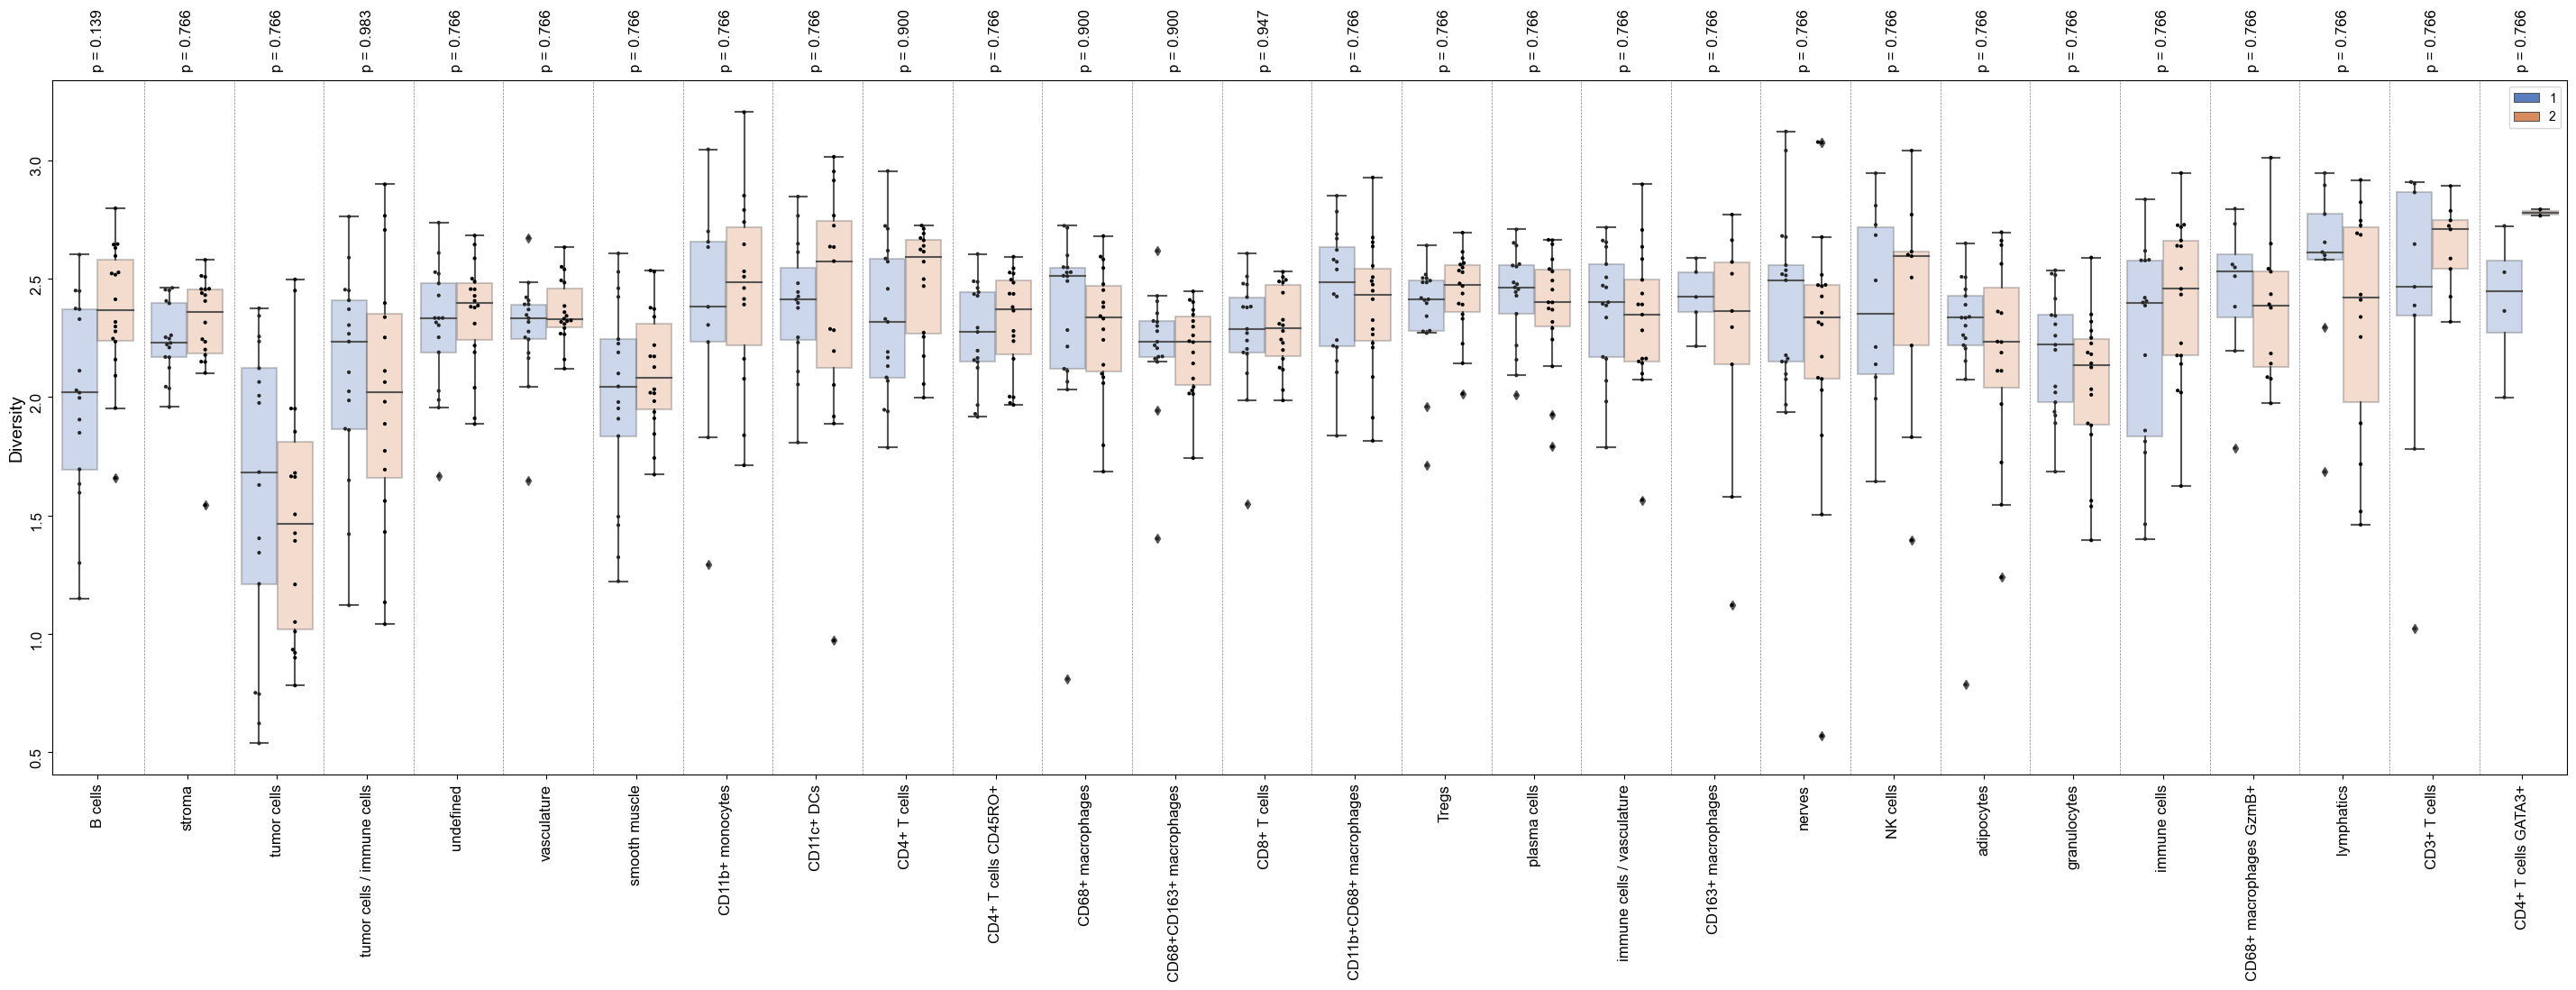

In [18]:
save_path = 'cell_diveristy_'+cluster_key.split(' ')[0]+'.svg'

# Visualization
fig, ax = plt.subplots(figsize=(36,10))
sns.boxplot(data=protein_diversity, x=cluster_key, y='diversity', hue='groups', palette='muted', boxprops=dict(alpha=.3))
sns.swarmplot(data=protein_diversity, x=cluster_key, y='diversity', hue='groups', dodge=True, size=3.0, palette='dark:black')

yrange = ax.get_ylim()[1] + 0.05
for i, ct in enumerate(protein_diversity[cluster_key].unique()):
    ax.text(i, yrange, f"p = {anova_pvals_corrected[i]:.3f}", ha='center', fontsize=12, rotation=90)
    
for i in range(len(protein_diversity[cluster_key].unique()) - 1):
    ax.axvline(i + 0.52, color='grey', linestyle='--', linewidth=0.5)

handles, labels = plt.gca().get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2], loc=1)

ax.set_ylabel("Diversity", fontsize=14)
ax.set_xlabel('')
plt.xticks(fontsize=12, rotation=90)  
plt.yticks(fontsize=12, rotation=90) 

fig.savefig('../figures/crc/'+save_path)
save_path = save_path.replace('.svg', '.jpeg')
fig.savefig('../figures/crc/'+save_path)
plt.show()
plt.close(fig)

# Neighbourhood Diversity

In [21]:
# Group by 'File Name', 'neighborhood name', 'ClusterName' and count occurrences
grouped = protein.groupby(['File Name', 'neighborhood name', 'ClusterName', 'groups']).size().reset_index(name='counts')

# Calculate proportions by dividing by the sum of counts for each 'File Name', 'neighborhood name' and 'groups'
grouped['proportions'] = grouped.groupby(['File Name', 'neighborhood name', 'groups'])['counts'].transform(lambda x: x / x.sum())

# Compute Shannon entropy for each 'File Name', 'neighborhood name' and 'groups'
grouped['entropy_component'] = -grouped['proportions'] * np.log2(grouped['proportions'])
entropy = grouped.groupby(['File Name', 'neighborhood name', 'groups'])['entropy_component'].sum().reset_index(name='shannon_entropy')

print(entropy)

    File Name           neighborhood name  groups  shannon_entropy
0    reg001_A                    Follicle       1         2.629675
1    reg001_A        Granulocyte enriched       1         2.458689
2    reg001_A   Immune-infiltrated stroma       1         2.829965
3    reg001_A         Macrophage enriched       1         2.589081
4    reg001_A             T cell enriched       1         3.177282
..        ...                         ...     ...              ...
988  reg070_B   Immune-infiltrated stroma       1         2.279529
989  reg070_B         Macrophage enriched       1         2.300880
990  reg070_B             T cell enriched       1         2.200016
991  reg070_B              Tumor boundary       1         2.576639
992  reg070_B  Vascularized smooth muscle       1         1.000000

[993 rows x 4 columns]


In [25]:
entropy['Patient'] = entropy['File Name'].map(region_to_patient)

# Compute the average entropy for each neighborhood type across regions at the patient level
patient_level_entropy = entropy.groupby(['Patient', 'neighborhood name', 'groups'])['shannon_entropy'].mean().reset_index()

# Get unique values for reindexing
unique_patients = entropy['Patient'].unique()
unique_neighborhoods = entropy['neighborhood name'].unique()

all_combinations = pd.DataFrame(pd.MultiIndex.from_product([unique_patients, unique_neighborhoods], 
                                                          names=['Patient', 'neighborhood name']).tolist(), columns=['Patient', 'neighborhood name'])

# Merge the created DataFrame with patient_level_entropy, filling in missing values
merged = pd.merge(all_combinations, patient_level_entropy, on=['Patient', 'neighborhood name'], how='left')
merged['shannon_entropy'].fillna(0, inplace=True)

merged['groups'] = merged['Patient'].map(patient_level_entropy.drop_duplicates('Patient').set_index('Patient')['groups'])

     Patient           neighborhood name  groups  shannon_entropy
0          1                    Follicle       1         2.629675
1          1        Granulocyte enriched       1         2.272351
2          1   Immune-infiltrated stroma       1         2.179653
3          1         Macrophage enriched       1         2.712039
4          1             T cell enriched       1         2.547685
..       ...                         ...     ...              ...
310       35             T cell enriched       1         2.945344
311       35              Tumor boundary       1         2.667374
312       35  Vascularized smooth muscle       1         1.844167
313       35               Smooth muscle       1         1.158646
314       35                  Bulk tumor       1         0.854335

[315 rows x 4 columns]


p-value before correction: 
Bulk tumor has p value = 0.662
Follicle has p value = 0.004
Granulocyte enriched has p value = 0.425
Immune-infiltrated stroma has p value = 0.779
Macrophage enriched has p value = 0.213
Smooth muscle has p value = 0.671
T cell enriched has p value = 0.778
Tumor boundary has p value = 0.620
Vascularized smooth muscle has p value = 0.642
------------------------------------------
p-values after correction: 
Bulk tumor has p value = 0.779
Follicle has p value = 0.038
Granulocyte enriched has p value = 0.779
Immune-infiltrated stroma has p value = 0.779
Macrophage enriched has p value = 0.779
Smooth muscle has p value = 0.779
T cell enriched has p value = 0.779
Tumor boundary has p value = 0.779
Vascularized smooth muscle has p value = 0.779


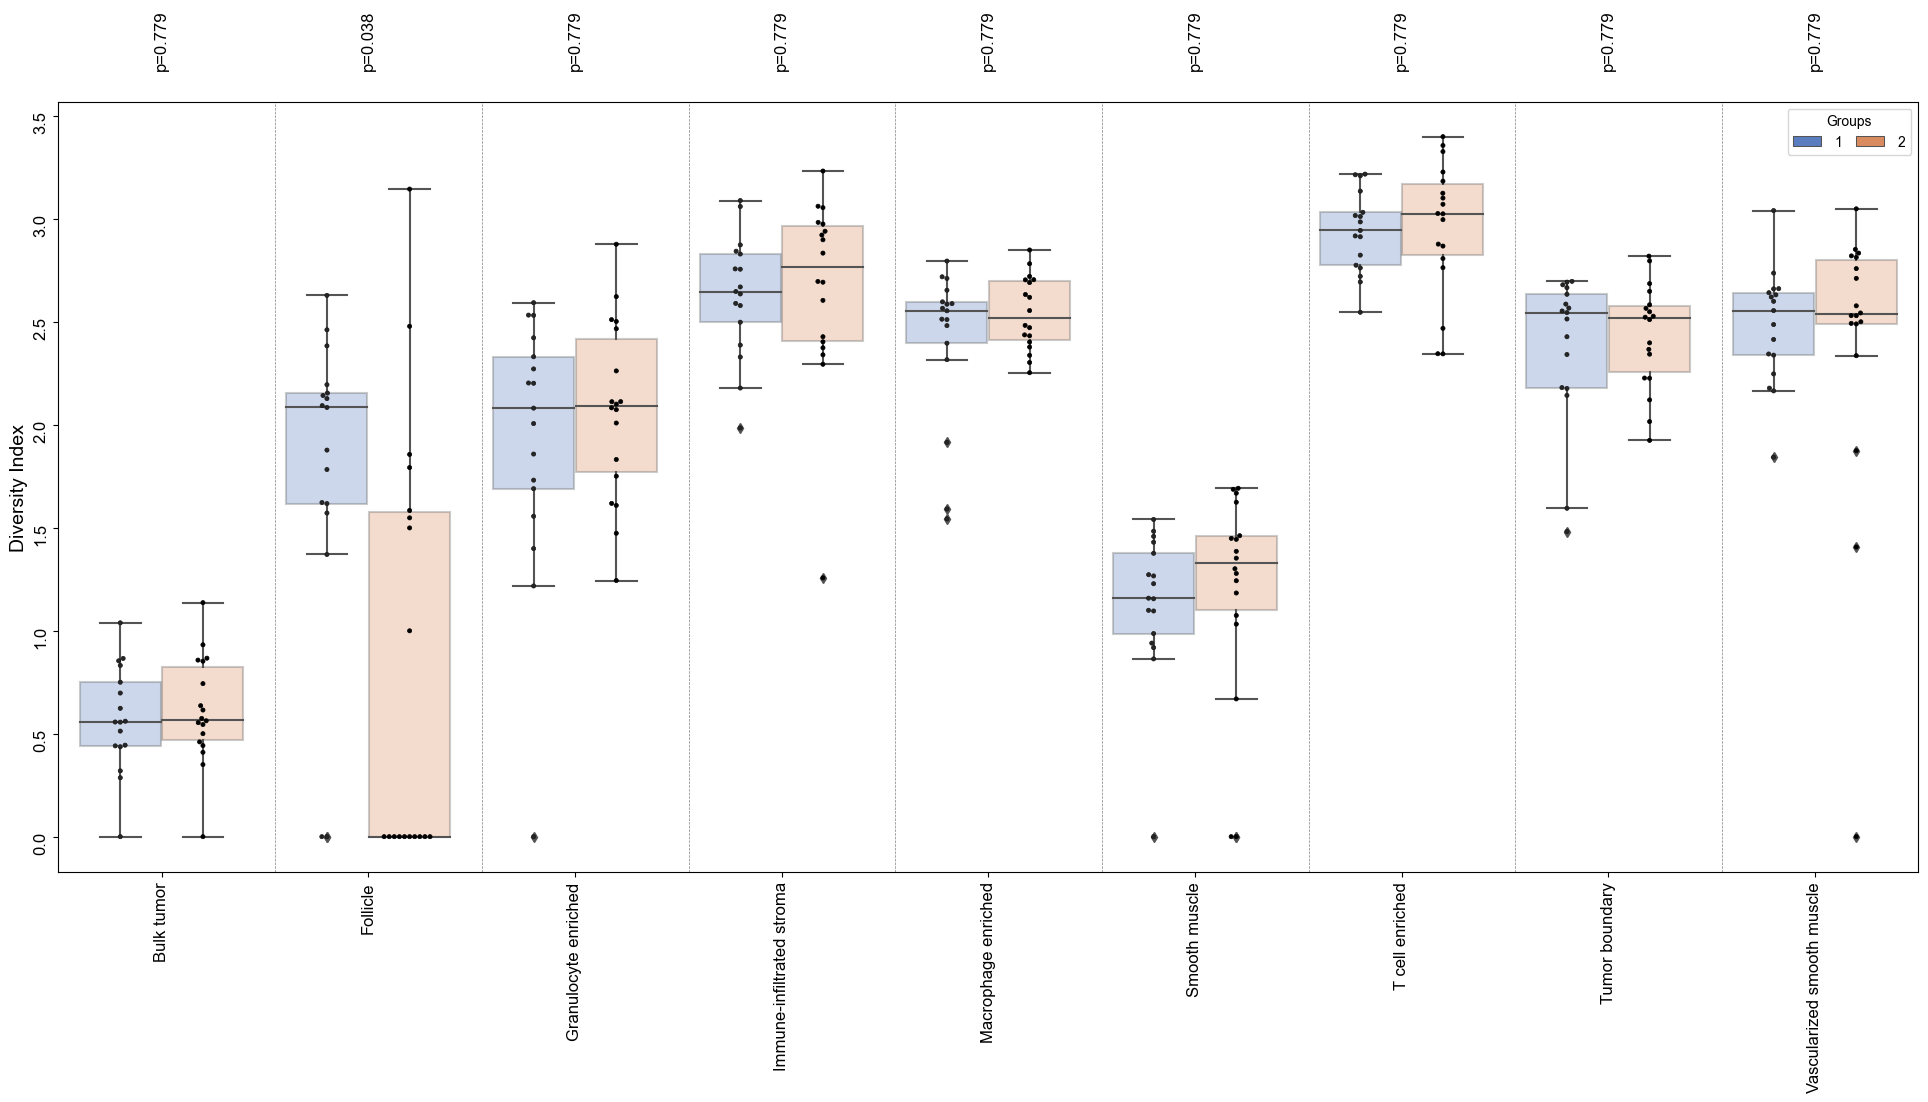

In [27]:
save_path = 'neighbourhood_celltype_diversity.svg'
selected_p_values = []
selected_cell_types = sorted(merged['neighborhood name'].unique())

# Filter data for selected cell types
filtered_data = merged[merged['neighborhood name'].isin(selected_cell_types)]

fig, ax = plt.subplots(figsize=(24,10))

# Boxplot for selected cell types
sns.boxplot(data=filtered_data, x='neighborhood name', y='shannon_entropy', hue='groups', palette="muted",boxprops=dict(alpha=.3), ax=ax, order=selected_cell_types)

# Swarmplot for selected cell types
sns.swarmplot(data=filtered_data, x='neighborhood name', y='shannon_entropy', hue='groups', palette='dark:black', size=3.0, dodge=True, ax=ax, edgecolor='gray', linewidth=0.5, order = selected_cell_types)

# Adding a legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], title="Groups", handletextpad=1, columnspacing=1, bbox_to_anchor=(1, 1), ncol=3, frameon=True)
plt.xticks(rotation=0)

print(f"p-value before correction: ")
# Displaying the p-values on the plot
yrange = ax.get_ylim()[1] - ax.get_ylim()[0]
for i, cell in enumerate(selected_cell_types):
    group1_data = filtered_data[(filtered_data['neighborhood name'] == cell) & (filtered_data['groups'] == 1)]['shannon_entropy']
    group2_data = filtered_data[(filtered_data['neighborhood name'] == cell) & (filtered_data['groups'] == 2)]['shannon_entropy']
    t_stat, p_value = stats.ttest_ind(group1_data, group2_data, equal_var=False)
    selected_p_values.append(p_value)
    print(f"{cell} has p value = {p_value:.3f}")
    
pvals_corrected = stats.false_discovery_control(selected_p_values, method='bh')

print('-'*42)
print(f"p-values after correction: ")
for i, ct in enumerate(selected_cell_types):
    plt.text(i, yrange, f"p={pvals_corrected[i]:.3f}", fontsize=12, ha='center', rotation=90)  
    print(f"{ct} has p value = {pvals_corrected[i]:.3f}", flush=True)
    
for i in range(len(selected_cell_types) - 1):
    ax.axvline(i + 0.55, color='grey', linestyle='--', linewidth=0.5)
    
ax.set_ylabel("Diversity Index", fontsize=14)
ax.set_xlabel('') 
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12, rotation=90)
fig.savefig('../figures/crc/'+save_path)
plt.show()
plt.close(fig)

# Heatmap & Hot/Cold Spots Illustration

In [14]:
import matplotlib.patches as patches

In [15]:
# Only run this cell to produce cell-type map
print(len(pd.unique(protein['ClusterNameV2'])), flush=True)
protein = protein[~protein['ClusterNameV2'].str.contains('remove')]
bokai_palette = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', 
                 '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', 
                 '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#000000']
bokai_palette = dict(zip(pd.unique(protein['ClusterNameV2']), bokai_palette))

22


In [16]:
test_sample = 'reg021_A'
test_scale = 32.0

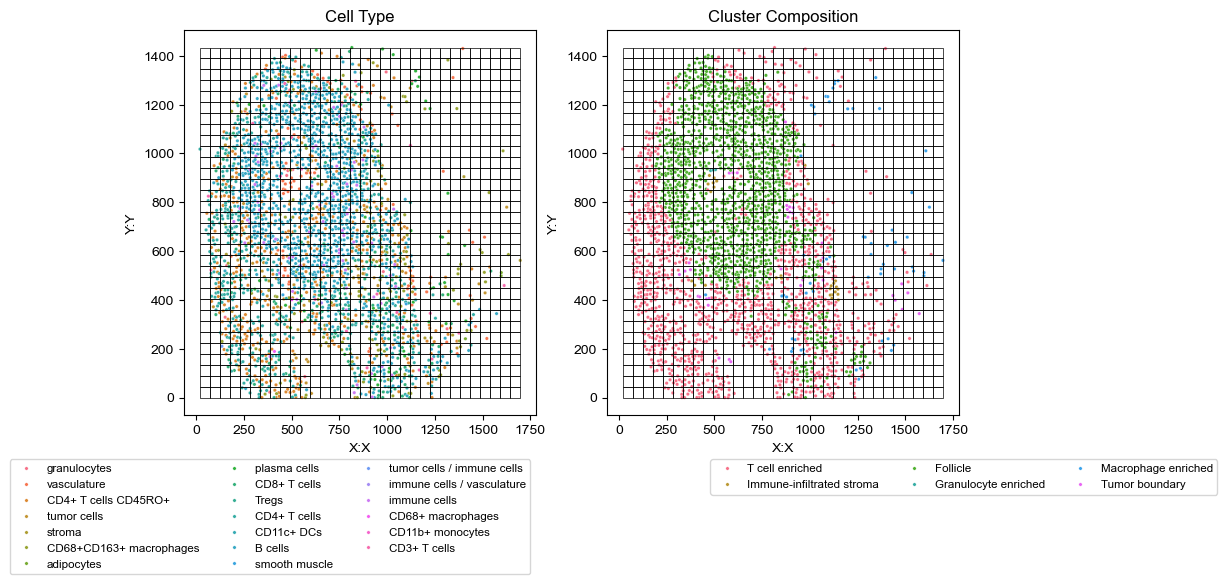

In [17]:
# Illustrate patch sampling
protein_region = protein.loc[protein['File Name'] == test_sample,:]
#patches_coordinates = msd.generate_patches_randomly(protein_region, scaling_factor=1.0, spatial_key=['X:X','Y:Y'], max_overlap=1.0 ,random_seed=None, min_points=2.0)
patches_coordinates = msd.generate_patches(protein, 'File Name', test_sample, scaling_factor=test_scale, spatial_key=['X:X','Y:Y'])

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.scatterplot(data=protein_region, x="X:X", y="Y:Y", hue="ClusterName", palette='husl', s=6, legend='full', ax=axes[0])
axes[0].set_title('Cell Type')
axes[0].legend(bbox_to_anchor=(1.0, -0.1), ncol=3, fontsize='small')

sns.scatterplot(data=protein_region, x="X:X", y="Y:Y", hue="neighborhood name", palette='husl', s=6, ax=axes[1])
axes[1].set_title('Cluster Composition')
axes[1].legend(bbox_to_anchor=(1.75, -0.1), ncol=3, fontsize='small')

# draw each patch as a rectangle
for patch in patches_coordinates:
    rect1 = patches.Rectangle((patch[0], patch[1]), patch[2] - patch[0], patch[3] - patch[1], linewidth=0.5, edgecolor='black', facecolor='none')
    rect2 = patches.Rectangle((patch[0], patch[1]), patch[2] - patch[0], patch[3] - patch[1], linewidth=0.5, edgecolor='black', facecolor='none')
    axes[0].add_patch(rect1)
    axes[1].add_patch(rect2)

plt.show()

In [18]:
x_coords = protein_region['X:X']
y_coords = protein_region['Y:Y']
width = x_coords.max(axis=0) - x_coords.min(axis=0)
height = y_coords.max(axis=0) - y_coords.min(axis=0)
w, h = figaspect(height/width)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(w, h))

sns.scatterplot(data=protein_region, x="X:X", y="Y:Y", hue="ClusterNameV2", palette=bokai_palette, s=18, legend='full', ax=ax, rasterized=True)
ax.set_title('Cluster Protein')
ax.legend(bbox_to_anchor=(1.5, -0.1), ncol=3, fontsize=14)
ax.invert_yaxis()
save_path = test_sample + '_celltype.svg'
fig.savefig('../figures/crc/'+save_path, dpi=300)
plt.show()

37.012 per cent patches are empty


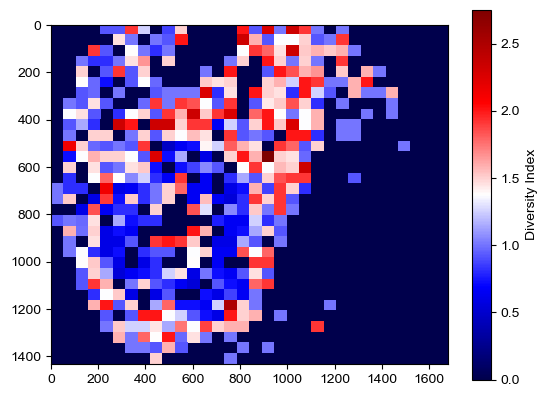

In [20]:
patch_indices, patches_comp = msd.calculate_diversity_index(spatial_data=protein, 
                                                                library_key='File Name', 
                                                                library_id=test_sample, 
                                                                spatial_key=['X:X','Y:Y'], 
                                                                patches=patches_coordinates, 
                                                                cluster_key='ClusterName', 
                                                                metric='Shannon Diversity', return_comp=True)


# Visualize the heterogeneity indices
grid, heatmap_fig = msd.diversity_heatmap(spatial_data=protein,
                                          library_key='File Name',
                                          library_id=test_sample,
                                          spatial_key=['X:X','Y:Y'],
                                          patches=patches_coordinates, 
                                          heterogeneity_indices=patch_indices,
                                          tissue_only=True,
                                          plot=True,
                                          return_fig=True)

In [16]:
save_path = test_sample + '_heatmap.svg'
heatmap_fig.savefig('../figures/crc/'+save_path)
plt.close(heatmap_fig)

In [17]:
print(msd.global_moran(grid,tissue_only=True))

Global Moran restricted to tissue region with w of shape(645, 645)
(0.1689359872847156, 0.001)


/opt/miniconda3/envs/mesa/lib/python3.11/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 13 disconnected components.
 There are 10 islands with ids: 253, 574, 600, 604, 664, 666, 734, 757, 857, 1018.
  warnings.warn(message)


In [ ]:
plt.imshow(grid,cmap='seismic')
plt.colorbar()

In [19]:
hotspots, coldspots, doughnuts, diamonds = msd.local_moran(grid, tissue_only=True, p_value=0.05, seed=42)
print(sum(hotspots.flatten()), flush=True)
print(sum(coldspots.flatten()), flush=True)
print(sum(doughnuts.flatten()), flush=True)
print(sum(diamonds.flatten()), flush=True)

(645,)
Local Moran restricted to tissue region with w of shape(645, 645)
78
93
36
32


In [20]:
combined_spots = (hotspots * 1) + (coldspots * -1) #+ (doughnuts * 0.5) + (diamonds * -0.5)
seismic = plt.cm.seismic
colors = [seismic(0), "lightblue", "white", "salmon", seismic(0.999)]
cmap = mcolors.LinearSegmentedColormap.from_list("custom_map", colors)

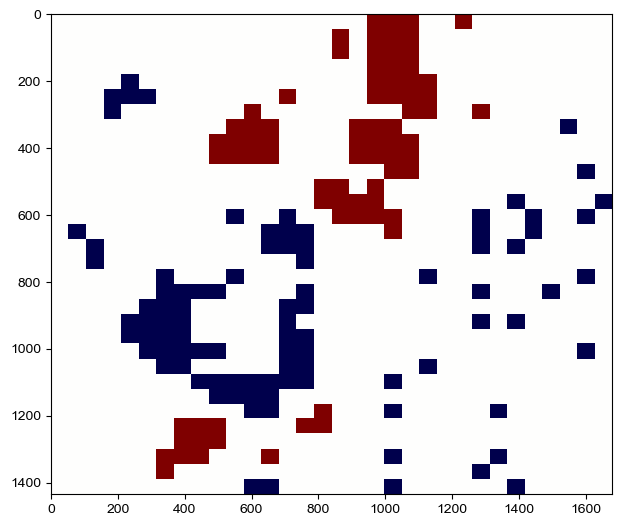

In [21]:
spot_fig = plt.figure(figsize=(w, h))
ax = spot_fig.add_axes([0, 0, 1, 1])

min_x, min_y = np.min(x_coords), np.min(y_coords)
max_x, max_y = np.max(x_coords), np.max(y_coords)

# Create a 2D grid
grid = np.zeros((int(max_y - min_y + 1), int(max_x - min_x + 1)))

# Fill the grid with heterogeneity indices
for patch, diversity_index in enumerate(combined_spots.flatten()):
    x0, y0, x1, y1 = patches_coordinates[patch]
    grid[int(y0-min_y):int(y1-min_y+1), int(x0-min_x):int(x1-min_x+1)] = diversity_index

# Plot the heatmap
ax.imshow(grid, cmap=cmap, interpolation='none', vmin=-1, vmax=1)

# save_path = test_sample + '_spot.svg'
# spot_fig.savefig('../figures/crc/'+save_path, dpi=300)

In [22]:
filtered_patches_coordinates = [patch for patch, is_hotspot in zip(patches_coordinates, hotspots.flatten()) if is_hotspot]
print(len(filtered_patches_coordinates), flush=True)

78


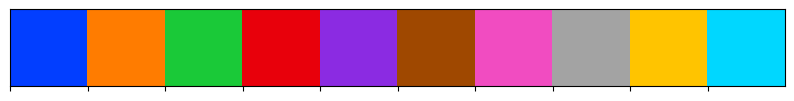

In [23]:
cell_types_visual = ['B cells', 'CD4+ T cells CD45RO+']
marker_dict = {
    cell_types_visual[0]: 'X',
    cell_types_visual[1]: '^'
}
custom_colors = sns.color_palette("bright")
sns.palplot(custom_colors)

color_dict = {
    cell_types_visual[0]: custom_colors[-1],
    cell_types_visual[1]: custom_colors[-5]
}

1677
1434


/opt/miniconda3/envs/mesa/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/mesa/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/mesa/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/mesa/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Ca

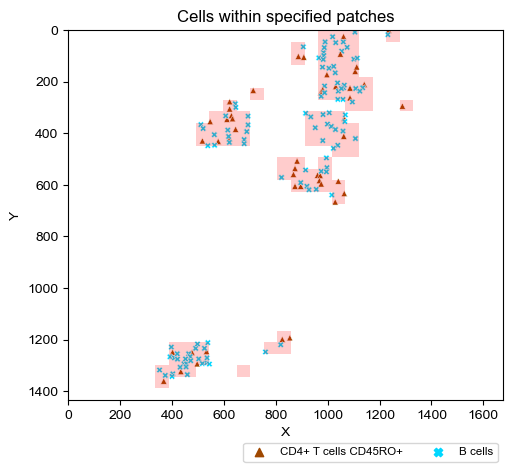

In [24]:
co_loc_fig = msd.plot_cells_patches(protein, 
                                    'File Name',
                                    test_sample,
                                    ['X:X','Y:Y'],
                                    'ClusterName',
                                    filtered_patches_coordinates,
                                    selected_cell_types=cell_types_visual,
                                    marker_styles=marker_dict,
                                    color_palette=color_dict,
                                    patch_alpha=0.2)
# save_path = test_sample + '_coloc.svg'
# co_loc_fig.savefig('../figures/crc/'+save_path, dpi=300)

## Export cells in hot/cold spots 

In [33]:
Hot = False
library_names = ['CLR', 'DII'] 
filtered_dataframes = []
for library, library_name in zip(library_ids, library_names):
    for library_id in library:
        patches_coordinates = msd.generate_patches(spatial_data=protein,
                                                   library_key='File Name', 
                                                   library_id=library_id, 
                                                   scaling_factor=32., 
                                                   spatial_key=['X:X','Y:Y'])
        
        patch_indices, patches_comp = msd.calculate_diversity_index(spatial_data=protein, 
                                                                        library_key='File Name', 
                                                                        library_id=library_id, 
                                                                        spatial_key=['X:X','Y:Y'], 
                                                                        patches=patches_coordinates, 
                                                                        cluster_key='ClusterName', 
                                                                        metric='Shannon Diversity', return_comp=True)
    
        grid = msd.diversity_heatmap(spatial_data=protein,
                                     library_key='File Name',
                                     library_id=library_id,
                                     spatial_key=['X:X','Y:Y'],
                                     patches=patches_coordinates, 
                                     heterogeneity_indices=patch_indices,
                                     plot=False,
                                     return_fig=False)
        hotspots, coldspots, _, _ = msd.local_moran(grid, tissue_only=False, p_value=0.05)
        print(f"{library_id} has {sum(hotspots.flatten())} hotspots")
        if Hot:
            filtered_patches_coordinates = [patch for patch, is_hotspot in zip(patches_coordinates, hotspots.flatten()) if is_hotspot]
        else:
            filtered_patches_coordinates = [patch for patch, is_coldspot in zip(patches_coordinates, coldspots.flatten()) if is_coldspot]
        protein_region = protein[protein['File Name']==library_id]
        
        for filtered_patch_coordinate in filtered_patches_coordinates:
            x0, y0, x1, y1 = filtered_patch_coordinate  
            
            filtered_protein_patch = protein_region[
                (protein_region['X:X'] >= x0) & 
                (protein_region['X:X'] < x1) & 
                (protein_region['Y:Y'] >= y0) & 
                (protein_region['Y:Y'] < y1)
            ]
            
            filtered_dataframes.append(filtered_protein_patch)

final_filtered_protein = pd.concat(filtered_dataframes, ignore_index=True)

46.875 per cent patches are empty
reg001_A has 106 hotspots
75.684 per cent patches are empty
reg001_B has 11 hotspots
46.094 per cent patches are empty
reg002_A has 157 hotspots
19.238 per cent patches are empty
reg002_B has 45 hotspots
30.762 per cent patches are empty
reg011_A has 257 hotspots
51.660 per cent patches are empty
reg011_B has 67 hotspots
32.910 per cent patches are empty
reg012_A has 157 hotspots
77.148 per cent patches are empty
reg012_B has 64 hotspots
53.613 per cent patches are empty
reg019_A has 192 hotspots
92.188 per cent patches are empty
reg019_B has 0 hotspots
23.438 per cent patches are empty
reg020_A has 161 hotspots
19.434 per cent patches are empty
reg020_B has 175 hotspots
37.012 per cent patches are empty
reg021_A has 209 hotspots
76.660 per cent patches are empty
reg021_B has 12 hotspots
36.816 per cent patches are empty
reg022_A has 223 hotspots
62.598 per cent patches are empty
reg022_B has 57 hotspots
52.148 per cent patches are empty
reg023_A has 4

In [40]:
final_filtered_protein['patients']

0         6
1         6
2         6
3         6
4         6
         ..
11118    31
11119    31
11120    31
11121    31
11122    31
Name: patients, Length: 11123, dtype: int64

In [38]:
for col in final_filtered_protein.columns:
    print(col)

Unnamed: 0.1
Unnamed: 0
CellID
ClusterID
EventID
File Name
Region
TMA_AB
TMA_12
Index in File
groups
patients
spots
CD44 - stroma:Cyc_2_ch_2
FOXP3 - regulatory T cells:Cyc_2_ch_3
CD8 - cytotoxic T cells:Cyc_3_ch_2
p53 - tumor suppressor:Cyc_3_ch_3
GATA3 - Th2 helper T cells:Cyc_3_ch_4
CD45 - hematopoietic cells:Cyc_4_ch_2
T-bet - Th1 cells:Cyc_4_ch_3
beta-catenin - Wnt signaling:Cyc_4_ch_4
HLA-DR - MHC-II:Cyc_5_ch_2
PD-L1 - checkpoint:Cyc_5_ch_3
Ki67 - proliferation:Cyc_5_ch_4
CD45RA - naive T cells:Cyc_6_ch_2
CD4 - T helper cells:Cyc_6_ch_3
CD21 - DCs:Cyc_6_ch_4
MUC-1 - epithelia:Cyc_7_ch_2
CD30 - costimulator:Cyc_7_ch_3
CD2 - T cells:Cyc_7_ch_4
Vimentin - cytoplasm:Cyc_8_ch_2
CD20 - B cells:Cyc_8_ch_3
LAG-3 - checkpoint:Cyc_8_ch_4
Na-K-ATPase - membranes:Cyc_9_ch_2
CD5 - T cells:Cyc_9_ch_3
IDO-1 - metabolism:Cyc_9_ch_4
Cytokeratin - epithelia:Cyc_10_ch_2
CD11b - macrophages:Cyc_10_ch_3
CD56 - NK cells:Cyc_10_ch_4
aSMA - smooth muscle:Cyc_11_ch_2
BCL-2 - apoptosis:Cyc_11_ch_3
CD25 - I

In [34]:
if Hot:
    final_filtered_protein.to_csv('/Users/Emrys/Dropbox/spatial_augmentation/data/cells_in_hotspots.csv', index=False)
else:
    final_filtered_protein.to_csv('/Users/Emrys/Dropbox/spatial_augmentation/data/cells_in_coldspots.csv', index=False)

## Visualise the exported dataframe (sanity check)

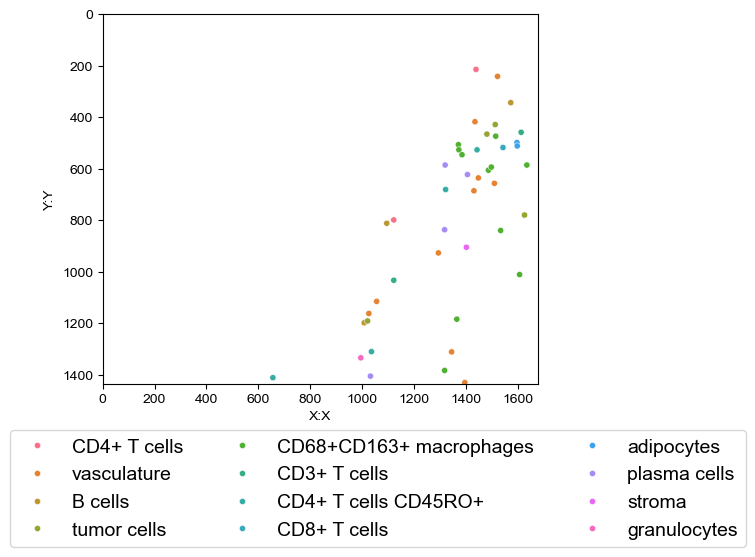

In [35]:
plt.figure(figsize=(w, h))
sns.scatterplot(
    x='X:X', 
    y='Y:Y', 
    data=final_filtered_protein[final_filtered_protein['File Name'] == test_sample], 
    s=20,
    hue='ClusterName'
)

plt.xlabel('X:X')
plt.ylabel('Y:Y')
plt.gca().set_xlim(0, width)
plt.gca().set_ylim(0, height)
plt.gca().invert_yaxis()
plt.gca().legend(bbox_to_anchor=(1.5, -0.1), ncol=3, fontsize=14)
plt.show()

# Calculate Proximity Index

In [18]:
Hot = False
pvalue_cutoff = 0.05
library_names = ['CLR', 'DII'] 
PX_results = {}

for library, library_name in zip(library_ids, library_names):
    proximity_I = msd.sample_proximity(spatial_data=protein, 
                                       scale=32.0, 
                                       library_key='File Name',
                                       library_ids=library, 
                                       spatial_key=['X:X','Y:Y'],
                                       cluster_key='ClusterName',
                                       hotspot=Hot,
                                       p_value=pvalue_cutoff,
                                       metric='Shannon Diversity')

    PX_patient = []
    
    keys = list(proximity_I.keys())
    
    for patient, regions in patient_to_region.items():
        # select keys that correspond to the current patient
        selected_keys = [region for region in regions if region in keys]
        print(selected_keys)
        
        if selected_keys:
            # list to store the selected series
            PX_list = [proximity_I[key] for key in selected_keys]

            # take the max value
            PX_patient.append(np.array(PX_list).max())
    
    # Store Moran's I 
    PX_results[library_name] = PX_patient

Processing region: reg001_A at scale 32.0
46.582 per cent patches are empty
Using MoranI
Region reg001_A contains 0 diversity coldspots
0 islands identified
Processing region: reg001_B at scale 32.0
75.293 per cent patches are empty
Using MoranI
Region reg001_B contains 605 diversity coldspots
3 islands identified
Processing region: reg002_A at scale 32.0
45.996 per cent patches are empty
Using MoranI
Region reg002_A contains 270 diversity coldspots
7 islands identified
Processing region: reg002_B at scale 32.0
19.238 per cent patches are empty
Using MoranI
Region reg002_B contains 0 diversity coldspots
0 islands identified
Processing region: reg011_A at scale 32.0
30.371 per cent patches are empty
Using MoranI
Region reg011_A contains 291 diversity coldspots
9 islands identified
Processing region: reg011_B at scale 32.0
51.562 per cent patches are empty
Using MoranI
Region reg011_B contains 0 diversity coldspots
0 islands identified
Processing region: reg012_A at scale 32.0
32.910 per

In [20]:
PX_results

{'CLR': [426.6269655723521,
  281.23497467281146,
  128.28157181524887,
  88.44402962482513,
  72.57492026723357,
  120.95815280171307,
  73.35522831154607,
  127.4512654507891,
  91.77632720822442,
  116.31347613987505,
  69.32271639147636,
  115.57277793904416,
  315.32715028516907,
  95.52479156370867,
  415.07168055650334,
  47.913898933444344,
  264.5095216249705],
 'DII': [33.1373916614603,
  65.00371519907863,
  91.29952534226452,
  78.55371299076705,
  107.70185306215235,
  55.317612545990094,
  118.44154344513461,
  99.38607908802892,
  156.7112248340759,
  114.23823666843286,
  104.66863348683933,
  398.3746716885475,
  34.21179129413584,
  41.94336725359249,
  105.72282587895099,
  73.58199846221439,
  114.4664225410248,
  44.71035088052412]}

/var/folders/7g/phdhh_ld3dlbnrst0t60bwzr0000gn/T/ipykernel_84192/3852809926.py:20: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.swarmplot(data=data, palette='dark:black', edgecolor='gray', linewidth=0.5, size=5)


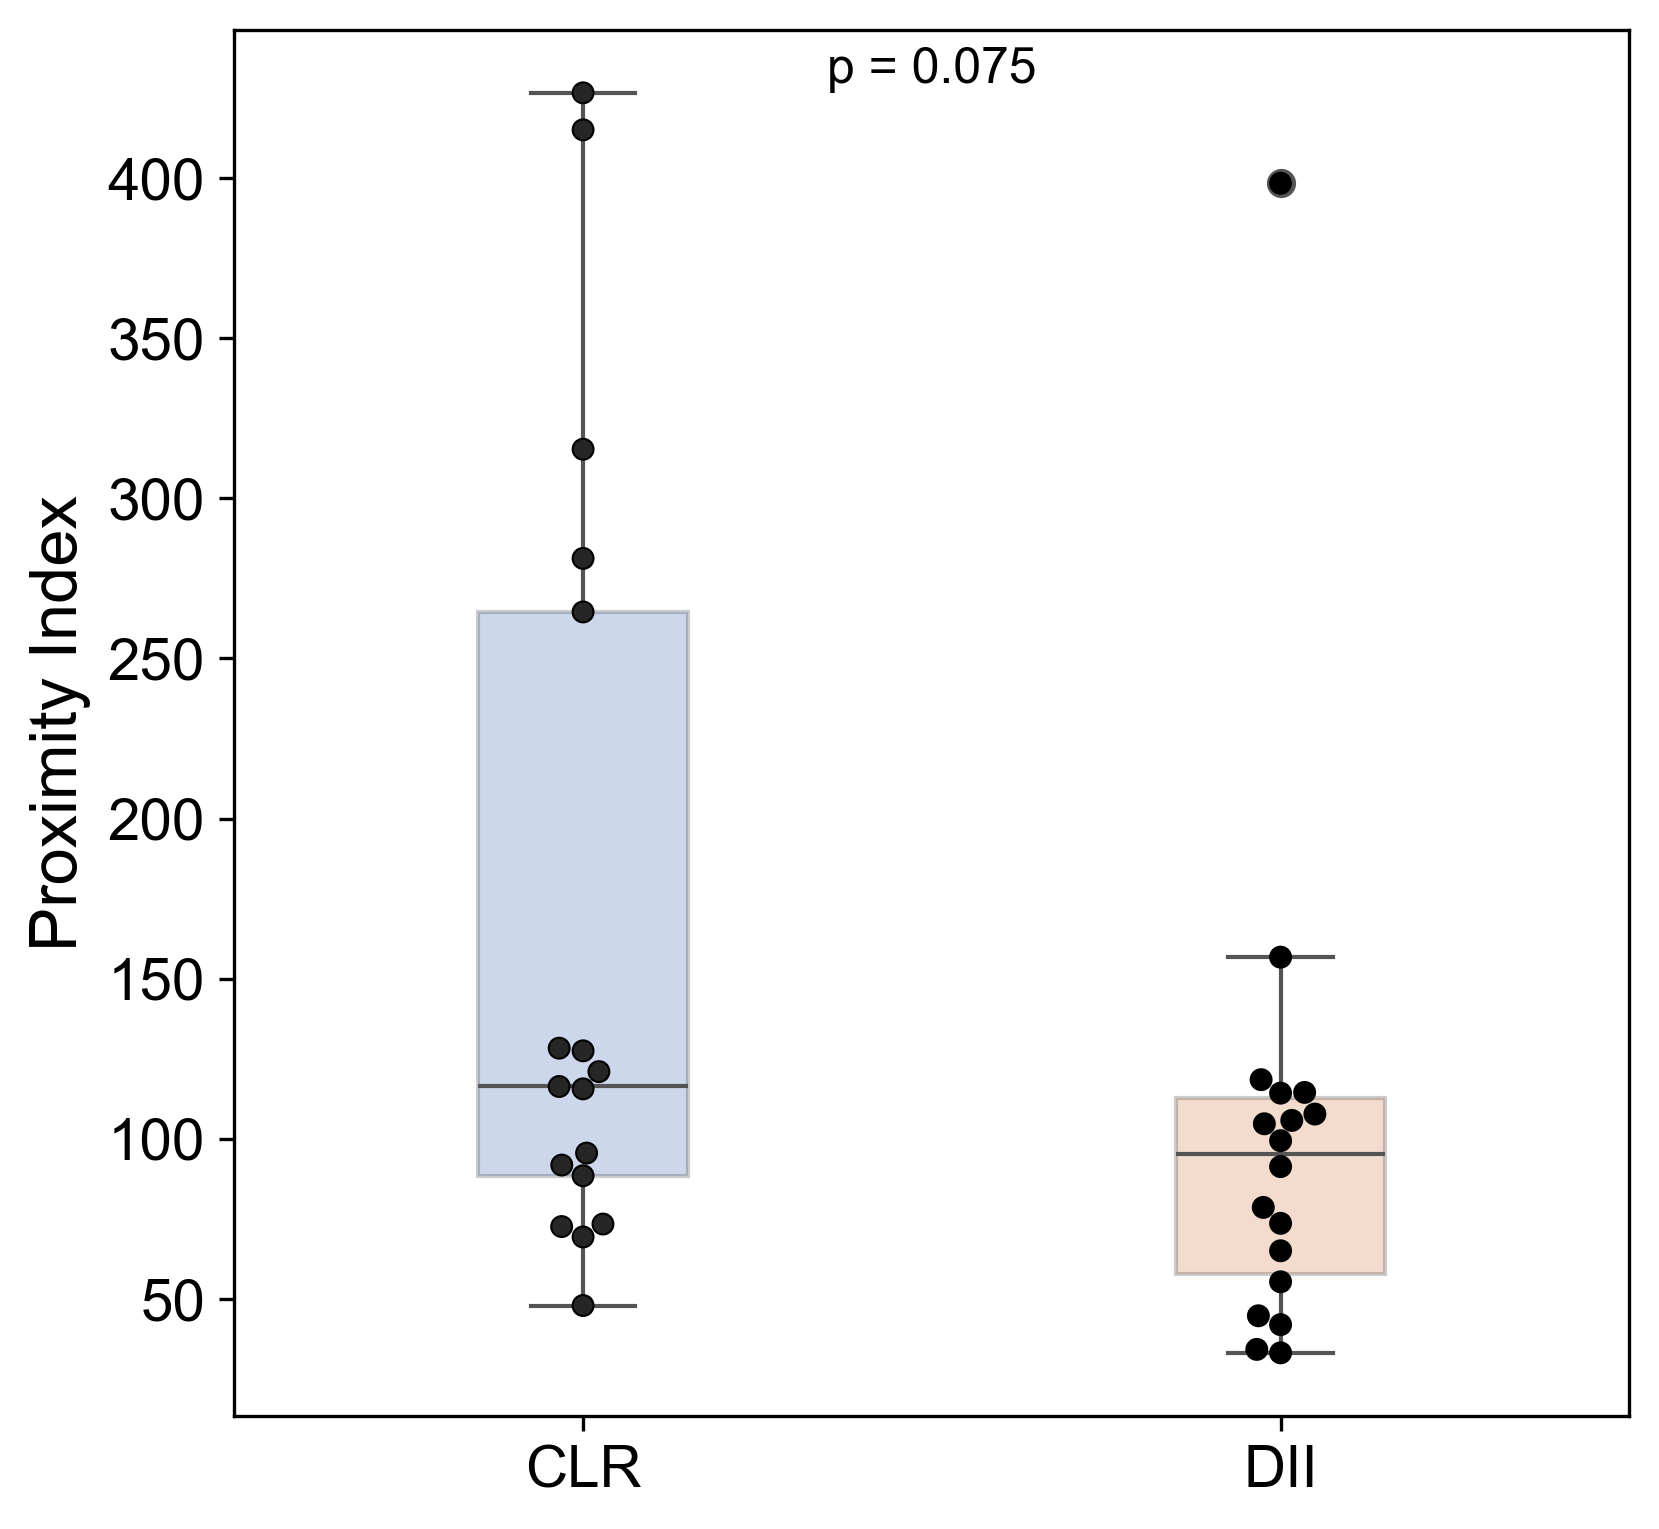

In [21]:
if Hot:
    save_path = f'pvalue{pvalue_cutoff}' + '_HotIslands_Proximity_Index.svg'
else:
    save_path = f'pvalue{pvalue_cutoff}' + '_ColdIslands_Proximity_Index.svg'

# Extract data for boxplot
clr_data = PX_results['CLR']
dii_data = PX_results['DII']

# Mann-Whitney U test
stat, p_value = stats.ttest_ind(clr_data, dii_data, nan_policy='omit', equal_var=False)

# Combining data
data = [clr_data, dii_data]
labels = ['CLR', 'DII']

# Plotting
plt.figure(figsize=(6, 6), dpi=300)  # Higher dpi for better resolution
sns.boxplot(data=data, palette="muted", boxprops=dict(alpha=.3), width=0.3)  # Adjusted width here
sns.swarmplot(data=data, palette='dark:black', edgecolor='gray', linewidth=0.5, size=5)


plt.xticks(range(len(labels)), labels, fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Proximity Index", fontsize=16)
# plt.title('Box plot of CLR vs DII', fontsize=18)

# Adding the p-value to the plot
plt.text(0.5, max(clr_data + dii_data), f'p = {p_value:.3f}', fontsize=12, horizontalalignment='center', verticalalignment='bottom')

fig = plt.gcf()
fig.savefig('../figures/crc/'+save_path)

plt.show()
plt.close(fig)

# Global Cell-type Frequency

In [25]:
cluster_key = 'ClusterName'    

In [26]:
count_df = protein.groupby(['File Name', cluster_key, 'groups']).size().reset_index(name='count')
total_cells_in_region = protein.groupby('File Name').size().reset_index(name='total')

# Merge the two dataframes on the 'File Name' column
merged_df = pd.merge(count_df, total_cells_in_region, on='File Name')

# Compute the proportion for each cell type in each region
merged_df['Frequency'] = merged_df['count'] / merged_df['total']

# Getting unique values for combinations
unique_files = protein['File Name'].unique()
unique_clusters = protein[cluster_key].unique()

# Create a DataFrame from all combinations of the unique values for File Name and ClusterName
all_combinations = pd.DataFrame(pd.MultiIndex.from_product([unique_files, unique_clusters], 
                                                          names=['File Name', cluster_key]).tolist(), columns=['File Name', cluster_key])

# Merge the created DataFrame with merged_df, filling in missing values
proportion_df = pd.merge(all_combinations, merged_df, on=['File Name', cluster_key], how='left')
proportion_df['Frequency'].fillna(0, inplace=True)
# proportion_df.dropna(subset=['Frequency'], inplace=True)

proportion_df['groups'] = proportion_df['File Name'].map(merged_df.drop_duplicates('File Name').set_index('File Name')['groups'])

print(proportion_df)

     File Name           ClusterName  groups  count   total  Frequency
0     reg001_A          granulocytes       1   80.0  1107.0   0.072267
1     reg001_A           vasculature       1  104.0  1107.0   0.093948
2     reg001_A  CD4+ T cells CD45RO+       1  134.0  1107.0   0.121048
3     reg001_A           tumor cells       1   48.0  1107.0   0.043360
4     reg001_A                stroma       1  180.0  1107.0   0.162602
...        ...                   ...     ...    ...     ...        ...
3915  reg070_B            lymphatics       1    NaN     NaN   0.000000
3916  reg070_B      CD11b+ monocytes       1    NaN     NaN   0.000000
3917  reg070_B   CD4+ T cells GATA3+       1    NaN     NaN   0.000000
3918  reg070_B    CD163+ macrophages       1    NaN     NaN   0.000000
3919  reg070_B          CD3+ T cells       1    NaN     NaN   0.000000

[3920 rows x 6 columns]


In [27]:
# Melt the dictionary into a dataframe
patient_df = pd.DataFrame([(k, region) for k, regions in patient_to_region.items() for region in regions], columns=['Patient', 'File Name'])

# Merge the proportion_df with the patient dataframe
temp = pd.merge(proportion_df, patient_df, on='File Name')
patient_avg = temp.groupby(['Patient', cluster_key, 'groups'])['Frequency'].mean().reset_index()
print(patient_avg)


     Patient                 ClusterName  groups  Frequency
0          1                     B cells       1   0.028638
1          1            CD11b+ monocytes       1   0.000000
2          1     CD11b+CD68+ macrophages       1   0.001675
3          1                  CD11c+ DCs       1   0.002922
4          1          CD163+ macrophages       1   0.000000
..       ...                         ...     ...        ...
975       35                      stroma       1   0.108381
976       35                 tumor cells       1   0.237784
977       35  tumor cells / immune cells       1   0.007261
978       35                   undefined       1   0.054263
979       35                 vasculature       1   0.050397

[980 rows x 4 columns]


In [28]:
global_cell_count = patient_avg.pivot(index='Patient', columns=cluster_key, values='Frequency')
global_cell_count.head()

ClusterName   B cells  CD11b+ monocytes  CD11b+CD68+ macrophages  CD11c+ DCs  \
Patient                                                                        
1            0.028638          0.000000                 0.001675    0.002922   
2            0.020368          0.000593                 0.026498    0.001395   
3            0.014561          0.000249                 0.011049    0.020352   
4            0.002585          0.000075                 0.006354    0.000527   
5            0.019890          0.000223                 0.060019    0.000668   

ClusterName  CD163+ macrophages  CD3+ T cells  CD4+ T cells  \
Patient                                                       
1                      0.000000      0.000000      0.007234   
2                      0.000000      0.000000      0.008217   
3                      0.000098      0.000363      0.001411   
4                      0.000213      0.000000      0.000182   
5                      0.000200      0.000120      0.000555   

ClusterName  CD4+ T cells CD45RO+  CD4+ T cells GATA3+  CD68+ macrophages  \
Patient                                                                     
1                        0.047217             0.000000           0.000824   
2                        0.050077             0.000198           0.006434   
3                        0.029020             0.000000           0.016156   
4                        0.053381             0.000000           0.009010   
5                        0.085842             0.000000           0.002798   

ClusterName  ...  immune cells / vasculature  lymphatics    nerves  \
Patient      ...                                                     
1            ...                    0.002506    0.000642  0.003184   
2            ...                    0.000000    0.000132  0.000661   
3            ...                    0.000670    0.001245  0.003828   
4            ...                    0.000467    0.000107  0.000605   
5            ...                    0.000320    0.002497  0.008374   

ClusterName  plasma cells  smooth muscle    stroma  tumor cells  \
Patient                                                           
1                0.038402       0.100548  0.083609     0.254717   
2                0.010616       0.063909  0.061606     0.209839   
3                0.007879       0.208264  0.040946     0.187000   
4                0.060775       0.050943  0.060530     0.272605   
5                0.009357       0.246006  0.090480     0.042087   

ClusterName  tumor cells / immune cells  undefined  vasculature  
Patient                                                          
1                              0.002644   0.011848     0.086353  
2                              0.000570   0.007793     0.026680  
3                              0.001009   0.003805     0.058541  
4                              0.000822   0.003279     0.038399  
5                              0.001200   0.006142     0.082436  

[5 rows x 28 columns]

## process and visualise proportion of cells in hot/cold

In [31]:
df_abundance = patient_avg.groupby(['ClusterName', 'groups'])['Frequency'].mean().reset_index()
df_abundance['groups'] = df_abundance['groups'].map({v: k for k, v in patient_condition.items()})
df_abundance = df_abundance.pivot(index='groups', columns='ClusterName', values='Frequency').reset_index()
df_abundance = df_abundance.set_index('groups') 
df_abundance

ClusterName   B cells  CD11b+ monocytes  CD11b+CD68+ macrophages  CD11c+ DCs  \
groups                                                                         
CLR          0.069471          0.000281                 0.001505    0.001385   
DII          0.016478          0.004673                 0.007303    0.001686   

ClusterName  CD163+ macrophages  CD3+ T cells  CD4+ T cells  \
groups                                                        
CLR                    0.000363      0.000272      0.012074   
DII                    0.000082      0.000911      0.003185   

ClusterName  CD4+ T cells CD45RO+  CD4+ T cells GATA3+  CD68+ macrophages  \
groups                                                                      
CLR                      0.072276             0.000508           0.004358   
DII                      0.065721             0.000022           0.011092   

ClusterName  ...  immune cells / vasculature  lymphatics    nerves  \
groups       ...                                                     
CLR          ...                    0.016573    0.000356  0.002579   
DII          ...                    0.007733    0.001711  0.002704   

ClusterName  plasma cells  smooth muscle    stroma  tumor cells  \
groups                                                            
CLR              0.038024       0.104830  0.091609     0.166579   
DII              0.029154       0.112189  0.078978     0.189360   

ClusterName  tumor cells / immune cells  undefined  vasculature  
groups                                                           
CLR                            0.003786   0.030678     0.054342  
DII                            0.007580   0.026955     0.042994  

[2 rows x 28 columns]

In [29]:
# Check if my calculation matches with the original paper
test_cell = 'B cells'

# Calculate mean and SD for all
testcell_all_data = patient_avg[(patient_avg[cluster_key] == test_cell)]
mean_testcell_all = testcell_all_data['Frequency'].mean()
sd_testcell_all = testcell_all_data['Frequency'].std()

# Calculate mean and SD for Group 1: CLR
testcell_group1_data = patient_avg[(patient_avg[cluster_key] == test_cell) & (patient_avg['groups'] == 1)]
mean_testcell_group1 = testcell_group1_data['Frequency'].mean()
sd_testcell_group1 = testcell_group1_data['Frequency'].std()

# Calculate mean and SD for Group 2: DII
testcell_group2_data = patient_avg[(patient_avg[cluster_key] == test_cell) & (patient_avg['groups'] == 2)]
mean_testcell_group2 = testcell_group2_data['Frequency'].mean()
sd_testcell_group2 = testcell_group2_data['Frequency'].std()

print(f"All - Mean ± SD: {mean_testcell_all:.3f} ± {sd_testcell_all:.3f}")
print()
print(f"CLR - Mean ± SD: {mean_testcell_group1:.3f} ± {sd_testcell_group1:.3f}")
print()
print(f"DII - Mean ± SD: {mean_testcell_group2:.3f} ± {sd_testcell_group2:.3f}")


All - Mean ± SD: 0.042 ± 0.053

CLR - Mean ± SD: 0.069 ± 0.063

DII - Mean ± SD: 0.016 ± 0.021


/var/folders/7g/phdhh_ld3dlbnrst0t60bwzr0000gn/T/ipykernel_95630/4006505854.py:14: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.swarmplot(data=filtered_data, x=cluster_key, y='Frequency', hue='groups', palette='dark:black', size=1.5, dodge=True, ax=ax, edgecolor='gray', linewidth=0.5, order = selected_cell_types)


p-value before correction: 
B cells has p value = 0.0008
CD11b+ monocytes has p value = 0.3370
CD11b+CD68+ macrophages has p value = 0.0167
CD11c+ DCs has p value = 0.2032
CD163+ macrophages has p value = 0.5386
CD3+ T cells has p value = 0.6359
CD4+ T cells has p value = 0.0105
CD4+ T cells CD45RO+ has p value = 0.8301
CD4+ T cells GATA3+ has p value = 0.2582
CD68+ macrophages has p value = 0.0087
CD68+ macrophages GzmB+ has p value = 0.9589
CD68+CD163+ macrophages has p value = 0.2834
CD8+ T cells has p value = 0.3302
NK cells has p value = 0.4877
Tregs has p value = 0.0282
adipocytes has p value = 0.0003
granulocytes has p value = 0.0153
immune cells has p value = 0.0458
immune cells / vasculature has p value = 0.4000
lymphatics has p value = 0.1428
nerves has p value = 0.8560
plasma cells has p value = 0.2283
smooth muscle has p value = 0.9605
stroma has p value = 0.4987
tumor cells has p value = 0.2038
tumor cells / immune cells has p value = 0.0218
undefined has p value = 0.1708


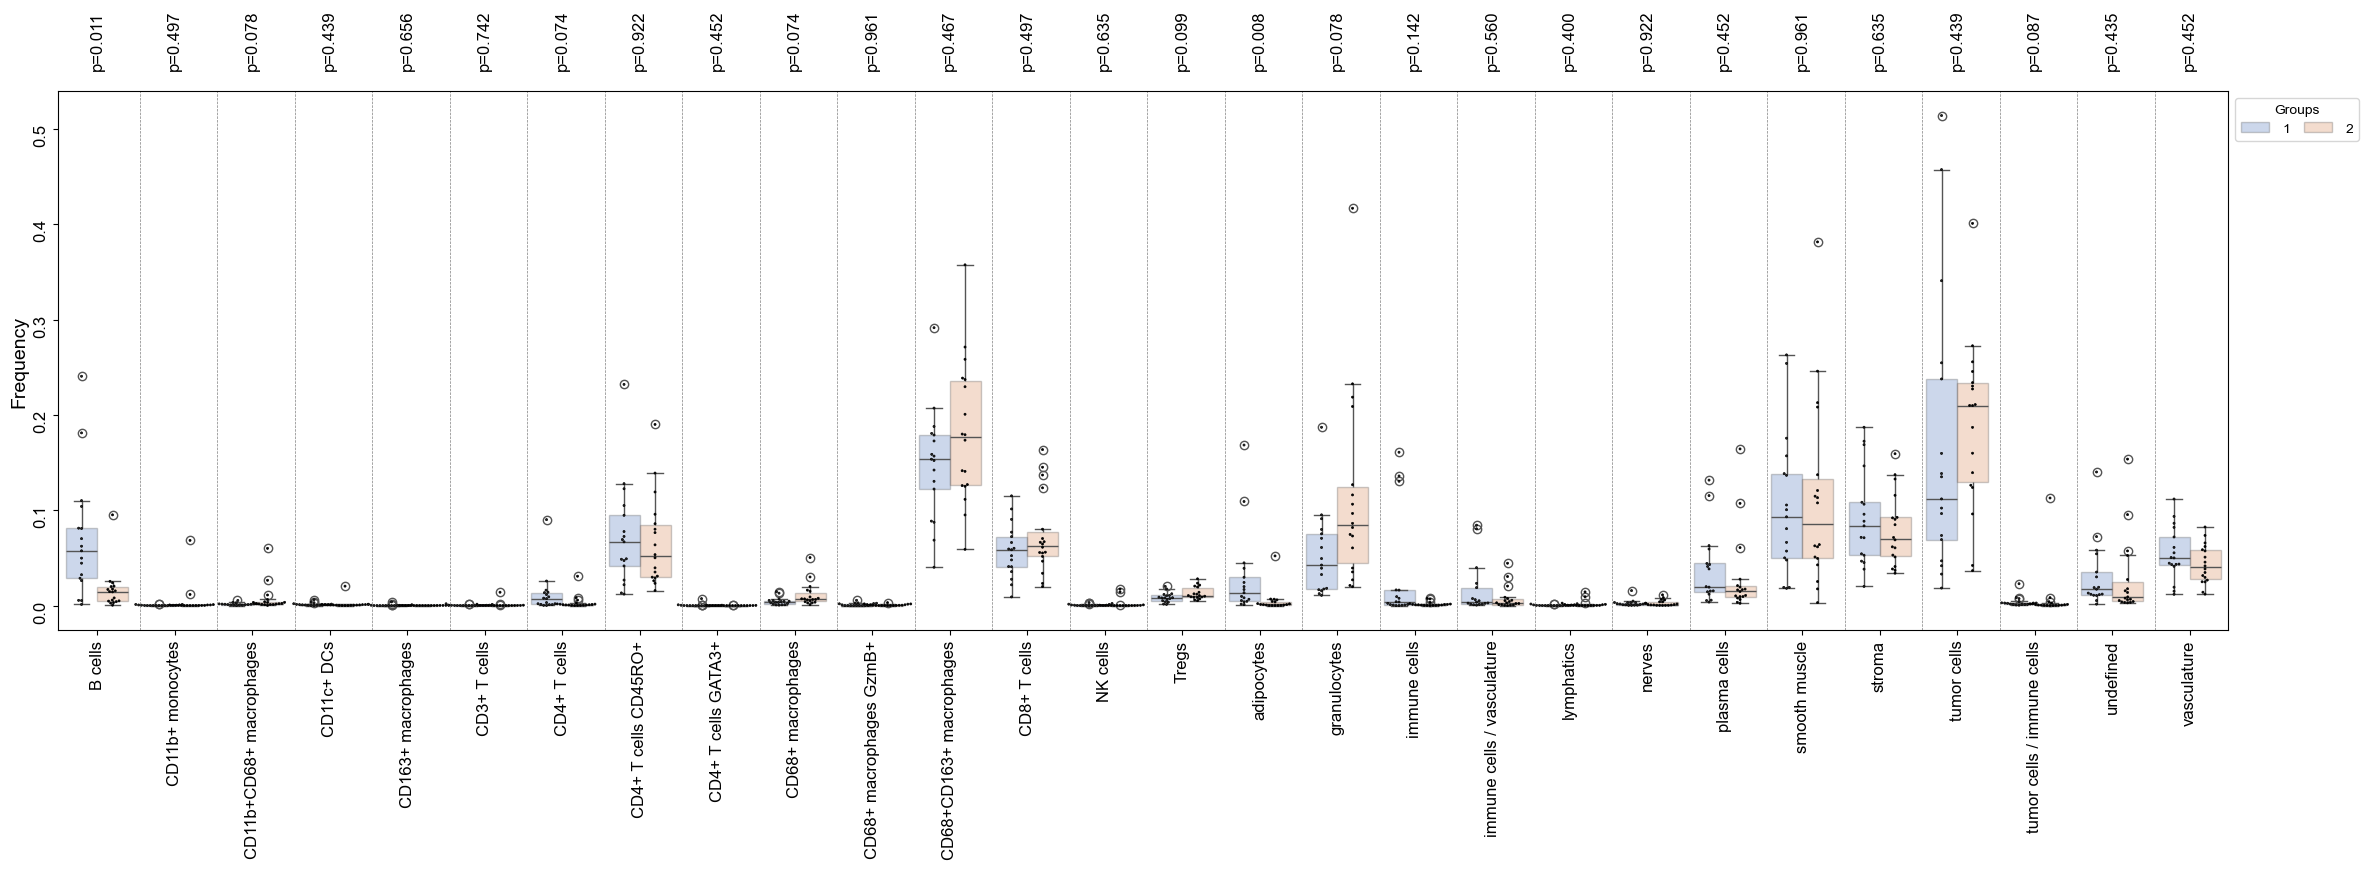

In [30]:
save_path = 'tissue_' + cluster_key.split(' ')[0] + '_freq.svg'
selected_p_values = []
selected_cell_types = sorted(patient_avg[cluster_key].unique())

# Filter data for selected cell types
filtered_data = patient_avg[patient_avg[cluster_key].isin(selected_cell_types)]

fig, ax = plt.subplots(figsize=(28,7))

# Boxplot for selected cell types
sns.boxplot(data=filtered_data, x=cluster_key, y='Frequency', hue='groups', palette="muted",boxprops=dict(alpha=.3), ax=ax, order=selected_cell_types)

# Swarmplot for selected cell types
sns.swarmplot(data=filtered_data, x=cluster_key, y='Frequency', hue='groups', palette='dark:black', size=1.5, dodge=True, ax=ax, edgecolor='gray', linewidth=0.5, order = selected_cell_types)

# Adding a legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], title="Groups", handletextpad=1, columnspacing=1, bbox_to_anchor=(1, 1), ncol=3, frameon=True)
plt.xticks(rotation=0)

print(f"p-value before correction: ")
# Displaying the p-values on the plot
yrange = ax.get_ylim()[1] - ax.get_ylim()[0]
for i, cell in enumerate(selected_cell_types):
    group1_data = filtered_data[(filtered_data[cluster_key] == cell) & (filtered_data['groups'] == 1)]['Frequency']
    group2_data = filtered_data[(filtered_data[cluster_key] == cell) & (filtered_data['groups'] == 2)]['Frequency']
    t_stat, p_value = stats.ttest_ind(group1_data, group2_data, equal_var=False)
    # t_stat, p_value = stats.mannwhitneyu(group1_data, group2_data)
    selected_p_values.append(p_value)
    print(f"{cell} has p value = {p_value:.4f}")
    
pvals_corrected = stats.false_discovery_control(selected_p_values, method='bh')

print('-'*42)
print(f"p-values after correction: ")
for i, ct in enumerate(selected_cell_types):
    plt.text(i, yrange, f"p={pvals_corrected[i]:.3f}", fontsize=12, ha='center', rotation=90)  
    print(f"{ct} has p value = {pvals_corrected[i]:.3f}", flush=True)
    
for i in range(len(selected_cell_types) - 1):
    ax.axvline(i + 0.55, color='grey', linestyle='--', linewidth=0.5)
    
ax.set_ylabel("Frequency", fontsize=14)
ax.set_xlabel('') 
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12, rotation=90)
# fig.savefig('../figures/crc/'+save_path)
plt.show()
plt.close(fig)


# Global Cell Comb Frequency

In [12]:
Hot = True
library_names = ['CLR', 'DII'] 
moran_results = {}

comp_results = []
comp_results_patient = []

comb_freq_results = []
comb_freq_results_patient = []

for library, library_name in zip(library_ids, library_names):
    total_comp_dict, global_morans, spot_comb_dict = msd.diversity_clustering(spatial_data=protein, 
                                                                              scale=32.0, 
                                                                              library_key='File Name',
                                                                              library_ids=library, 
                                                                              spatial_key=['X:X','Y:Y'],
                                                                              cluster_key='ClusterName',
                                                                              hotspot=Hot,
                                                                              p_value=0.05,
                                                                              whole_tissue=True,
                                                                              top=None,
                                                                              selected_comb=None,
                                                                              metric='Shannon Diversity')
    
    # Concatenate all the merged_series and sum across rows
    total_merged_series = pd.concat(total_comp_dict.values(), axis=1).sum(axis=1)
    comp_results.append(total_merged_series)    
    comb_freq_results.append(spot_comb_dict)
    
    # create a dictionary to store cell composition in hot/cold spots, Moran's I 
    comp_patient = pd.DataFrame()
    comb_patient = pd.DataFrame()
    moran_patient = []
    
    keys = list(total_comp_dict.keys())
    
    for patient, regions in patient_to_region.items():
        # select keys that correspond to the current patient
        selected_keys = [region for region in regions if region in keys]
        print(selected_keys)
        
        if selected_keys:
            # list to store the selected series
            series_list = [total_comp_dict[key] for key in selected_keys]
            moran_list = [global_morans[key] for key in selected_keys]
            comb_series_list = [spot_comb_dict[key] for key in selected_keys]

            # calculate the average
            patient_series = pd.concat(series_list, axis=1).fillna(0)
            patient_comb_series = pd.concat(comb_series_list, axis=1).fillna(0)
            
            average_series = compute_average_frequency(patient_series)
            average_comb_series = patient_comb_series.mean(axis=1) # calculate cell combination freq in hotspots
            moran_patient.append(np.array(moran_list).max())
            
            # store the average in the output DataFrame
            comp_patient = append_series_to_df(comp_patient, average_series, patient)
            comb_patient = append_series_to_df(comb_patient, average_comb_series, patient)
            
    comp_patient = comp_patient.T    
    comp_patient['Condition'] = library_name 
    comp_results_patient.append(comp_patient.fillna(0))
    
    comb_patient = comb_patient.T
    comb_patient['Condition'] = library_name
    comb_freq_results_patient.append(comb_patient.fillna(0))
    
    # Store Moran's I 
    moran_results[library_name] = moran_patient

Processing region: reg001_A at scale 32.0
46.582 per cent patches are empty
Using MoranI
Region reg001_A contains 104 diversity hotspots
Considering whole tissue
Processing region: reg001_B at scale 32.0
75.293 per cent patches are empty
Using MoranI
Region reg001_B contains 11 diversity hotspots
Considering whole tissue
Processing region: reg002_A at scale 32.0
45.996 per cent patches are empty
Using MoranI
Region reg002_A contains 167 diversity hotspots
Considering whole tissue
Processing region: reg002_B at scale 32.0
19.238 per cent patches are empty
Using MoranI
Region reg002_B contains 48 diversity hotspots
Considering whole tissue
Processing region: reg011_A at scale 32.0
30.371 per cent patches are empty
Using MoranI
Region reg011_A contains 268 diversity hotspots
Considering whole tissue
Processing region: reg011_B at scale 32.0
51.562 per cent patches are empty
Using MoranI
Region reg011_B contains 66 diversity hotspots
Considering whole tissue
Processing region: reg012_A at 

In [13]:
# assuming comp_results_patient[0] and comp_results_patient[1] are your dataframes
global_df1 = comb_freq_results_patient[0]
global_df2 = comb_freq_results_patient[1]

# get the union of columns
columns = global_df1.columns.union(global_df2.columns)
print(len(columns))

# reindex both dataframes with the union of columns, and fill na with 0
global_df1 = global_df1.reindex(columns=columns).fillna(0)
global_df2 = global_df2.reindex(columns=columns).fillna(0)

329


In [14]:
temp = pd.concat([global_df1, global_df2],axis=0)
temp = temp.sort_index(axis=1) 
condition_col = temp['Condition']
temp = temp.drop(columns='Condition')

global_comb_df = temp.loc[:, (temp[temp.columns.difference([('Condition','')])].mean() > 0.01)].copy()
global_comb_df['Condition'] = condition_col
global_comb_df['Patient'] = global_comb_df.index
global_comb_df.sort_index(axis=1,inplace=True)

In [15]:
global_subset_cols = global_comb_df.columns
print(len(global_subset_cols))

35


In [21]:
# Run the Hot/Cold Spot Calculation to get spot_subset_cols
union_cols = set(global_subset_cols).union(set(spot_subset_cols))
global_comb_df = pd.concat([global_df1, global_df2],axis=0)
global_comb_df['Patient'] = global_comb_df.index
global_comb_df = global_comb_df.reindex(columns=union_cols)
global_comb_df = global_comb_df.sort_index(axis=1)

In [38]:
count = calculate_interactions(df)
sorted_count = {k: v for k, v in sorted(count.items(), key=lambda item: item[1],reverse=True)}
print(sorted_count)

{'B cells': 27, 'CD8+ T cells': 27, 'granulocytes': 27, 'tumor cells': 27, 'plasma cells': 27, 'CD4+ T cells CD45RO+': 27, 'vasculature': 27, 'CD68+CD163+ macrophages': 27, 'undefined': 26, 'Tregs': 26, 'stroma': 26, 'smooth muscle': 26, 'immune cells': 25, 'CD68+ macrophages': 24, 'tumor cells / immune cells': 24, 'CD11b+CD68+ macrophages': 24, 'CD4+ T cells': 24, 'adipocytes': 24, 'nerves': 24, 'immune cells / vasculature': 23, 'CD11b+ monocytes': 22, 'NK cells': 21, 'CD11c+ DCs': 21, 'lymphatics': 21, 'CD3+ T cells': 19, 'CD68+ macrophages GzmB+': 18, 'CD163+ macrophages': 11, 'CD4+ T cells GATA3+': 11, '': 2, 'Condition': 1, 'Patient': 1}


In [22]:
# Multi-index to single-index column
new_columns = []
for col in global_comb_df.columns:
    if isinstance(col, tuple):  # This checks if the column is a MultiIndex
        # Join only if the column name is not 'Mouse' or 'Condition'
        if "Patient" not in col and "Condition" not in col:
            new_columns.append('&'.join(map(str, col)).strip())
        else:
            # If 'Mouse' or 'Condition' is in the column, it is not joined with '&'
            new_columns.append(col[0])
    else:
        new_columns.append(col)
global_comb_df.columns = new_columns
global_comb_df.head()

B cells&CD4+ T cells  B cells&CD4+ T cells CD45RO+  \
1               0.003656                      0.016910   
6               0.022440                      0.078381   
10              0.003158                      0.062774   
11              0.098108                      0.093649   
12              0.005307                      0.018755   

    B cells&CD68+CD163+ macrophages  B cells&CD8+ T cells  \
1                          0.008217              0.012792   
6                          0.007230              0.018961   
10                         0.016649              0.030558   
11                         0.035723              0.064195   
12                         0.015489              0.021948   

    B cells&granulocytes  B cells&plasma cells  B cells&smooth muscle  \
1               0.010500              0.000000               0.000302   
6               0.000855              0.006763               0.002997   
10              0.005310              0.000829               0.002327   
11              0.004119              0.010089               0.001367   
12              0.007370              0.006404               0.000000   

    B cells&stroma  B cells&tumor cells  B cells&undefined  ...  \
1         0.005484             0.003797           0.001828  ...   
6         0.015290             0.025214           0.007013  ...   
10        0.007382             0.002488           0.000622  ...   
11        0.008652             0.024966           0.014545  ...   
12        0.006486             0.013367           0.000295  ...   

    plasma cells&tumor cells  plasma cells&vasculature  smooth muscle&stroma  \
1                   0.005514                  0.003640              0.013718   
6                   0.022118                  0.024272              0.061164   
10                  0.001993                  0.005811              0.016685   
11                  0.007007                  0.004127              0.004364   
12                  0.009697                  0.001769              0.009876   

    smooth muscle&tumor cells  smooth muscle&vasculature  stroma&tumor cells  \
1                    0.027305                   0.027526            0.019898   
6                    0.015178                   0.017821            0.042938   
10                   0.016231                   0.014309            0.020532   
11                   0.002130                   0.004833            0.007695   
12                   0.008026                   0.002342            0.046535   

    stroma&undefined  stroma&vasculature  tumor cells&undefined  \
1           0.000754            0.020685               0.004166   
6           0.004651            0.027567               0.007078   
10          0.003760            0.018234               0.002851   
11          0.001793            0.007282               0.008714   
12          0.001043            0.004078               0.012347   

    tumor cells&vasculature  
1                  0.020696  
6                  0.013070  
10                 0.010216  
11                 0.004459  
12                 0.008507  

[5 rows x 65 columns]

In [23]:
cols_aggregate = [col for col in global_comb_df.columns if 'Tregs' in col and 'macrophages' in col]
cols_aggregate

['CD68+CD163+ macrophages&Tregs']

p-value before correction: 
B cells&CD4+ T cells has p value = 0.059
B cells&CD4+ T cells CD45RO+ has p value = 0.002
B cells&CD68+CD163+ macrophages has p value = 0.099
B cells&CD8+ T cells has p value = 0.011
B cells&granulocytes has p value = 0.246
B cells&plasma cells has p value = 0.215
B cells&smooth muscle has p value = 0.310
B cells&stroma has p value = 0.197
B cells&tumor cells has p value = 0.032
B cells&undefined has p value = 0.162
B cells&vasculature has p value = 0.045
CD4+ T cells CD45RO+&CD68+CD163+ macrophages has p value = 0.175
CD4+ T cells CD45RO+&CD8+ T cells has p value = 0.794
CD4+ T cells CD45RO+&Tregs has p value = 0.164
CD4+ T cells CD45RO+&granulocytes has p value = 0.211
CD4+ T cells CD45RO+&plasma cells has p value = 0.828
CD4+ T cells CD45RO+&smooth muscle has p value = 0.120
CD4+ T cells CD45RO+&stroma has p value = 0.198
CD4+ T cells CD45RO+&tumor cells has p value = 0.582
CD4+ T cells CD45RO+&undefined has p value = 0.987
CD4+ T cells CD45RO+&vasculatur

/var/folders/7g/phdhh_ld3dlbnrst0t60bwzr0000gn/T/ipykernel_83660/3930968363.py:31: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.swarmplot(data=df_filtered, x='CellType', y='Frequency', hue='Condition', palette='dark:black', size=1.0, dodge=True, ax=ax, edgecolor='gray', linewidth=0.5, order=selected_cell_types)


B cells&CD4+ T cells has p value = 0.205
B cells&CD4+ T cells CD45RO+ has p value = 0.066
B cells&CD68+CD163+ macrophages has p value = 0.284
B cells&CD8+ T cells has p value = 0.093
B cells&granulocytes has p value = 0.377
B cells&plasma cells has p value = 0.363
B cells&smooth muscle has p value = 0.453
B cells&stroma has p value = 0.356
B cells&tumor cells has p value = 0.163
B cells&undefined has p value = 0.355
B cells&vasculature has p value = 0.180
CD4+ T cells CD45RO+&CD68+CD163+ macrophages has p value = 0.355
CD4+ T cells CD45RO+&CD8+ T cells has p value = 0.878
CD4+ T cells CD45RO+&Tregs has p value = 0.355
CD4+ T cells CD45RO+&granulocytes has p value = 0.363
CD4+ T cells CD45RO+&plasma cells has p value = 0.900
CD4+ T cells CD45RO+&smooth muscle has p value = 0.310
CD4+ T cells CD45RO+&stroma has p value = 0.356
CD4+ T cells CD45RO+&tumor cells has p value = 0.733
CD4+ T cells CD45RO+&undefined has p value = 0.987
CD4+ T cells CD45RO+&vasculature has p value = 0.987
CD4+ T

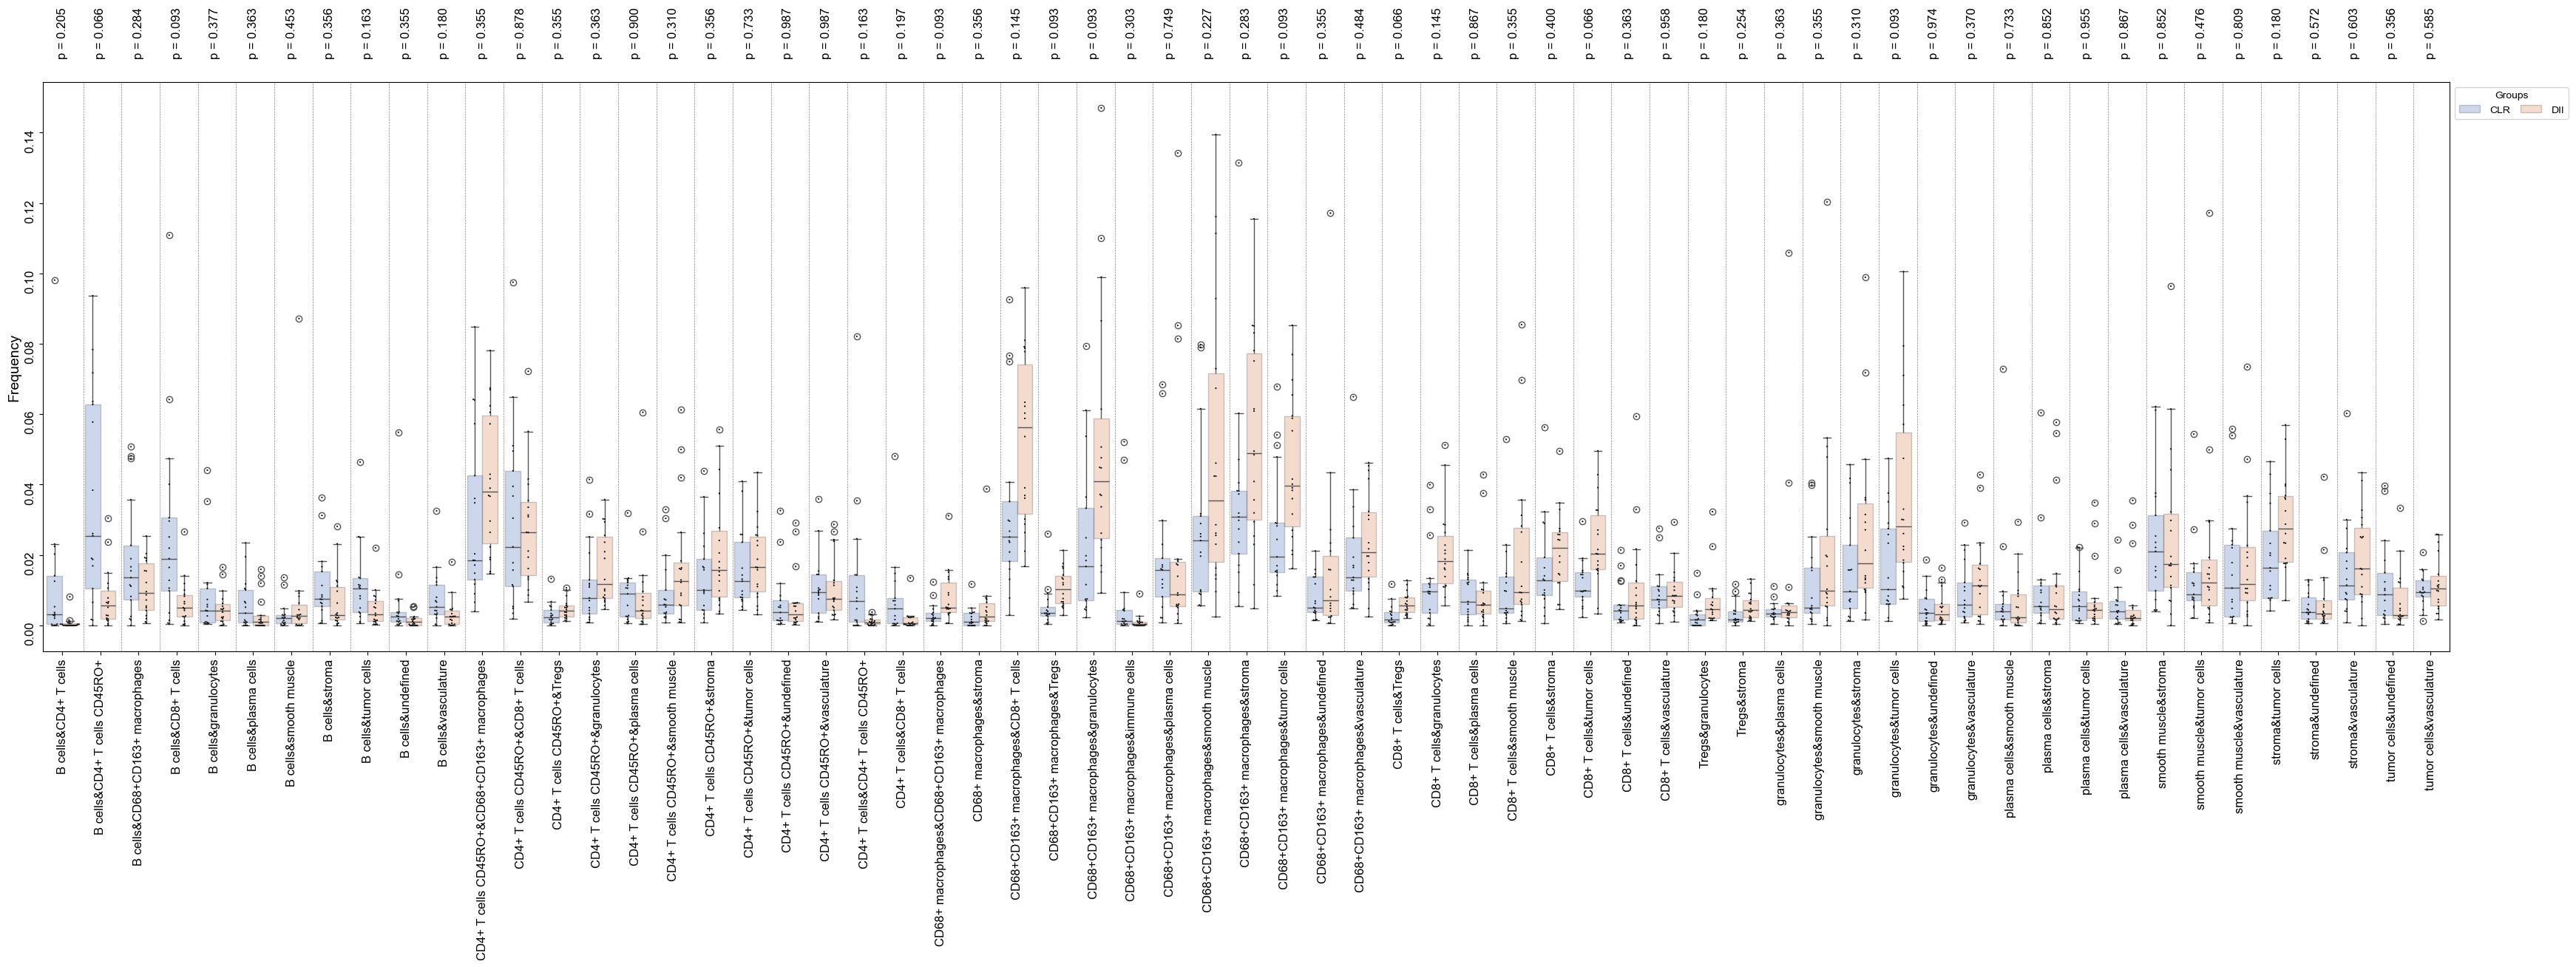

In [24]:
# Melt the DataFrame
grouped_melted = global_comb_df.melt(id_vars=['Patient', 'Condition'], var_name='CellType', value_name='Frequency')

save_path = 'tissue_celltype_comb_freq.svg'
    
selected_cell_types = sorted(grouped_melted['CellType'].unique())
selected_p_values = []

# Perform t-tests
print(f"p-value before correction: ")
for ct in selected_cell_types: # df_melted['CellType'].unique():
    subset = grouped_melted[grouped_melted['CellType'] == ct]
    group1 = subset[subset['Condition'] == 'CLR']['Frequency']
    group2 = subset[subset['Condition'] == 'DII']['Frequency']

    t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=False)
    print(f"{ct} has p value = {p_value:.3f}")
    selected_p_values.append(p_value)

# Filter the dataframe based on selected CellTypes
df_filtered = grouped_melted[grouped_melted['CellType'].isin(selected_cell_types)]

pvals_corrected_list = stats.false_discovery_control(selected_p_values, method='bh')

print('-'*42)
print(f"p-values after correction:")

# Plot the filtered data
fig, ax = plt.subplots(figsize=(42,10))
sns.boxplot(data=df_filtered, x='CellType', y='Frequency', hue='Condition', palette='muted', boxprops=dict(alpha=.3), ax=ax, dodge=True, order=selected_cell_types)
sns.swarmplot(data=df_filtered, x='CellType', y='Frequency', hue='Condition', palette='dark:black', size=1.0, dodge=True, ax=ax, edgecolor='gray', linewidth=0.5, order=selected_cell_types)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], title="Groups", handletextpad=1, columnspacing=1, bbox_to_anchor=(1, 1), ncol=3, frameon=True)

yrange = ax.get_ylim()[1] - ax.get_ylim()[0]
p_vals_corrected_dict = {}
for i, ct in enumerate(selected_cell_types):
    ax.text(i, yrange, f"p = {pvals_corrected_list[i]:.3f}", ha='center', fontsize=12, rotation=90)
    print(f"{ct} has p value = {pvals_corrected_list[i]:.3f}", flush=True)
    # Append to the dictionary
    p_vals_corrected_dict[ct] = pvals_corrected_list[i]
    
for i in range(len(selected_cell_types) - 1):
    ax.axvline(i + 0.55, color='grey', linestyle='--', linewidth=0.5)

ax.set_ylabel("Frequency", fontsize=14)
ax.set_xlabel('')
plt.xticks(fontsize=12, rotation=90)  
plt.yticks(fontsize=12, rotation=90) 
# fig.savefig('../figures/crc/'+save_path)
plt.show()
plt.close(fig)


In [43]:
circoplot_df1 = global_comb_df.drop(columns=['Patient'])
circoplot_df1 = circoplot_df1[[col for col in circoplot_df1.columns if 'undefined' not in col]]
# Group by 'Condition' and calculate the mean of the other columns
circoplot_df1 = circoplot_df1.groupby('Condition').mean().reset_index()
circoplot_df1 = circoplot_df1.set_index('Condition')
circoplot_df1

B cells                                               \
          CD4+ T cells CD4+ T cells CD45RO+ CD68+CD163+ macrophages   
Condition                                                             
CLR           0.012412             0.034873                0.018433   
DII           0.000752             0.007611                0.010686   

                                                                          \
          CD8+ T cells granulocytes plasma cells smooth muscle    stroma   
Condition                                                                  
CLR           0.026145     0.008671     0.006010      0.002917  0.010934   
DII           0.006457     0.004830     0.003341      0.007947  0.006856   

                                   ...  plasma cells                        \
          tumor cells vasculature  ... smooth muscle    stroma tumor cells   
Condition                          ...                                       
CLR          0.011779    0.007876  ...      0.008861  0.010709    0.007356   
DII          0.004796    0.003272  ...      0.006270  0.012660    0.007738   

                      smooth muscle                              stroma  \
          vasculature        stroma tumor cells vasculature tumor cells   
Condition                                                                 
CLR          0.005696      0.023346    0.012941    0.016308    0.020004   
DII          0.006562      0.025861    0.019929    0.018927    0.029355   

                      tumor cells  
          vasculature vasculature  
Condition                          
CLR          0.015639    0.009926  
DII          0.019093    0.011639  

[2 rows x 55 columns]

In [49]:
circoplot_df2 = df_abundance[[col for col in df_abundance.columns if 'undefined' not in col]]
circoplot_df2

ClusterName   B cells  CD11b+ monocytes  CD11b+CD68+ macrophages  CD11c+ DCs  \
groups                                                                         
CLR          0.069471          0.000281                 0.001505    0.001385   
DII          0.016478          0.004673                 0.007303    0.001686   

ClusterName  CD163+ macrophages  CD3+ T cells  CD4+ T cells  \
groups                                                        
CLR                    0.000363      0.000272      0.012074   
DII                    0.000082      0.000911      0.003185   

ClusterName  CD4+ T cells CD45RO+  CD4+ T cells GATA3+  CD68+ macrophages  \
groups                                                                      
CLR                      0.072276             0.000508           0.004358   
DII                      0.065721             0.000022           0.011092   

ClusterName  ...  immune cells  immune cells / vasculature  lymphatics  \
groups       ...                                                         
CLR          ...      0.028854                    0.016573    0.000356   
DII          ...      0.001605                    0.007733    0.001711   

ClusterName    nerves  plasma cells  smooth muscle    stroma  tumor cells  \
groups                                                                      
CLR          0.002579      0.038024       0.104830  0.091609     0.166579   
DII          0.002704      0.029154       0.112189  0.078978     0.189360   

ClusterName  tumor cells / immune cells  vasculature  
groups                                                
CLR                            0.003786     0.054342  
DII                            0.007580     0.042994  

[2 rows x 27 columns]

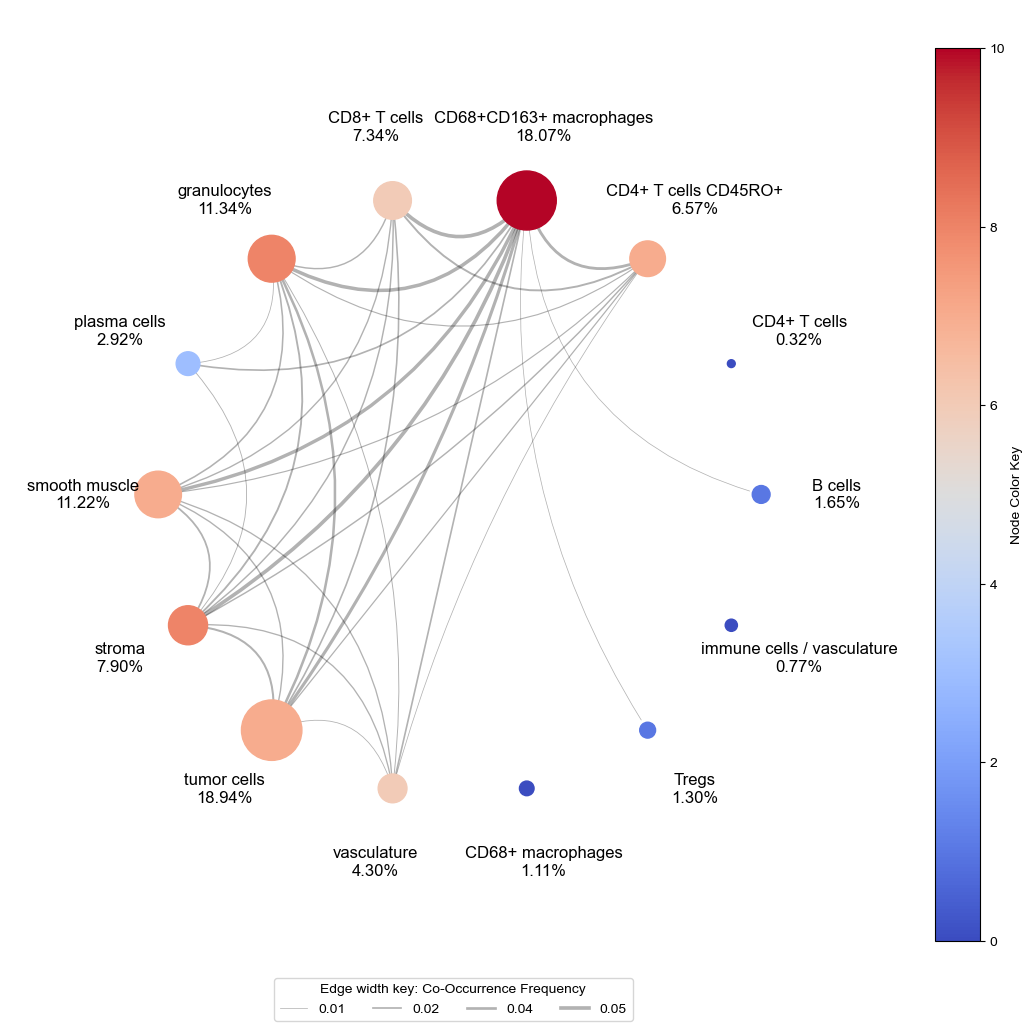

In [51]:
patient_group = 'DII'
cirplot_save_path = '../figures/crc/wholetissue_circleplot_'+ patient_group +'.svg'
msd.create_circos_plot(circoplot_df1.loc[[patient_group]], 
                       cell_type_colors_hex=None,
                       cell_abundance=circoplot_df2.loc[[patient_group]],
                       threshold=0.01, 
                       edge_weights_scaler=50,
                       highlighted_edges=None,
                       node_weights_scaler=10000,
                       figure_size=(10,10),
                       save_path=cirplot_save_path)

# Hot/Cold Spot Cellular analysis

## Calculattion

In [17]:
Hot = True
p_value_cutoff = 0.01
library_names = ['CLR', 'DII'] 

total_merged_series = []
moran_results = {}

comp_results = []
comp_results_patient = []

comb_freq_results = []
comb_freq_results_patient = []

for library, library_name in zip(library_ids, library_names):
    total_comp_dict, global_morans, spot_comb_dict = msd.diversity_clustering(spatial_data=protein, 
                                                                              scale=32.0, 
                                                                              library_key='File Name',
                                                                              library_ids=library, 
                                                                              spatial_key=['X:X','Y:Y'],
                                                                              cluster_key='ClusterName',
                                                                              hotspot=Hot,
                                                                              p_value=p_value_cutoff,
                                                                              top=None,
                                                                              selected_comb=None,
                                                                              restricted=False,
                                                                              metric='Shannon Diversity')
    
    # Concatenate all the merged_series and sum across rows
    total_merged_series.append(total_comp_dict)
    # total_merged_series = pd.concat(total_comp_dict.values(), axis=1).sum(axis=1)
    # comp_results.append(total_merged_series)    
    comb_freq_results.append(spot_comb_dict)
    
    # create a dictionary to store cell composition in hot/cold spots, Moran's I
    comp_patient = pd.DataFrame()
    comb_patient = pd.DataFrame()
    moran_patient = {}
    
    keys = list(total_comp_dict.keys())
    
    for patient, regions in patient_to_region.items():
        # select keys that correspond to the current patient
        selected_keys = [region for region in regions if region in keys]
        print(selected_keys)
        
        if selected_keys:
            # list to store the selected series
            series_list = [total_comp_dict[key] for key in selected_keys]
            moran_list = [global_morans[key] for key in selected_keys]
            comb_series_list = [spot_comb_dict[key] for key in selected_keys]

            # calculate the average
            patient_series = pd.concat(series_list, axis=1).fillna(0)
            patient_comb_series = pd.concat(comb_series_list, axis=1).fillna(0)
            
            average_series = compute_average_frequency(patient_series)
            average_comb_series = patient_comb_series.mean(axis=1) # calculate cell combination freq in hotspots
            # moran_patient.append(np.array(moran_list).max())
            moran_patient[patient] = np.array(moran_list).max()
            
            # store the average in the output DataFrame
            comp_patient = append_series_to_df(comp_patient, average_series, patient)
            comb_patient = append_series_to_df(comb_patient, average_comb_series, patient)
            
    comp_patient = comp_patient.T    
    comp_patient['Condition'] = library_name 
    comp_results_patient.append(comp_patient.fillna(0))
    
    comb_patient = comb_patient.T
    comb_patient['Condition'] = library_name
    comb_freq_results_patient.append(comb_patient.fillna(0))
    
    # Store Moran's I 
    moran_results[library_name] = moran_patient

Processing region: reg001_A at scale 32.0
46.582 per cent patches are empty
Using MoranI
Region reg001_A contains 92 diversity hotspots
Considering only hotspots
Processing region: reg001_B at scale 32.0
75.293 per cent patches are empty
Using MoranI
Region reg001_B contains 5 diversity hotspots
Considering only hotspots
Processing region: reg002_A at scale 32.0
45.996 per cent patches are empty
Using MoranI
Region reg002_A contains 115 diversity hotspots
Considering only hotspots
Processing region: reg002_B at scale 32.0
19.238 per cent patches are empty
Using MoranI
Region reg002_B contains 19 diversity hotspots
Considering only hotspots
Processing region: reg011_A at scale 32.0
30.371 per cent patches are empty
Using MoranI
Region reg011_A contains 134 diversity hotspots
Considering only hotspots
Processing region: reg011_B at scale 32.0
51.562 per cent patches are empty
Using MoranI
Region reg011_B contains 44 diversity hotspots
Considering only hotspots
Processing region: reg012_A

## process and visualise proportion of cells in hot/cold

['reg001_B', 'reg002_A']
[]
[]
[]
[]
['reg011_A', 'reg012_A', 'reg012_B']
[]
[]
[]
['reg019_A', 'reg020_A', 'reg020_B']
['reg021_A', 'reg022_A']
['reg023_B', 'reg024_B']
['reg025_B', 'reg026_A', 'reg026_B']
[]
[]
[]
['reg033_A', 'reg033_B', 'reg034_A', 'reg034_B']
[]
['reg037_A', 'reg038_A', 'reg038_B']
['reg039_A', 'reg039_B', 'reg040_A']
['reg041_A', 'reg041_B', 'reg042_A']
[]
[]
['reg047_A', 'reg048_A', 'reg048_B']
[]
[]
[]
['reg055_A', 'reg055_B', 'reg056_A']
['reg057_A', 'reg057_B', 'reg058_B']
[]
[]
['reg063_B', 'reg064_A', 'reg064_B']
['reg065_B', 'reg066_A']
['reg068_B']
['reg069_A', 'reg069_B', 'reg070_A']
[]
['reg004_A', 'reg004_B']
['reg005_A', 'reg005_B', 'reg006_A', 'reg006_B']
['reg007_A', 'reg007_B', 'reg008_A', 'reg008_B']
['reg009_A', 'reg009_B', 'reg010_A']
[]
['reg013_A', 'reg013_B', 'reg014_B']
['reg015_A', 'reg016_A', 'reg016_B']
['reg017_A', 'reg017_B', 'reg018_A', 'reg018_B']
[]
[]
[]
[]
['reg027_A', 'reg027_B', 'reg028_A', 'reg028_B']
['reg029_A', 'reg029_B', 'r

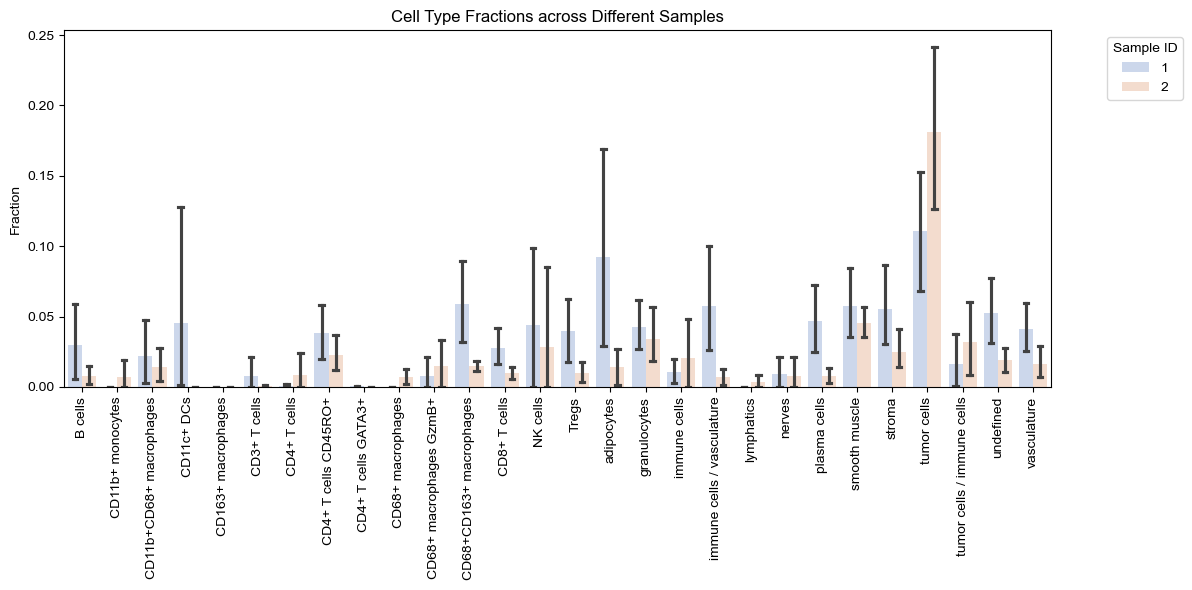

In [116]:
spot_fraction_data = []
condition_counter = 1
for sample_group in total_merged_series:
    keys = list(sample_group.keys())
    for patient, regions in patient_to_region.items():
        # select keys that correspond to the current patient
        selected_keys = [region for region in regions if region in keys]
        print(selected_keys)
        if selected_keys:
            series_list = [sample_group[key] for key in selected_keys]
            patient_series = pd.concat(series_list, axis=1).fillna(0)
            avg_count = patient_series.mean(axis=1)
            
            fraction = (avg_count/global_cell_count.loc[patient]).fillna(0)
            fraction_df = fraction.to_frame(name='fraction')
            fraction_df['sample_id'] = condition_counter
            fraction_df['cell_type'] = fraction_df.index
            spot_fraction_data.append(fraction_df)
        # print(fraction_df)
        # print('-'*42)
    condition_counter += 1
spot_fraction_df = pd.concat(spot_fraction_data)

# Transform DataFrame for plotting
spot_fraction_df_long = spot_fraction_df.melt(id_vars=['sample_id', 'cell_type'], value_vars=['fraction'])

# Create the plot
plt.figure(figsize=(12, 6))
sns.barplot(x='cell_type', y='value', hue='sample_id', 
            data=spot_fraction_df_long, palette='muted', 
            alpha=0.3, capsize=0.25)

# Customize the plot
plt.title('Cell Type Fractions across Different Samples')
plt.xlabel('')
plt.ylabel('Fraction')
plt.xticks(rotation=90)
plt.legend(title='Sample ID', bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.tight_layout()
fig = plt.gcf()
if Hot:
    save_path = 'hotspot_frac.svg'
else:
    save_path = 'coldspot_frac.svg'
fig.savefig('../figures/crc/'+save_path)
plt.show()

## GDCI Boxplots

/var/folders/7g/phdhh_ld3dlbnrst0t60bwzr0000gn/T/ipykernel_48983/643606949.py:15: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.swarmplot(data=data, palette='dark:black', edgecolor='gray', linewidth=0.5, size=5)


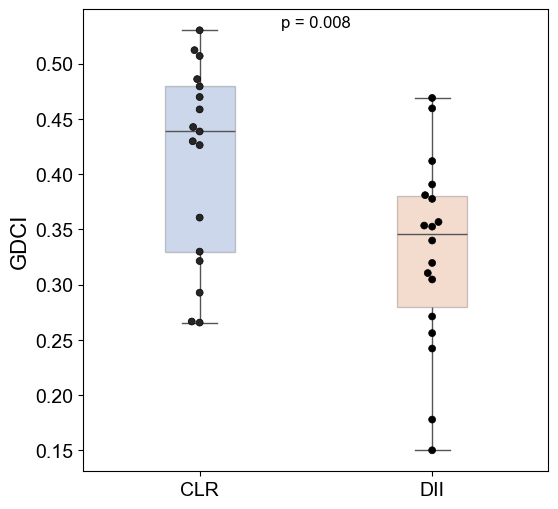

In [14]:
# Extract data for boxplot
clr_data = [v for k, v in moran_results['CLR'].items()]
dii_data = [v for k, v in moran_results['DII'].items()]

# Mann-Whitney U test
stat, p_value = stats.ttest_ind(clr_data, dii_data, nan_policy='omit', equal_var=False)

# Combining data
data = [clr_data, dii_data]
labels = ['CLR', 'DII']

# Plotting
plt.figure(figsize=(6, 6)) 
sns.boxplot(data=data, palette="muted", boxprops=dict(alpha=.3), width=0.3)  # Adjusted width here
sns.swarmplot(data=data, palette='dark:black', edgecolor='gray', linewidth=0.5, size=5)

plt.xticks(range(len(labels)), labels, fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("GDCI", fontsize=16)
# plt.title('Box plot of CLR vs DII', fontsize=18)

# Adding the p-value to the plot
plt.text(0.5, max(np.concatenate((clr_data, dii_data))), f'p = {p_value:.3f}', fontsize=12, horizontalalignment='center', verticalalignment='bottom')
save_path = 'GDCI_'+str(p_value_cutoff)+'.svg'
fig = plt.gcf()
# fig.savefig('../figures/crc/'+save_path)

plt.show()
plt.close(fig)

## process and visualise cell frequency

In [15]:
df1 = comp_results_patient[0]
df2 = comp_results_patient[1]

# get the union of columns
columns = df1.columns.union(df2.columns)
print(len(columns))

# reindex both dataframes with the union of columns, and fill na with 0
df1 = df1.reindex(columns=columns).fillna(0)
df2 = df2.reindex(columns=columns).fillna(0)

29


In [16]:
df_abundance = pd.concat([df1, df2],axis=0)
df_abundance['Patient'] = df_abundance.index
# df_abundance = df_abundance.drop(columns='Patient')

In [ ]:
index_list = clr_data + dii_data
# Initialize dictionaries to store correlation results and lists to store p-values
pearson_correlations = {}
spearman_correlations = {}
pearson_p_values = []
spearman_p_values = []
species_columns = []

# Calculate correlations for each species
for species in df_abundance.columns:
    # Check if the column data type is numeric
    if pd.api.types.is_numeric_dtype(df_abundance[species]):
        species_columns.append(species)
        # Pearson Correlation
        corr, p_value = stats.pearsonr(df_abundance[species], index_list)
        pearson_correlations[species] = (corr, p_value)
        pearson_p_values.append(p_value)
        
        # Spearman Correlation
        corr, p_value = stats.spearmanr(df_abundance[species], index_list)
        spearman_correlations[species] = (corr, p_value)
        spearman_p_values.append(p_value)

# Apply FDR correction (Benjamini-Hochberg)
pearson_corrected_p = stats.false_discovery_control(pearson_p_values, method='bh')
spearman_corrected_p = stats.false_discovery_control(spearman_p_values, method='bh')

# Update the dictionaries with corrected p-values
for i, species in enumerate(species_columns):
    # Check if the column data type is numeric
    if pd.api.types.is_numeric_dtype(df_abundance[species]):
        pearson_correlations[species] = (pearson_correlations[species][0], pearson_corrected_p[i])
        spearman_correlations[species] = (spearman_correlations[species][0], spearman_corrected_p[i])

# Results with corrected p-values
print("Pearson Correlations with FDR Correction:", pearson_correlations)
print("Spearman Correlations with FDR Correction:", spearman_correlations)


In [36]:
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch

In [37]:
sns.color_palette("muted", 10)

[(0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
 (0.41568627450980394, 0.8, 0.39215686274509803),
 (0.8392156862745098, 0.37254901960784315, 0.37254901960784315),
 (0.5843137254901961, 0.4235294117647059, 0.7058823529411765),
 (0.5490196078431373, 0.3803921568627451, 0.23529411764705882),
 (0.8627450980392157, 0.49411764705882355, 0.7529411764705882),
 (0.4745098039215686, 0.4745098039215686, 0.4745098039215686),
 (0.8352941176470589, 0.7333333333333333, 0.403921568627451),
 (0.5098039215686274, 0.7764705882352941, 0.8862745098039215)]

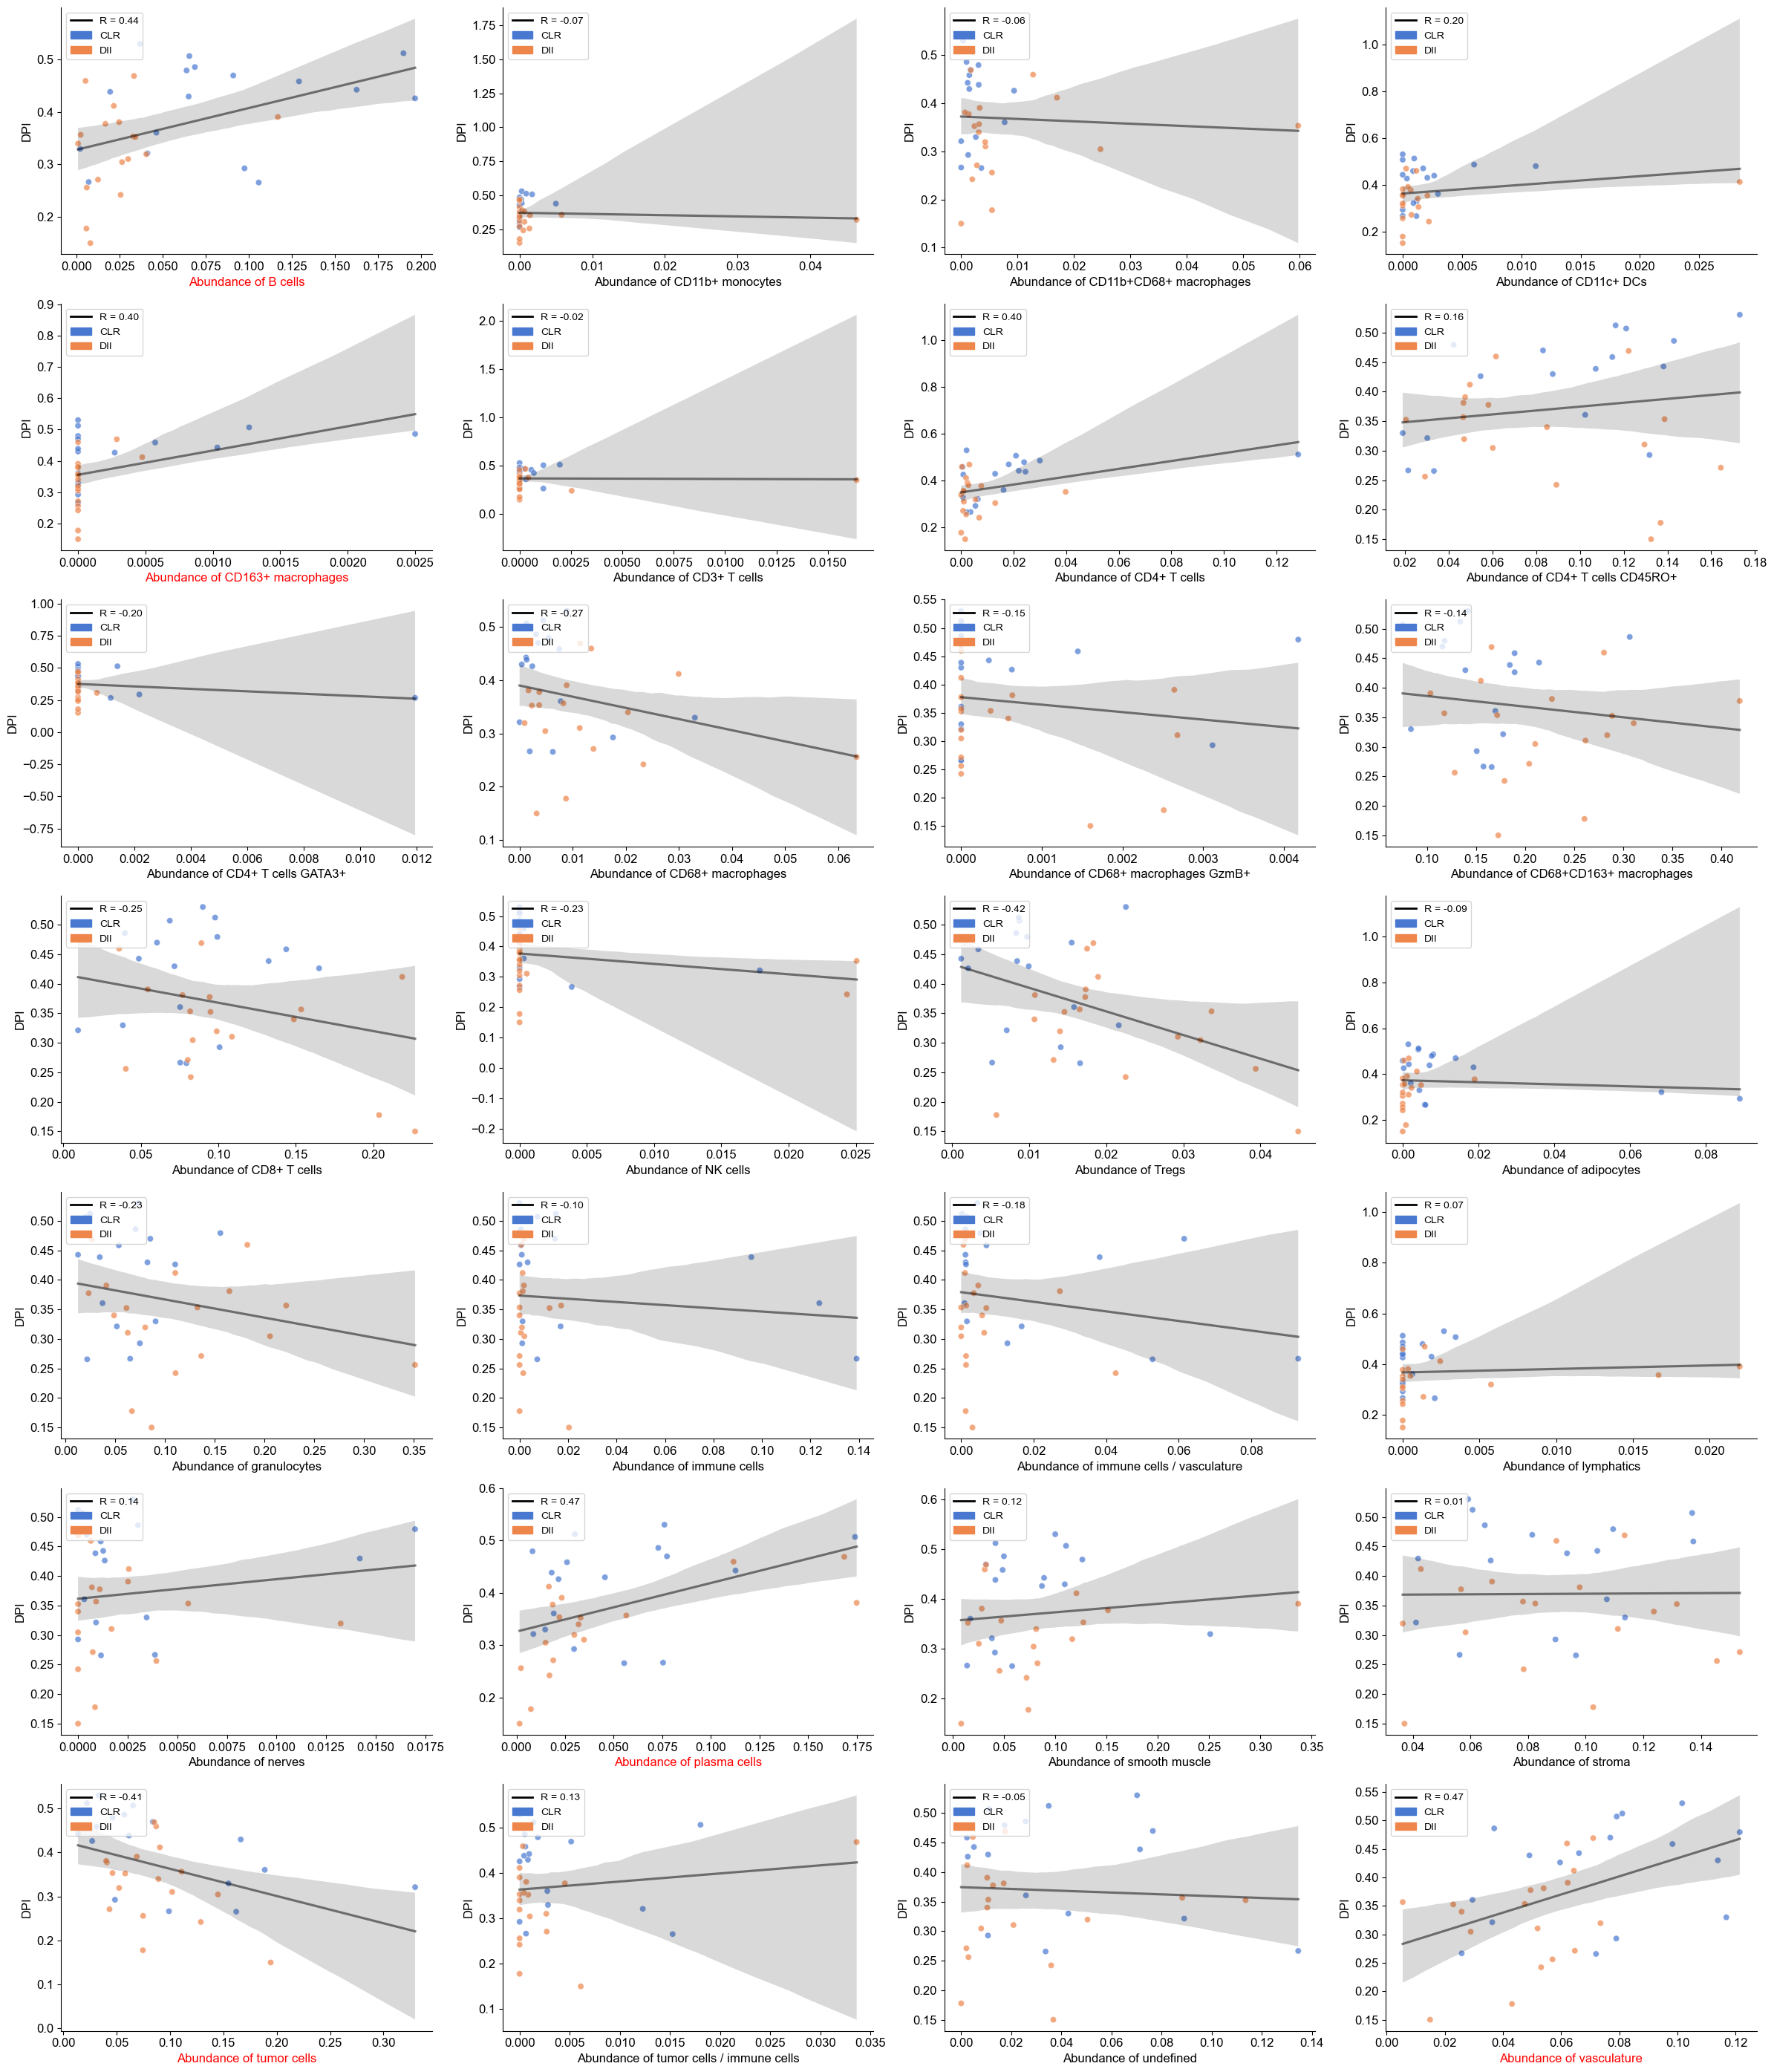

In [44]:
significant_species = [species for species, corr in spearman_correlations.items() if corr[1] < 0.05]
all_species = [species for species, corr in spearman_correlations.items()]

# Calculate the number of rows and columns for the subplots
n_species = len(all_species)
n_cols = 4  # You can adjust this number based on your preference
n_rows = (n_species + n_cols - 1) // n_cols  # Rounds up to ensure all plots fit

plt.figure(figsize=(n_cols * 6, n_rows * 4))  # Adjust the figure size as needed

for i, species in enumerate(all_species):
    ax = plt.subplot(n_rows, n_cols, i + 1)
    
    # Data for plotting
    x = df_abundance[species]
    y = index_list
    hue = df_abundance['Condition']
    
    # Plot data points
    diverging_colors = sns.color_palette("muted", 10)
    extreme_colors = [diverging_colors[0], diverging_colors[1]]
    sns.scatterplot(x=x, y=y, hue=hue, palette=extreme_colors, ax=ax, alpha=0.7)

    # Fit and plot linear regression line with a confidence band
    sns.regplot(x=x, y=y, ci=95, scatter=False, line_kws={'color': 'black', 'alpha':0.5}, ax=ax)

    # Get the correlation coefficient
    corr_coef = pearson_correlations[species][0]
    
    sns.despine()
    xlabel_color = 'red' if species in significant_species else 'black'
    ax.set_xlabel(f'Abundance of {species}', fontsize=12, color=xlabel_color)
    ax.set_ylabel('DPI', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    # Custom legend
    legend_elements = [Line2D([0], [0], color='black', lw=2, label=f'R = {corr_coef:.2f}')]
    unique_conditions = df_abundance['Condition'].unique()
    for color, condition in zip(extreme_colors, unique_conditions):
        legend_elements.append(mpatches.Circle((0, 0), 0.1, facecolor=color, edgecolor=color, label=condition))

    ax.legend(handles=legend_elements, loc='upper left', handler_map={mpatches.Circle: HandlerPatch()})

plt.tight_layout()  # Adjusts the plots to fit into the figure area.
plt.savefig('../figures/crc/correlation_plots.svg')
plt.show()


In [17]:
df_melted = df_abundance.melt(id_vars=['Patient', 'Condition'], var_name='CellType', value_name='Frequency')
# df_melted = df_melted[~df_melted['CellType'].str.contains('dirt')]
# df_melted = df_melted[~df_melted['CellType'].str.contains('undefined')]

In [18]:
df_melted

Patient Condition     CellType  Frequency
0          1       CLR      B cells   0.066507
1          6       CLR      B cells   0.067344
2         10       CLR      B cells   0.040293
3         11       CLR      B cells   0.179551
4         12       CLR      B cells   0.042138
..       ...       ...          ...        ...
975       25       DII  vasculature   0.052270
976       26       DII  vasculature   0.016869
977       27       DII  vasculature   0.005100
978       30       DII  vasculature   0.044733
979       31       DII  vasculature   0.081557

[980 rows x 4 columns]

p-value before correction: 
B cells has p value = 0.001
CD11b+ monocytes has p value = 0.475
CD11b+CD68+ macrophages has p value = 0.056
CD11c+ DCs has p value = 0.657
CD163+ macrophages has p value = 0.190
CD3+ T cells has p value = 0.434
CD4+ T cells has p value = 0.044
CD4+ T cells CD45RO+ has p value = 0.807
CD4+ T cells GATA3+ has p value = 0.105
CD68+ macrophages has p value = 0.187
CD68+ macrophages GzmB+ has p value = 0.403
CD68+CD163+ macrophages has p value = 0.010
CD8+ T cells has p value = 0.070
NK cells has p value = 0.551
Tregs has p value = 0.012
adipocytes has p value = 0.147
granulocytes has p value = 0.026
immune cells has p value = 0.078
immune cells / vasculature has p value = 0.201
lymphatics has p value = 0.195
nerves has p value = 0.904
plasma cells has p value = 0.344
smooth muscle has p value = 0.838
stroma has p value = 0.515
tumor cells has p value = 0.757
tumor cells / immune cells has p value = 0.290
undefined has p value = 0.443
vasculature has p value = 0

/var/folders/7g/phdhh_ld3dlbnrst0t60bwzr0000gn/T/ipykernel_48983/3664513736.py:26: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.swarmplot(data=df_filtered, x='CellType', y='Frequency', hue='Condition', palette='dark:black', size=2.0, dodge=True, ax=ax, edgecolor='gray', linewidth=0.5,order = selected_cell_types)
/opt/miniconda3/envs/mesa/lib/python3.11/site-packages/seaborn/categorical.py:3370: UserWarning: 11.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/mesa/lib/python3.11/site-packages/seaborn/categorical.py:3370: UserWarning: 5.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/mesa/lib/python3.11/site-packages/seaborn/categorical.py:3370: UserWarning: 16.7% of the points cannot be plac

------------------------------------------
p-values after correction: 
B cells has p value = 0.030
CD11b+ monocytes has p value = 0.634
CD11b+CD68+ macrophages has p value = 0.225
CD11c+ DCs has p value = 0.767
CD163+ macrophages has p value = 0.376
CD3+ T cells has p value = 0.620
CD4+ T cells has p value = 0.204
CD4+ T cells CD45RO+ has p value = 0.869
CD4+ T cells GATA3+ has p value = 0.294
CD68+ macrophages has p value = 0.376
CD68+ macrophages GzmB+ has p value = 0.620
CD68+CD163+ macrophages has p value = 0.085
CD8+ T cells has p value = 0.242
NK cells has p value = 0.670
Tregs has p value = 0.085
adipocytes has p value = 0.374
granulocytes has p value = 0.145
immune cells has p value = 0.242
immune cells / vasculature has p value = 0.376
lymphatics has p value = 0.376
nerves has p value = 0.904
plasma cells has p value = 0.567
smooth muscle has p value = 0.869
stroma has p value = 0.656
tumor cells has p value = 0.847
tumor cells / immune cells has p value = 0.507
undefined has 

/opt/miniconda3/envs/mesa/lib/python3.11/site-packages/seaborn/categorical.py:3370: UserWarning: 11.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


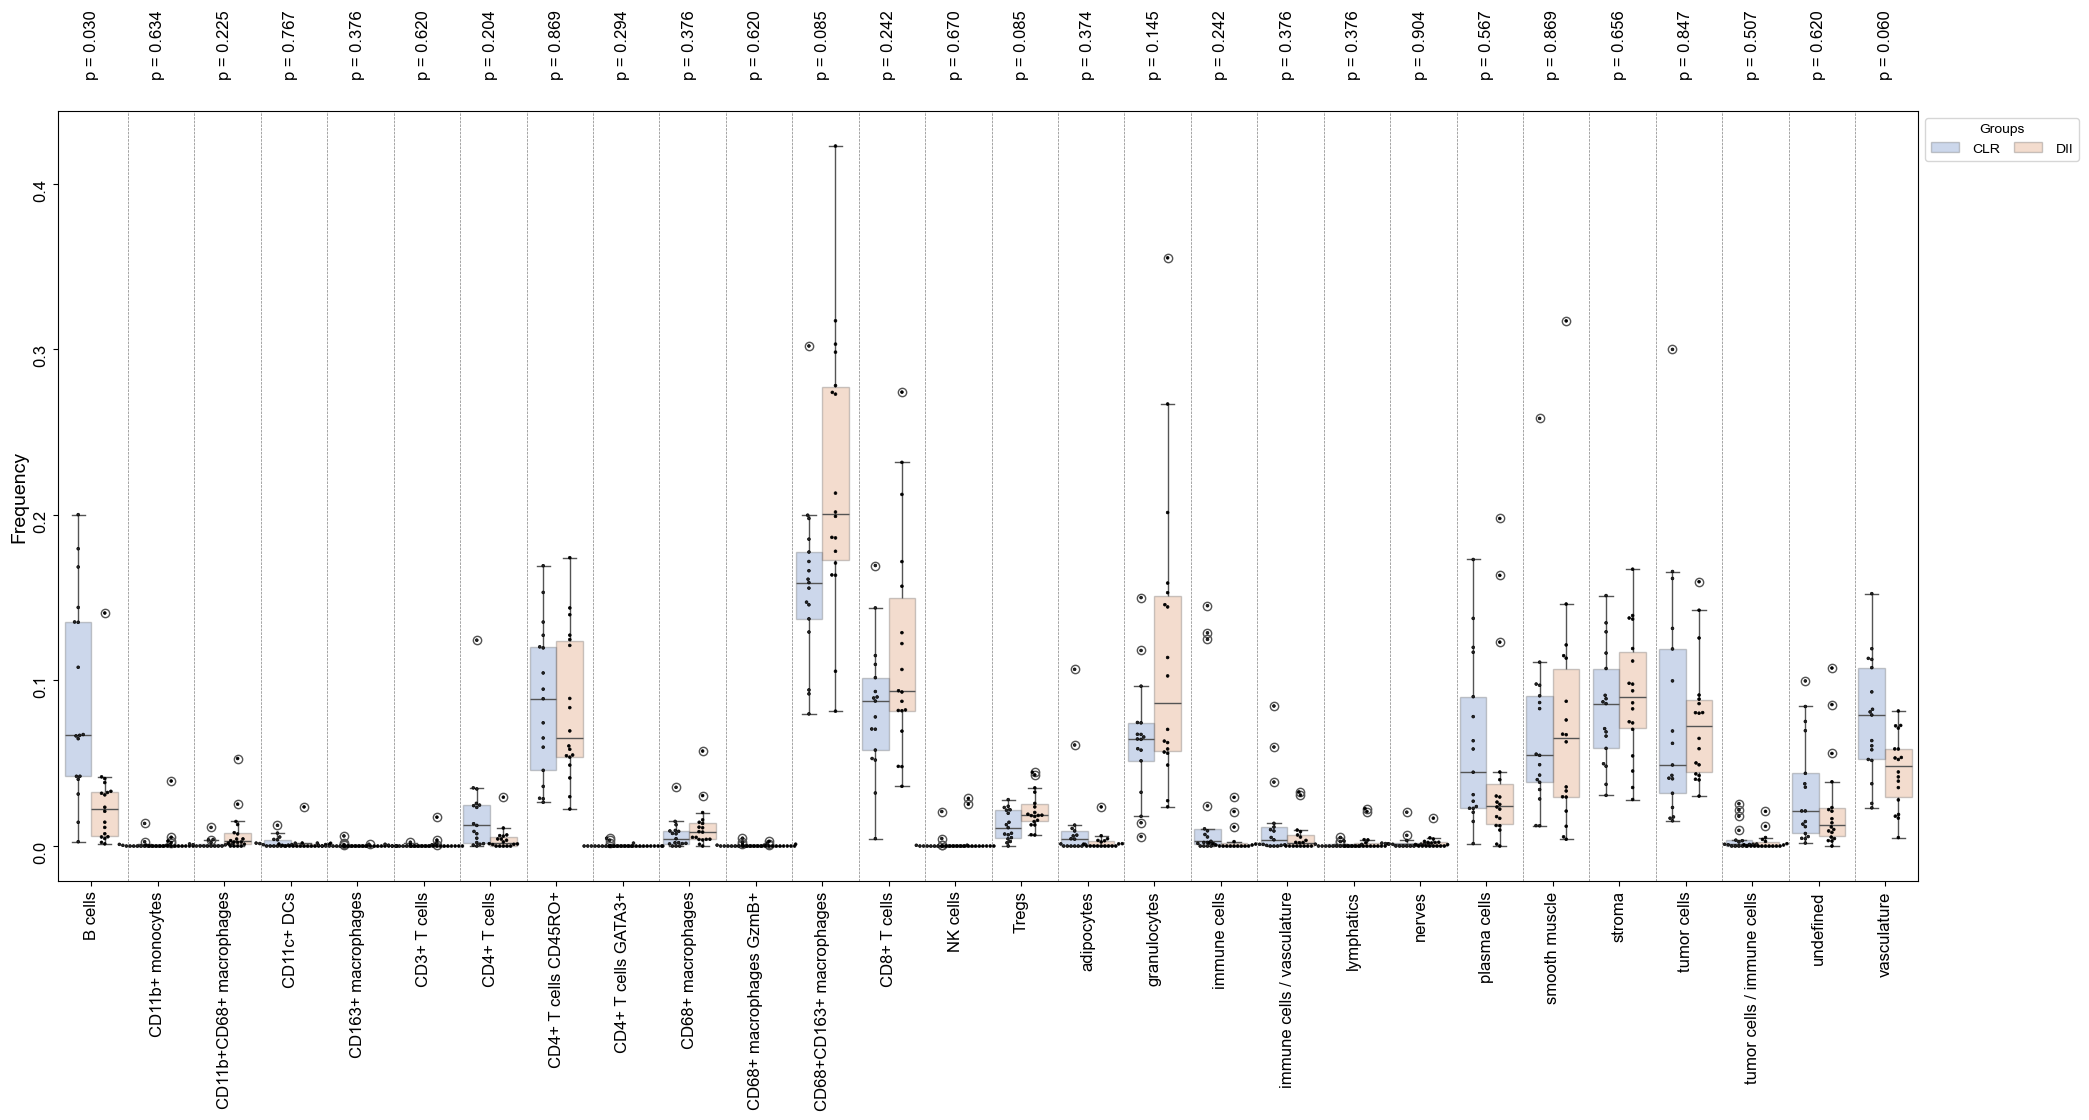

In [19]:
cluster_key = 'ClusterName'
if Hot:
    save_path = 'hotspot_'+cluster_key.split(' ')[0]+'_freq.svg'
else:
    save_path = 'coldspot_'+cluster_key.split(' ')[0]+'_freq.svg'
    
selected_cell_types = sorted(df_melted['CellType'].unique())
selected_p_values = []

# Perform t-tests
print(f"p-value before correction: ")
for ct in selected_cell_types: # df_melted['CellType'].unique():
    subset = df_melted[df_melted['CellType'] == ct]
    group1 = subset[subset['Condition'] == 'CLR']['Frequency']
    group2 = subset[subset['Condition'] == 'DII']['Frequency']
    t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=False)
    print(f"{ct} has p value = {p_value:.3f}")
    selected_p_values.append(p_value)

# Filter the dataframe based on selected CellTypes
df_filtered = df_melted[df_melted['CellType'].isin(selected_cell_types)]

# Plot the filtered data
fig, ax = plt.subplots(figsize=(24,10))
sns.boxplot(data=df_filtered, x='CellType', y='Frequency', hue='Condition', palette='muted', boxprops=dict(alpha=.3), ax=ax, dodge=True, order = selected_cell_types)
sns.swarmplot(data=df_filtered, x='CellType', y='Frequency', hue='Condition', palette='dark:black', size=2.0, dodge=True, ax=ax, edgecolor='gray', linewidth=0.5,order = selected_cell_types)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], title="Groups", handletextpad=1, columnspacing=1, bbox_to_anchor=(1, 1), ncol=3, frameon=True)

hot_pvals_corrected = stats.false_discovery_control(selected_p_values, method='bh')

print('-'*42)
print(f"p-values after correction: ")

yrange = ax.get_ylim()[1] - ax.get_ylim()[0]
for i, ct in enumerate(selected_cell_types):
    ax.text(i, yrange, f"p = {hot_pvals_corrected[i]:.3f}", ha='center', fontsize=12, rotation=90)
    print(f"{ct} has p value = {hot_pvals_corrected[i]:.3f}", flush=True)
    
for i in range(len(selected_cell_types) - 1):
    ax.axvline(i + 0.55, color='grey', linestyle='--', linewidth=0.5)

ax.set_ylabel("Frequency", fontsize=14)
ax.set_xlabel('')
plt.xticks(fontsize=12, rotation=90)  
plt.yticks(fontsize=12, rotation=90) 
# fig.savefig('../figures/crc/'+save_path)
plt.show()
plt.close(fig)


/var/folders/7g/phdhh_ld3dlbnrst0t60bwzr0000gn/T/ipykernel_48983/1568914619.py:25: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.swarmplot(data=combined_df[combined_df['ClusterName'] == ct],


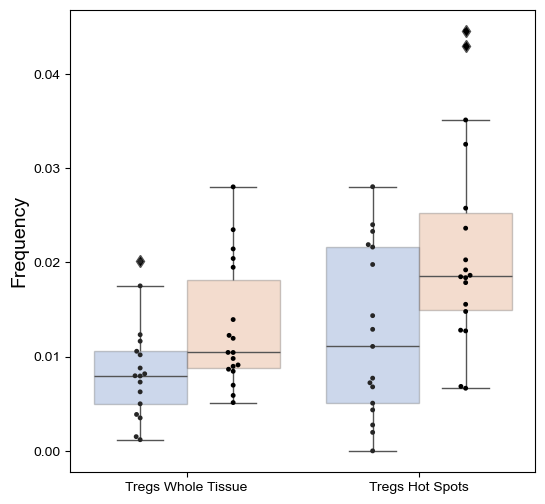

In [47]:
ct = 'Tregs'
# Add a source column to each dataframe
filtered_data['source'] = 'Whole Tissue'
df_melted['source'] = 'Hot Spots'

# Reversing the mapping
reverse_map = {value: key for key, value in patient_condition.items()}
filtered_data['groups'] = filtered_data['groups'].replace(reverse_map)

# Standardize the column names
df_melted.rename(columns={'CellType': 'ClusterName', 'Condition': 'groups'}, inplace=True)

# Combine the dataframes
combined_df = pd.concat([filtered_data, df_melted], ignore_index=True)
combined_df['combined_x'] = combined_df['ClusterName'] + ' ' + combined_df['source']

fig, ax = plt.subplots(figsize=(6,6))

sns.boxplot(data=combined_df[combined_df['ClusterName'] == ct], 
            x='combined_x', y='Frequency', 
            hue='groups', palette='muted', boxprops=dict(alpha=.3), 
            ax=ax, dodge=True,
            flierprops={'marker': 'd',
                        'markerfacecolor': 'black'})
sns.swarmplot(data=combined_df[combined_df['ClusterName'] == ct], 
              x='combined_x', y='Frequency', 
              hue='groups', palette='dark:black', size=3.5, 
              dodge=True, ax=ax, edgecolor='gray')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:len(set(combined_df['groups']))], labels[:len(set(combined_df['groups']))], title="Groups", handletextpad=1, columnspacing=1, bbox_to_anchor=(1, 1), ncol=3, frameon=True)
ax.set_ylabel("Frequency", fontsize=14)
ax.set_xlabel('')
plt.legend().set_visible(False)
save_path = save_path = ct.replace(' ', '_').replace('/', '')+ '_pvalue' + str(p_value_cutoff) + '.svg'
fig.savefig('../figures/crc/'+save_path)


## process and visualise cell co-occurence

In [18]:
spot_df1 = comb_freq_results_patient[0]
spot_df2 = comb_freq_results_patient[1]

# get the union of columns
columns = spot_df1.columns.union(spot_df2.columns)
print(len(columns))

# reindex both dataframes with the union of columns, and fill na with 0
spot_df1 = spot_df1.reindex(columns=columns).fillna(0)
spot_df2 = spot_df2.reindex(columns=columns).fillna(0)

286


In [19]:
temp = pd.concat([spot_df1, spot_df2],axis=0)
temp = temp.sort_index(axis=1) 
condition_col = temp['Condition']
temp = temp.drop(columns='Condition')

spot_comb_df = temp.loc[:, (temp[temp.columns.difference([('Condition','')])].mean() > 0.01)].copy()
spot_comb_df['Condition'] = condition_col
spot_comb_df['Patient'] = spot_comb_df.index
spot_comb_df.sort_index(axis=1,inplace=True)

In [20]:
spot_subset_cols = spot_comb_df.columns
print(len(spot_subset_cols))

65


In [25]:
spot_comb_df = pd.concat([spot_df1, spot_df2],axis=0)
spot_comb_df['Patient'] = spot_comb_df.index
spot_comb_df = spot_comb_df.reindex(columns=union_cols)
spot_comb_df = spot_comb_df.sort_index(axis=1)

/var/folders/7g/phdhh_ld3dlbnrst0t60bwzr0000gn/T/ipykernel_83660/4250476945.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  spot_comb_df['Patient'] = spot_comb_df.index


In [ ]:
count = calculate_interactions(df)
sorted_count = {k: v for k, v in sorted(count.items(), key=lambda item: item[1],reverse=True)}
print(sorted_count)

In [26]:
# Multi-index to single-index column
new_columns = []
for col in spot_comb_df.columns:
    if isinstance(col, tuple):  # This checks if the column is a MultiIndex
        # Join only if the column name is not 'Mouse' or 'Condition'
        if "Patient" not in col and "Condition" not in col:
            new_columns.append('&'.join(map(str, col)).strip())
        else:
            # If 'Mouse' or 'Condition' is in the column, it is not joined with '&'
            new_columns.append(col[0])
    else:
        new_columns.append(col)
spot_comb_df.columns = new_columns


In [27]:
cols_aggregate = [col for col in spot_comb_df.columns if 'Tregs' in col and 'macrophages' in col]
cols_aggregate

['CD68+CD163+ macrophages&Tregs']

p-value before correction: 
B cells&CD4+ T cells has p value = 0.0322
B cells&CD4+ T cells CD45RO+ has p value = 0.0012
B cells&CD68+CD163+ macrophages has p value = 0.0403
B cells&CD8+ T cells has p value = 0.0030
B cells&granulocytes has p value = 0.1030
B cells&plasma cells has p value = 0.1007
B cells&smooth muscle has p value = 0.2983
B cells&stroma has p value = 0.0661
B cells&tumor cells has p value = 0.0205
B cells&undefined has p value = 0.1066
B cells&vasculature has p value = 0.0248
CD4+ T cells CD45RO+&CD68+CD163+ macrophages has p value = 0.1316
CD4+ T cells CD45RO+&CD8+ T cells has p value = 0.7749
CD4+ T cells CD45RO+&Tregs has p value = 0.1220
CD4+ T cells CD45RO+&granulocytes has p value = 0.0789
CD4+ T cells CD45RO+&plasma cells has p value = 0.6985
CD4+ T cells CD45RO+&smooth muscle has p value = 0.0126
CD4+ T cells CD45RO+&stroma has p value = 0.1704
CD4+ T cells CD45RO+&tumor cells has p value = 0.4336
CD4+ T cells CD45RO+&undefined has p value = 0.9255
CD4+ T cell

/var/folders/7g/phdhh_ld3dlbnrst0t60bwzr0000gn/T/ipykernel_83660/777965328.py:33: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.swarmplot(data=df_filtered, x='CellType', y='Frequency', hue='Condition', palette='dark:black', size=1.0, dodge=True, ax=ax, edgecolor='gray', linewidth=0.5, order=selected_cell_types)


B cells&CD4+ T cells CD45RO+ in hot spots has p value = 0.024
B cells&CD4+ T cells CD45RO+ in whole tissue has p value = 0.066
******************************************
B cells&CD8+ T cells in hot spots has p value = 0.046
B cells&CD8+ T cells in whole tissue has p value = 0.093
******************************************
CD68+CD163+ macrophages&Tregs in hot spots has p value = 0.024
CD68+CD163+ macrophages&Tregs in whole tissue has p value = 0.093
******************************************
CD68+CD163+ macrophages&granulocytes in hot spots has p value = 0.046
CD68+CD163+ macrophages&granulocytes in whole tissue has p value = 0.093
******************************************
CD8+ T cells&Tregs in hot spots has p value = 0.024
CD8+ T cells&Tregs in whole tissue has p value = 0.066
******************************************
CD8+ T cells&tumor cells in hot spots has p value = 0.046
CD8+ T cells&tumor cells in whole tissue has p value = 0.066
******************************************


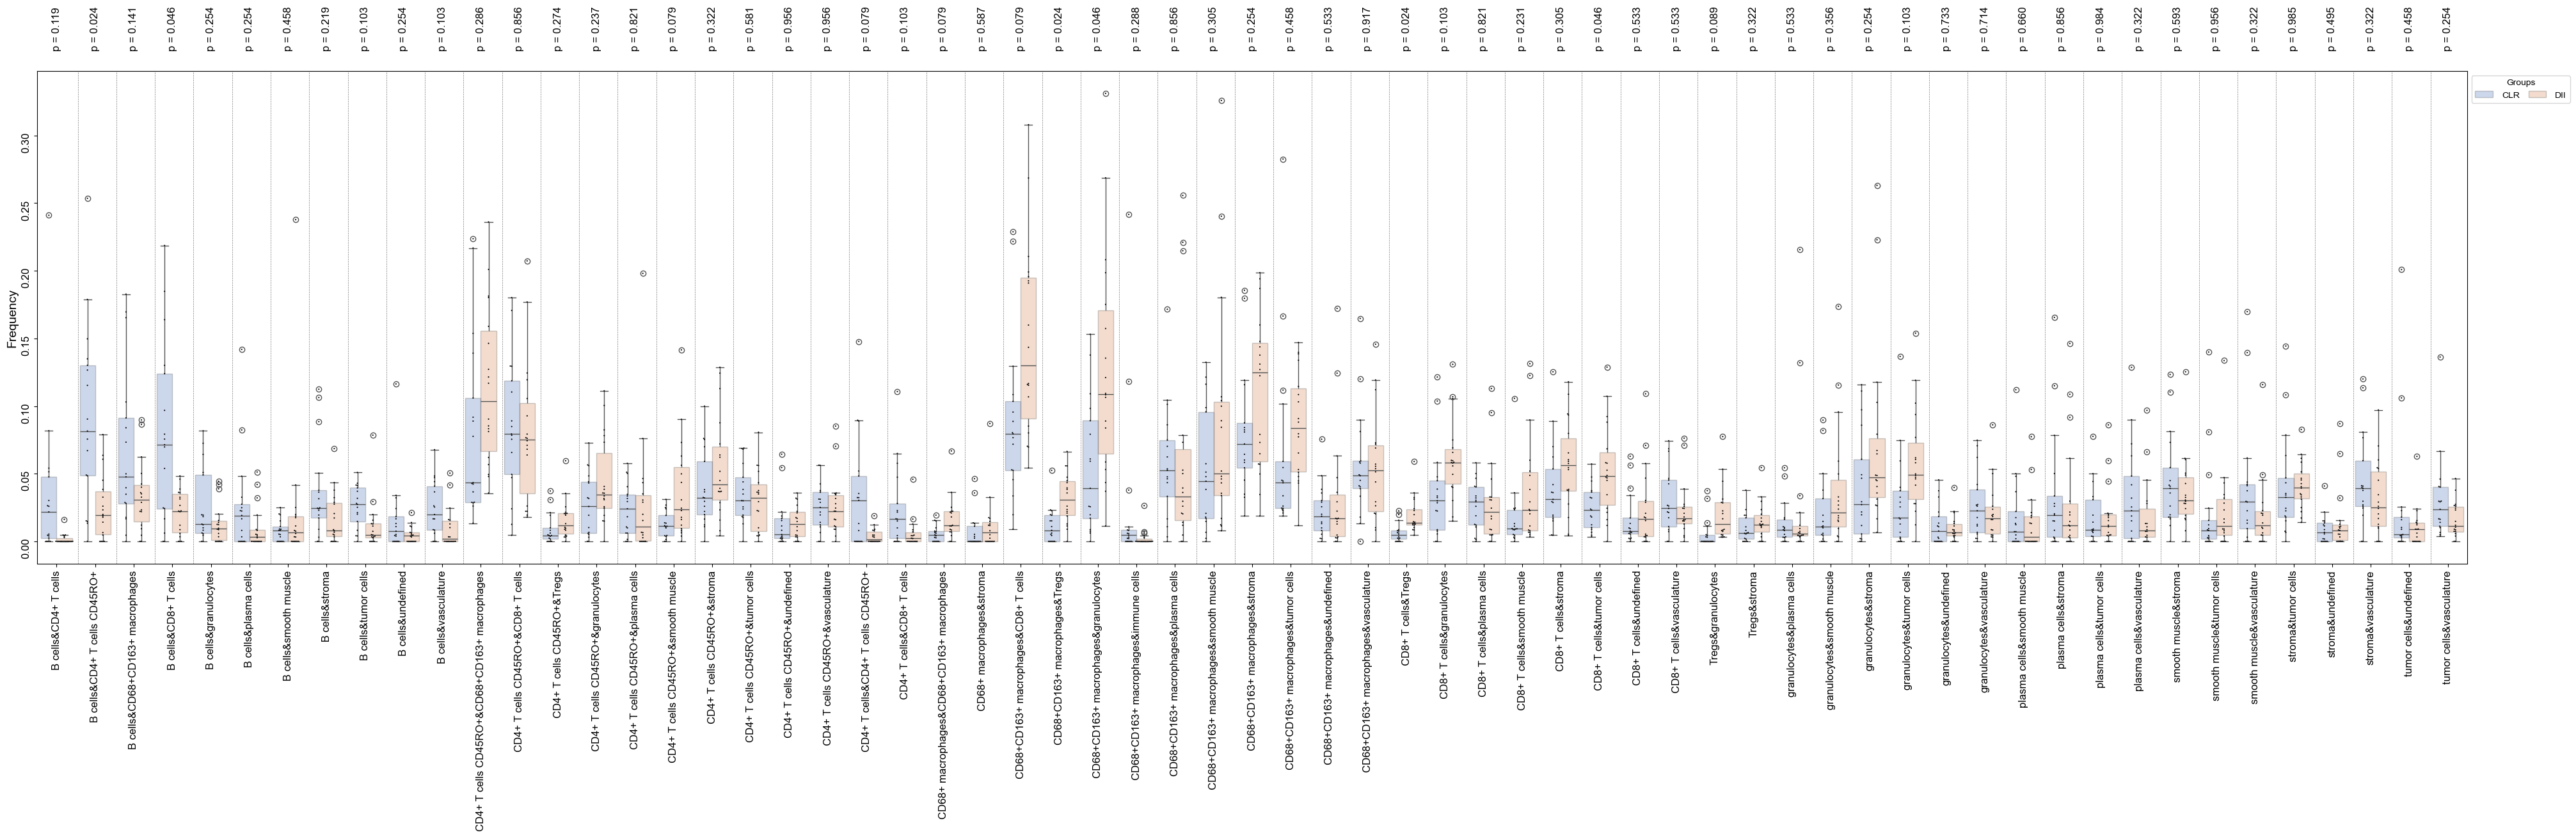

In [28]:
df_melted = spot_comb_df.melt(id_vars=['Patient', 'Condition'], var_name='CellType', value_name='Frequency')

if Hot:
    save_path = 'hotspot_celltype_comb_freq.svg'
else:
    save_path = 'coldspot_celltype_comb_freq.svg'
    
selected_cell_types = sorted(df_melted['CellType'].unique())
selected_p_values = []

# Perform t-tests
print(f"p-value before correction: ")
for ct in selected_cell_types: # df_melted['CellType'].unique():
    subset = df_melted[df_melted['CellType'] == ct]
    group1 = subset[subset['Condition'] == 'CLR']['Frequency']
    group2 = subset[subset['Condition'] == 'DII']['Frequency']

    t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=False)
    print(f"{ct} has p value = {p_value:.4f}")
    selected_p_values.append(p_value)

# Filter the dataframe based on selected CellTypes
df_filtered = df_melted[df_melted['CellType'].isin(selected_cell_types)]

hot_pvals_corrected_list = stats.false_discovery_control(selected_p_values, method='bh')

print('-'*42)
print(f"p-values after correction:")

# Plot the filtered data
fig, ax = plt.subplots(figsize=(49,10))
sns.boxplot(data=df_filtered, x='CellType', y='Frequency', hue='Condition', palette='muted', boxprops=dict(alpha=.3), ax=ax, dodge=True, order=selected_cell_types)
sns.swarmplot(data=df_filtered, x='CellType', y='Frequency', hue='Condition', palette='dark:black', size=1.0, dodge=True, ax=ax, edgecolor='gray', linewidth=0.5, order=selected_cell_types)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], title="Groups", handletextpad=1, columnspacing=1, bbox_to_anchor=(1, 1), ncol=3, frameon=True)

highlighted_comb = []
yrange = ax.get_ylim()[1] - ax.get_ylim()[0]
for i, ct in enumerate(selected_cell_types):
    ax.text(i, yrange, f"p = {hot_pvals_corrected_list[i]:.3f}", ha='center', fontsize=12, rotation=90)
    if hot_pvals_corrected_list[i] < 0.05 and p_vals_corrected_dict[ct] >= 0.05:
        highlighted_comb.append(tuple(map(str.strip, ct.split('&'))))
        print(f"{ct} in hot spots has p value = {hot_pvals_corrected_list[i]:.3f}", flush=True)
        print(f"{ct} in whole tissue has p value = {p_vals_corrected_dict[ct]:.3f}", flush=True)
        print('*'*42)

for i in range(len(selected_cell_types) - 1):
    ax.axvline(i + 0.55, color='grey', linestyle='--', linewidth=0.5)

ax.set_ylabel("Frequency", fontsize=14)
ax.set_xlabel('')
plt.xticks(fontsize=12, rotation=90)  
plt.yticks(fontsize=12, rotation=90)

#fig.savefig('../figures/crc/'+save_path)
plt.show()
plt.close(fig)


/var/folders/7g/phdhh_ld3dlbnrst0t60bwzr0000gn/T/ipykernel_83660/2684297209.py:18: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.swarmplot(data=combined_df[combined_df['CellType'] == ct],
/var/folders/7g/phdhh_ld3dlbnrst0t60bwzr0000gn/T/ipykernel_83660/2684297209.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Whole Tissue','Hot Spots'], fontsize=12)


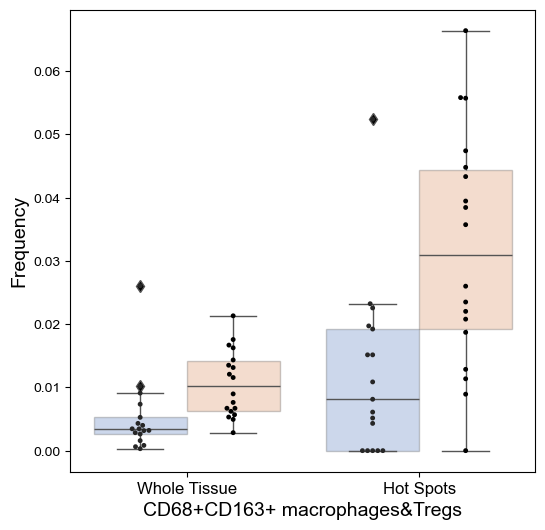

In [33]:
ct = 'CD68+CD163+ macrophages&Tregs'
# Add a source column to each dataframe
grouped_melted['source'] = 'Whole Tissue'
df_melted['source'] = 'Hot Spots'

# Combine the dataframes
combined_df = pd.concat([grouped_melted, df_melted], ignore_index=True)
combined_df['combined_x'] = combined_df['CellType'] + ' ' + combined_df['source']

fig, ax = plt.subplots(figsize=(6,6))

sns.boxplot(data=combined_df[combined_df['CellType'] == ct], 
            x='combined_x', y='Frequency', 
            hue='Condition', palette='muted', boxprops=dict(alpha=.3), 
            ax=ax, dodge=True,
            flierprops={'marker': 'd',
                        'markerfacecolor': 'black'})
sns.swarmplot(data=combined_df[combined_df['CellType'] == ct], 
              x='combined_x', y='Frequency', 
              hue='Condition', palette='dark:black', 
              size=3.5, dodge=True, ax=ax, edgecolor='gray')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:len(set(combined_df['Condition']))], labels[:len(set(combined_df['Condition']))], title="Condition", handletextpad=1, columnspacing=1, bbox_to_anchor=(1, 1), ncol=3, frameon=True)

# Set new x-tick labels
ax.set_xticklabels(['Whole Tissue','Hot Spots'], fontsize=12)

ax.set_ylabel("Frequency", fontsize=14)
ax.set_xlabel(ct, fontsize=14)
plt.legend().set_visible(False)
save_path = save_path = ct.replace(' ', '_').replace('/', '')+ '_pvalue' + str(p_value_cutoff) +'.svg'
fig.savefig('../figures/crc/'+save_path)

In [32]:
circoplot_df1 = spot_comb_df.drop(columns=['Patient'])
circoplot_df1 = circoplot_df1[[col for col in circoplot_df1.columns if 'undefined' not in col]]
# Group by 'Condition' and calculate the mean of the other columns
circoplot_df1 = circoplot_df1.groupby('Condition').mean().reset_index()
circoplot_df1 = circoplot_df1.set_index('Condition')
circoplot_df1

B cells                                               \
          CD4+ T cells CD4+ T cells CD45RO+ CD68+CD163+ macrophages   
Condition                                                             
CLR           0.030836             0.082473                0.053495   
DII           0.001966             0.021029                0.028975   

                                                                          \
          CD8+ T cells granulocytes plasma cells smooth muscle    stroma   
Condition                                                                  
CLR           0.070047      0.02339     0.018846      0.005969  0.031173   
DII           0.019392      0.01260     0.009318      0.019134  0.017789   

                                   ...  plasma cells                        \
          tumor cells vasculature  ... smooth muscle    stroma tumor cells   
Condition                          ...                                       
CLR          0.022648    0.021007  ...      0.018042  0.027469    0.018710   
DII          0.011128    0.009328  ...      0.012115  0.027212    0.016143   

                      smooth muscle                              stroma  \
          vasculature        stroma tumor cells vasculature tumor cells   
Condition                                                                 
CLR          0.024414      0.044725    0.027017    0.037884    0.040794   
DII          0.016061      0.040573    0.026234    0.025014    0.043912   

                      tumor cells  
          vasculature vasculature  
Condition                          
CLR          0.040472    0.035773  
DII          0.032286    0.018287  

[2 rows x 55 columns]

In [36]:
circoplot_df2 = df_abundance.drop(columns=['Patient'])
circoplot_df2 = circoplot_df2[[col for col in circoplot_df2.columns if 'undefined' not in col]]
# Group by 'Condition' and calculate the mean of the other columns
circoplot_df2 = circoplot_df2.groupby('Condition').mean().reset_index()
circoplot_df2 = circoplot_df2.set_index('Condition')
circoplot_df2

B cells  CD11b+ monocytes  CD11b+CD68+ macrophages  CD11c+ DCs  \
Condition                                                                    
CLR        0.081523          0.000497                 0.002345    0.001889   
DII        0.024496          0.003173                 0.008570    0.002146   

           CD163+ macrophages  CD3+ T cells  CD4+ T cells  \
Condition                                                   
CLR                  0.000332      0.000357      0.018715   
DII                  0.000042      0.001092      0.005010   

           CD4+ T cells CD45RO+  CD4+ T cells GATA3+  CD68+ macrophages  ...  \
Condition                                                                ...   
CLR                    0.089392             0.000981           0.006241  ...   
DII                    0.081448             0.000037           0.012966  ...   

           immune cells  immune cells / vasculature  lymphatics    nerves  \
Condition                                                                   
CLR            0.025205                    0.017692    0.000708  0.003055   
DII            0.003427                    0.006020    0.002803  0.001914   

           plasma cells  smooth muscle    stroma  tumor cells  \
Condition                                                       
CLR            0.050944       0.073751  0.085940     0.093509   
DII            0.043560       0.081828  0.089299     0.085053   

           tumor cells / immune cells  vasculature  
Condition                                           
CLR                          0.003735     0.073151  
DII                          0.002940     0.047349  

[2 rows x 27 columns]

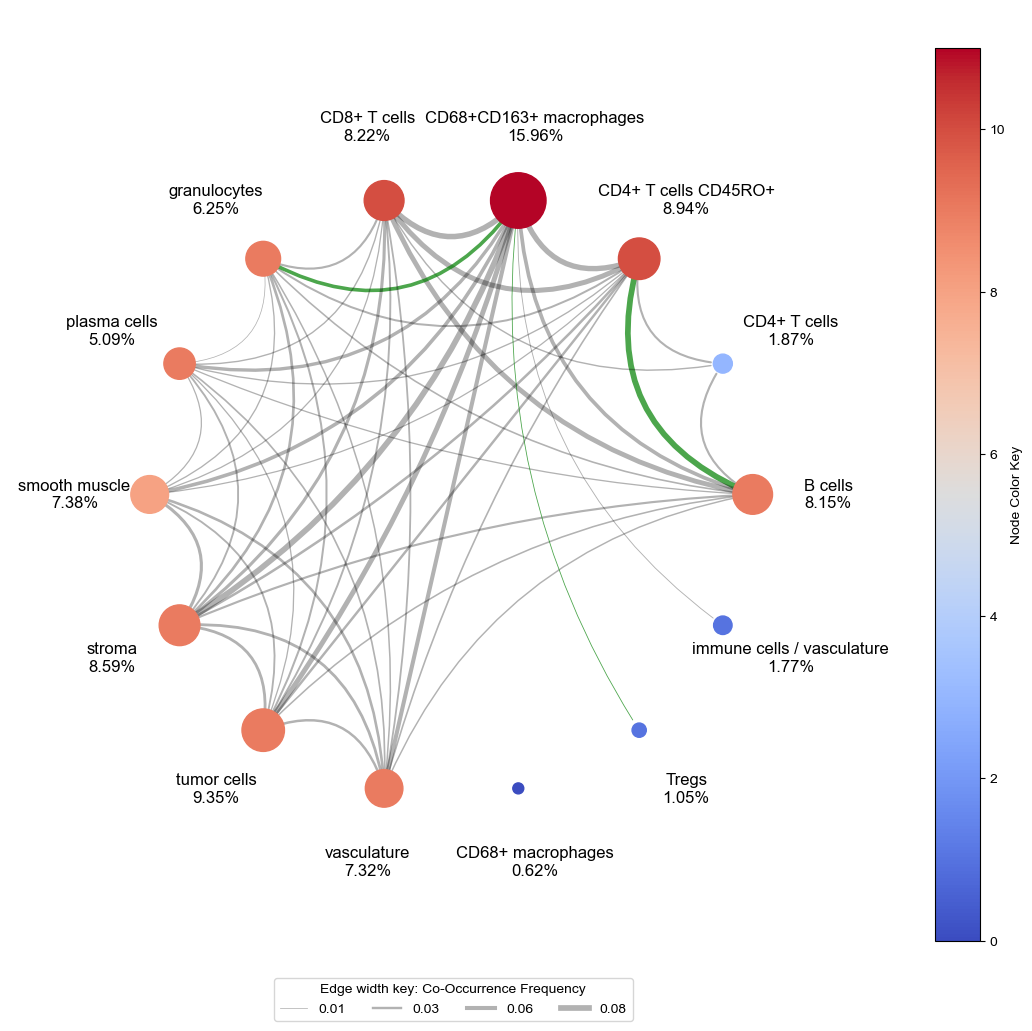

In [40]:
patient_group = 'CLR'
cirplot_save_path = '../figures/crc/hotspot_circleplot_'+ patient_group +'.svg'
msd.create_circos_plot(circoplot_df1.loc[[patient_group]], 
                       cell_type_colors_hex=None,
                       cell_abundance=circoplot_df2.loc[[patient_group]],
                       threshold=0.01, 
                       edge_weights_scaler=50,
                       highlighted_edges=highlighted_comb,
                       node_weights_scaler=10000,
                       figure_size=(10,10),
                       save_path=cirplot_save_path)

## hot spot:whole tissue fold of change

In [33]:
# Add a source column to each dataframe
grouped_melted['source'] = 'Whole Tissue'
df_melted['source'] = 'Hot Spots'

# Combine the dataframes
combined_df = pd.concat([grouped_melted, df_melted], ignore_index=True)

[8.296296296296296, 6.554621848739496, 5.682009929337231, 4.493827160493828, 3.346832794094535, 3.3250428961071656, 3.235910153609909, 3.073792289111021, 3.0030433570267494, 2.9809339049877566, 2.8942335711777396, 2.8473924905323433, 2.8260553112071167, 2.7872750350238857, 2.762926124817845, 2.7297768813589305, 2.712918073308309, 2.7115871260397832, 2.680939073118914, 2.6800768857848296, 2.6788434631244766, 2.659177786675386, 2.642419868996544, 2.639080544373632, 2.614238893257767, 2.6087879068495963, 2.6063069299270336, 2.567645004233149, 2.548666983647195, 2.548666983647195, 2.5225276537270136, 2.5225276537270136, 2.4963915127599914, 2.4963915127599914, 2.485824180445299, 2.4738096163525, 2.4738096163525, 2.46369562997018, 2.46369562997018, 2.4367584372771973, 2.3569571459088716, 2.346620500252941, 2.2645597334765615, 2.258570846892269, 2.178202676503979, 2.1315604064268605, 2.090828723354424, 2.0414615705276553, 2.0224952409955, 2.001319347223646, 1.8605980433281153, 1.8430216563469

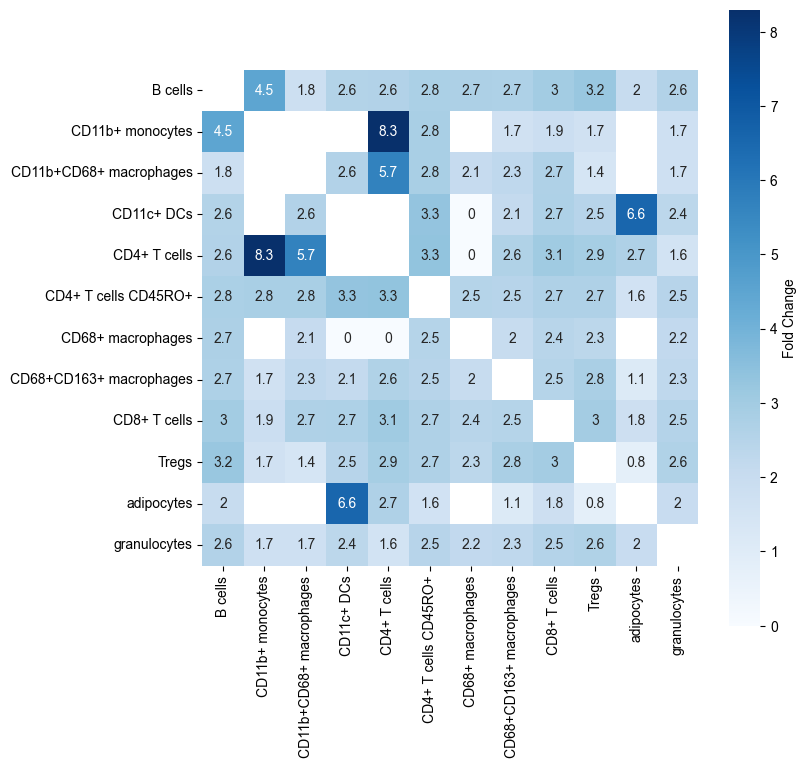

In [35]:
fold_changes = {}
patient_group = 'DII'
for combo in pairwise_combinations:
    cell_type_1, cell_type_2 = combo
    
    # Mean frequency for Whole Tissue
    whole_tissue_mean = combined_df[(combined_df['CellType'] == ' '.join(combo)) & (combined_df['Condition'] == patient_group) &
                                    (combined_df['source'] == 'Whole Tissue')]['Frequency'].mean()
    
    # Mean frequency for Hot Spots
    hot_spots_mean = combined_df[(combined_df['CellType'] == ' '.join(combo)) & (combined_df['Condition'] == patient_group) &
                                 (combined_df['source'] == 'Hot Spots')]['Frequency'].mean()
    
    # if ' '.join(combo) in remarkable_combinations:
    if whole_tissue_mean == 0 and hot_spots_mean != 0:
        fold_change = hot_spots_mean / (whole_tissue_mean + 1e-10)
    else:
        fold_change = hot_spots_mean / whole_tissue_mean
    fold_changes[(cell_type_1, cell_type_2)] = fold_change

# Convert fold_changes to a matrix for heatmap
heatmap_data = pd.DataFrame(index=selected_cell_combs, columns=selected_cell_combs)

for (cell_type_1, cell_type_2), fold_change in fold_changes.items():
    heatmap_data.at[cell_type_1, cell_type_2] = fold_change
    heatmap_data.at[cell_type_2, cell_type_1] = fold_change  # Because it's symmetric
    
sorted_values = sorted([value for value in np.unique(heatmap_data.values.ravel()) if not np.isnan(value)], reverse=True)
print(sorted_values)

# Check the top value, and if it's infinite, select the second top value
for sorted_value in sorted_values:
    if sorted_value != np.inf:
        vmax_value = sorted_value
        break  # exit the loop once the value is found
# vmax_value = 8.296296296296296

plt.figure(figsize=(8, 8))
sns.heatmap(heatmap_data.astype(float), annot=True, cmap='Blues', cbar_kws={'label': 'Fold Change'}, square=True, vmax=vmax_value, vmin=0)
plt.savefig("../figures/crc/fold_change_heatmap_"+patient_group+'.svg')
plt.savefig("../figures/crc/fold_change_heatmap_"+patient_group+'.jpeg')
plt.show()

[inf, 15.684365580380339, 15.684365580380339, 11.421289866715936, 10.47558286287549, 8.010306892693167, 5.688400699646374, 5.344223503304071, 5.344223503304071, 4.102865710915892, 4.102865710915892, 3.9219264822974957, 3.9219264822974957, 3.833778173466024, 3.833778173466024, 3.633452370882632, 3.633452370882632, 3.612238711071132, 2.730845279051562, 2.730845279051562, 2.3730944808903023, 1.8563732767955388, 1.846255022763201, 1.755935554760865, 1.6449014785518634, 1.4189752804778721, 1.4038460798927666, 1.3477806671073949, 1.2261324848536783, 1.2125715364603313, 0.9909582573426599, 0.9699491125934603, 0.881662492384756, 0.7832755423099487, 0.7795200475269356, 0.7607470866493922, 0.7607470866493922, 0.7114220834809032, 0.7114220834809032, 0.681053505405576, 0.681053505405576, 0.5999165309946015, 0.5999165309946015, 0.5983732730173646, 0.5983732730173646, 0.5821061724393041, 0.5821061724393041, 0.542200404905016, 0.542200404905016, 0.5334396696127561, 0.5334396696127561, 0.4844253490870

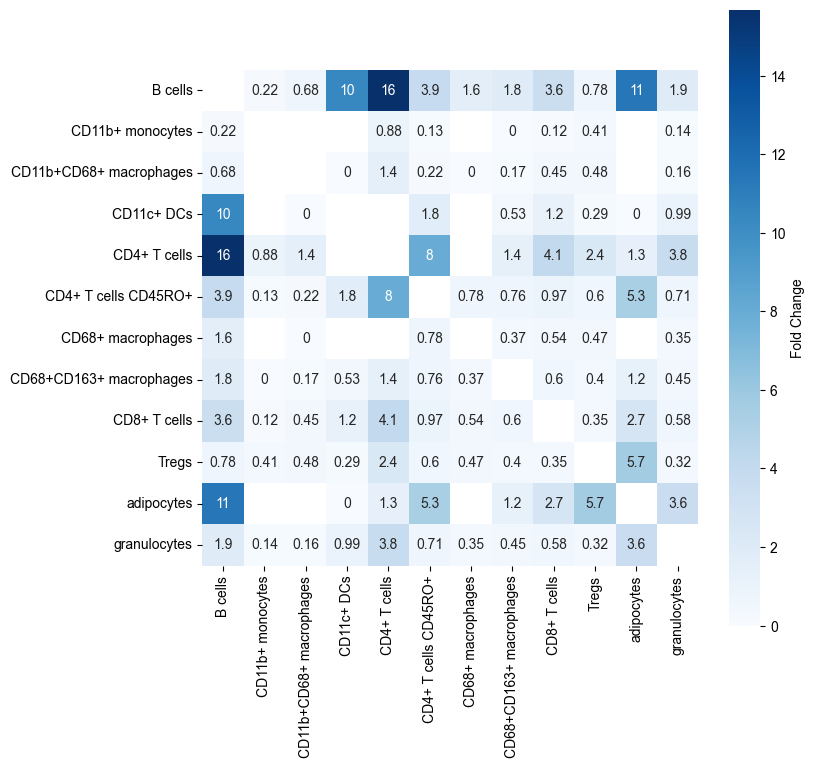

In [79]:
fold_changes = {}
region_group = 'Hot Spots'
for combo in pairwise_combinations:
    cell_type_1, cell_type_2 = combo
    
    # Mean frequency for Whole Tissue
    CLR_mean = combined_df[(combined_df['CellType'] == ' '.join(combo)) & (combined_df['source'] == region_group) &
                                    (combined_df['Condition'] == 'CLR')]['Frequency'].mean()
    
    # Mean frequency for Hot Spots
    DII_mean = combined_df[(combined_df['CellType'] == ' '.join(combo)) & (combined_df['source'] == region_group) &
                                 (combined_df['Condition'] == 'DII')]['Frequency'].mean()
    # if ' '.join(combo) in remarkable_combinations:
    if DII_mean == 0 and CLR_mean != 0:
        fold_change = np.inf
    else:
        fold_change = CLR_mean / DII_mean
    fold_changes[(cell_type_1, cell_type_2)] = fold_change
    
# Convert fold_changes to a matrix for heatmap
heatmap_data = pd.DataFrame(index=selected_cell_combs, columns=selected_cell_combs)

for (cell_type_1, cell_type_2), fold_change in fold_changes.items():
    heatmap_data.at[cell_type_1, cell_type_2] = fold_change
    heatmap_data.at[cell_type_2, cell_type_1] = fold_change  # Because it's symmetric

sorted_values = sorted([value for value in np.unique(heatmap_data.values.ravel()) if not np.isnan(value)], reverse=True)
print(sorted_values)

# Check the top value, and if it's infinite, select the second top value
for sorted_value in sorted_values:
    if sorted_value != np.inf:
        vmax_value = sorted_value
        break  # exit the loop once the value is found
        
print(f"vmax values is {vmax_value}")
plt.figure(figsize=(8, 8))
sns.heatmap(heatmap_data.astype(float), annot=True, cmap='Blues', cbar_kws={'label': 'Fold Change'}, square=True, vmax=vmax_value)
plt.savefig("../figures/crc/fold_change_heatmap_"+region_group+'.svg')
plt.savefig("../figures/crc/fold_change_heatmap_"+region_group+'.jpeg')
plt.show()

# Calculate Multi-Scale Homogeneity Index

In [11]:
# Define the sequence of scales
scales = [1., 2., 4., 8., 16.]
# scales = [2., 4., 8., 16., 32., 48., 64.] # for scale selection with multi-scale GDI

In [12]:
# Perform Multiscale Diversity Analysis
library_names = ['CLR', 'DII'] 
metric_results = []
for library, library_name in zip(library_ids, library_names):
    df_scales, df_slopes = msd.multiscale_diversity(spatial_data=protein,
                                                    scales=scales,
                                                    library_key='File Name',
                                                    library_ids=library,
                                                    spatial_key=['X:X','Y:Y'],
                                                    cluster_key='ClusterName',
                                                    mode='D',
                                                    random_patch=False,
                                                    plotfigs=False,
                                                    savefigs=False,
                                                    patch_kwargs={'max_overlap':0.5,'random_seed': 42, 'min_points':2},
                                                    other_kwargs={'metric': 'Shannon Diversity'})
    
    df_metric = pd.concat([df_scales,df_slopes]).astype('float32')
    print(df_metric.head())
    averaged_metric = pd.DataFrame()  
    
    keys = list(df_metric.columns)
    for patient, regions in patient_to_region.items():
        # select keys that correspond to the current patient
        selected_keys = [region for region in regions if region in keys]
        print(selected_keys)
        
        if selected_keys:
            metric_list = df_metric[selected_keys]
            averaged_metric[patient] = np.array(metric_list).mean(axis=1) # mean for MHI; max for GDI
            
    averaged_metric['Condition'] = library_name  
    metric_results.append(averaged_metric)  

Processing region: reg001_A at scale 1.0
0.000 per cent patches are empty
reg001_A at scale 1.0 has 0 patches with zero diveristy
reg001_A at scale 1.0 diversity is 3.3164164900586974
Processing region: reg001_B at scale 1.0
0.000 per cent patches are empty
reg001_B at scale 1.0 has 0 patches with zero diveristy
reg001_B at scale 1.0 diversity is 3.354147234904591
Processing region: reg002_A at scale 1.0
0.000 per cent patches are empty
reg002_A at scale 1.0 has 0 patches with zero diveristy
reg002_A at scale 1.0 diversity is 3.151848682137609
Processing region: reg002_B at scale 1.0
0.000 per cent patches are empty
reg002_B at scale 1.0 has 0 patches with zero diveristy
reg002_B at scale 1.0 diversity is 1.1192231346242458
Processing region: reg011_A at scale 1.0
0.000 per cent patches are empty
reg011_A at scale 1.0 has 0 patches with zero diveristy
reg011_A at scale 1.0 diversity is 3.1236111964254585
Processing region: reg011_B at scale 1.0
0.000 per cent patches are empty
reg011_B

KeyboardInterrupt: 

In [ ]:
msd.display_patches(spatial_data=protein, 
                    library_key="File Name", 
                    library_ids=['reg001_A'],
                    spatial_key=['X:X','Y:Y'], 
                    cluster_keys=['ClusterName','neighborhood name'],
                    scale=2.0,
                    random_patch=False)

In [33]:
# Combine results into single dataframe
df_final = pd.concat(metric_results).T
clr_final = df_final.iloc[:df_final.index.get_loc('Condition')].dropna(axis=1, how='all')
clr_final['Condition'] = 'CLR'
dii_final = df_final.iloc[df_final.index.get_loc('Condition')+1:].dropna(axis=1, how='all')
dii_final['Condition'] = 'DII'
df_results = pd.concat([clr_final, dii_final])
df_results.columns = scales+['Metric_Slope','Condition']
df_results['Sample_id'] = df_results.index
df_results

1.0       2.0       4.0       8.0      16.0 Metric_Slope Condition  \
1   2.735409  2.519364  2.196352  1.652484  1.005014     0.432767       CLR   
6   3.091561   2.72638  2.352608  1.905939   1.37691     0.424974       CLR   
10  2.865577  2.630261  2.250778  1.752131  1.264583     0.408012       CLR   
11  3.030774  2.904184  2.505228  1.933249  1.249184     0.453412       CLR   
12  2.496194  2.357985  2.168898  1.833694  1.287313     0.294205       CLR   
13   3.10875   2.94518  2.713655  2.277876  1.617662     0.364948       CLR   
17  2.632776  2.537832  2.399208  2.011313  1.506856     0.277836       CLR   
19  2.889599   2.71975  2.446007  1.934817  1.280454     0.400322       CLR   
20  2.934031  2.735336  2.422676  1.844559  1.286653     0.418553       CLR   
21  2.066639  1.960674  1.759059  1.453351  0.985503     0.266959       CLR   
24  2.852282  2.697908  2.459984  1.959332  1.297111     0.384892       CLR   
28  3.156405   2.93777  2.496709  1.901052  1.252056     0.484542       CLR   
29  1.925492  1.665393  1.380833  1.022411  0.655212     0.318354       CLR   
32  2.856127  2.752253  2.526884  2.108894  1.397715     0.356018       CLR   
33  2.603902  2.463525  2.171206  1.703185  1.019909     0.392833       CLR   
34  3.110318  2.800382  2.516175   1.86941  1.155782     0.484004       CLR   
35   2.99594   2.65474  2.399353  1.930142  1.213407     0.428966       CLR   
2   2.735204  2.620569  2.400419  2.023477  1.480671     0.310616       DII   
3   3.031438  2.846666   2.56746   2.20253  1.582137     0.354274       DII   
4   2.679496  2.401382  2.074035  1.760649   1.33903     0.332167       DII   
5   3.054683  2.933089  2.708526  2.341326  1.721699     0.325773       DII   
7   2.856732  2.665677  2.418124  1.990804  1.381371      0.36256       DII   
8   2.562878  2.447626  2.250904  1.904271  1.354426     0.296026       DII   
9   3.090887  2.841036  2.527657  2.144199  1.595249     0.368811       DII   
14  3.004387  2.892924  2.712159  2.333473  1.761452     0.304532       DII   
15  2.542124  2.307198   2.09686  1.776386  1.296025     0.302301       DII   
16  3.200839   3.06839  2.832928  2.414936   1.76281     0.352951       DII   
18  2.773325  2.591675  2.305762  1.930631  1.464974     0.327775       DII   
22  2.357698  2.057611  1.817171  1.385601  0.830649     0.372611       DII   
23  2.973385  2.858765  2.685628  2.286166  1.640287     0.323879       DII   
25  2.666065   2.48633  2.273852  1.915666  1.297563     0.330767       DII   
26  2.801955   2.52936  2.240815  1.865415  1.352777      0.35623       DII   
27  2.973612  2.679679  2.138004  1.741205  1.139954     0.460579       DII   
30  3.005658  2.911838  2.751437  2.417064  1.893092     0.271991       DII   
31   3.06136  2.859559  2.641573  2.202004  1.552658     0.367496       DII   

    Sample_id  
1           1  
6           6  
10         10  
11         11  
12         12  
13         13  
17         17  
19         19  
20         20  
21         21  
24         24  
28         28  
29         29  
32         32  
33         33  
34         34  
35         35  
2           2  
3           3  
4           4  
5           5  
7           7  
8           8  
9           9  
14         14  
15         15  
16         16  
18         18  
22         22  
23         23  
25         25  
26         26  
27         27  
30         30  
31         31

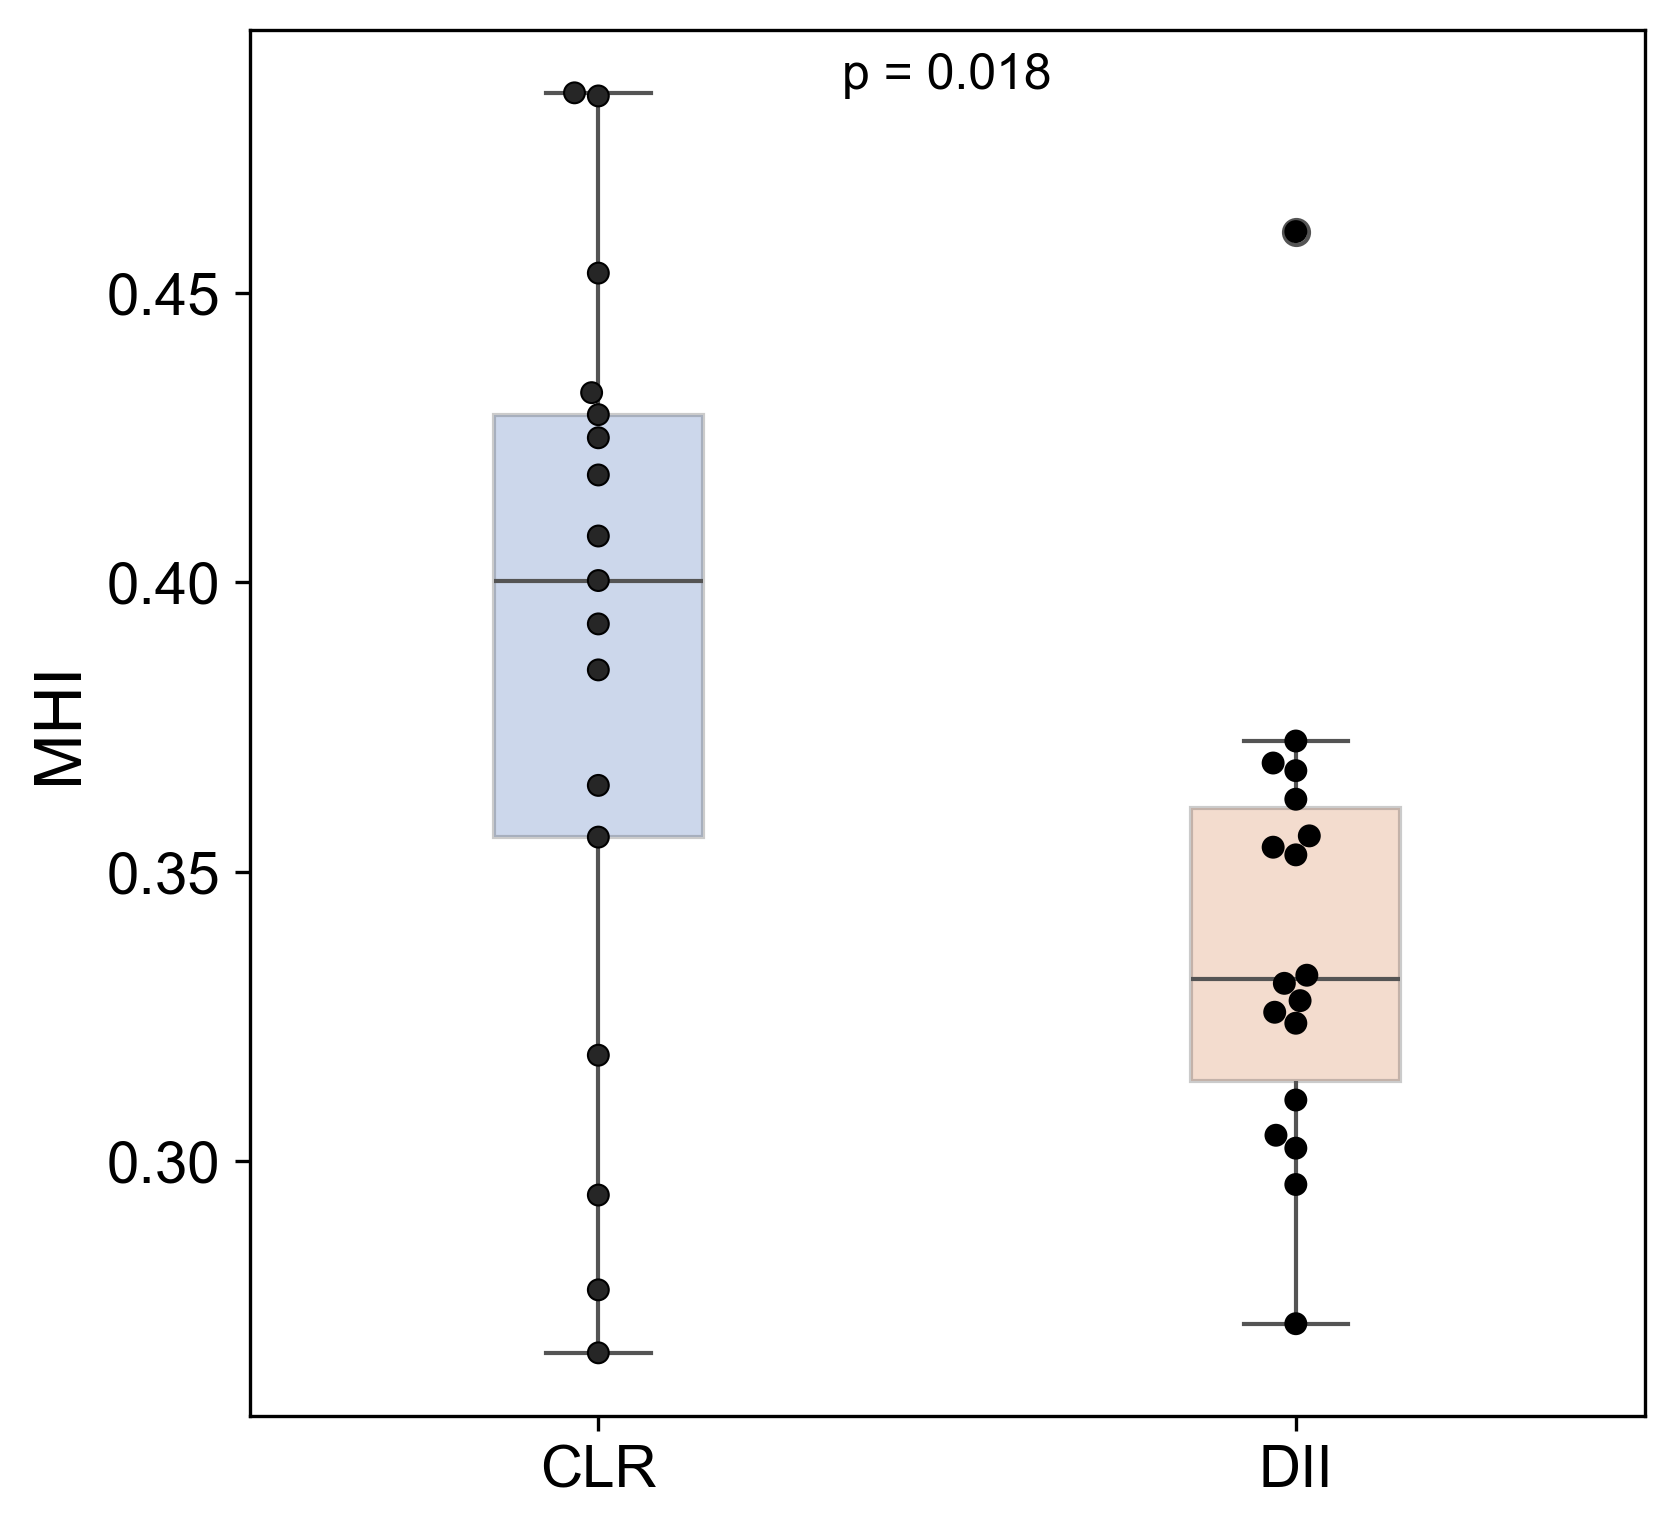

In [34]:
fig, ax = plt.subplots(figsize=(6, 6),dpi=300)

# Boxplot
sns.boxplot(data=df_results, x='Condition', y='Metric_Slope', hue='Condition', 
            ax=ax, palette="muted", width=0.3, boxprops=dict(alpha=.3), legend=False)

sns.swarmplot(data=df_results, x='Condition', 
              y='Metric_Slope', palette='dark:black', hue='Condition',
              linewidth=0.5, size=5, ax=ax, legend=False)

# Labeling and titling
ax.set_xlabel('', fontsize=14)  # Modify as necessary
ax.set_ylabel('MHI', fontsize=16)  # Modify as necessary
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Separate data into two conditions
data_condition_1 = clr_final[len(scales)].astype(np.float32)
data_condition_2 = dii_final[len(scales)].astype(np.float32)

# Perform Mann-Whitney U test
#U_stat, p_val = stats.mannwhitneyu(data_condition_1, data_condition_2, alternative='two-sided')
stat, p_val = stats.ttest_ind(data_condition_1, data_condition_2 ,equal_var=False)

ax.text(0.5, 0.95, f'p = {p_val:.3f}', 
        horizontalalignment='center', verticalalignment='bottom', 
        transform=ax.transAxes, fontsize=12)

save_path = 'MSDiversity_slope.svg'
fig = plt.gcf()
# fig.savefig('../figures/crc/'+save_path)

plt.show()
plt.close(fig)

# Survival Analysis

In [35]:
meta_path = '/Users/Emrys/Dropbox/spatial_augmentation/data/CRC_related/crc_codex/'
meta_df = pd.read_csv(os.path.join(meta_path, 'CRC_TMAs_patient_annotations.csv'))

In [36]:
# Convert 'Patient' column in meta_df to string
# Drop rows from 35 onwards where any NaN appears
meta_df = meta_df.loc[:34]

In [ ]:
freq_df = spot_comb_df[('B cells','CD4+ T cells CD45RO+')].to_frame()
freq_df = df_melted[df_melted['CellType']=='Tregs']
# freq_df.columns = ['Frequency']
# freq_df['Condition'] = spot_comb_df[('Condition')]
# freq_df['Patient'] = freq_df.index
freq_df

In [18]:
df_melted['Patient'] = df_melted.index
df_combined = pd.merge(df_melted, meta_df[['Patient','OS','OS_Censor']], on='Patient', how='inner')
# df_combined['GDI'] = [v for k, v in moran_results['CLR'].items()] + [v for k, v in moran_results['DII'].items()]
# df_combined['DPI'] = PX_results['CLR'] + PX_results['DII']
# df_combined = pd.merge(freq_df, meta_df[['Patient','OS','OS_Censor']], on='Patient', how='inner')
df_combined.head()

1.0       2.0       4.0       8.0      16.0 Metric_Slope Condition  \
0  2.735409  2.519364  2.196352  1.652484  1.005014     0.432767       CLR   
1  3.091561   2.72638  2.352608  1.905939   1.37691     0.424974       CLR   
2  2.865577  2.630261  2.250778  1.752131  1.264583     0.408012       CLR   
3  3.030774  2.904184  2.505228  1.933249  1.249184     0.453412       CLR   
4  2.496194  2.357985  2.168898  1.833694  1.287313     0.294205       CLR   

   Patient       OS  OS_Censor  
0        1   71.335        0.0  
1        6  125.542        0.0  
2       10  124.096        0.0  
3       11   70.118        0.0  
4       12  105.161        0.0

In [19]:
from lifelines.utils import k_fold_cross_validation
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

In [20]:
df_melted.columns[:-3]

Index([1.0, 2.0, 4.0, 8.0, 16.0], dtype='object')

In [36]:
cph = CoxPHFitter(penalizer=0.005,l1_ratio=1)
scaler = MinMaxScaler()

feature = df_melted.columns[:-3].tolist()
feature = ['Metric_Slope']

df_subset = df_combined[['OS', 'OS_Censor', 'Condition']+feature].copy()
# df_subset[feature] = scaler.fit_transform(df_subset[feature])
df_subset['Condition'] = df_subset['Condition'].map(patient_condition)

# Apply K-means clustering
# kmeans = KMeans(n_clusters=2, n_init='auto', random_state=0).fit(df_subset[feature])
# df_subset['label'] = kmeans.labels_

# Calculate the median value of the feature
# median_value = df_subset['DPI'].median()
# df_subset['label'] = (df_subset['DPI'] > median_value).astype(int)

scores = k_fold_cross_validation(cph, 
                                 df_subset[['OS', 'OS_Censor']+feature], 
                                 duration_col='OS', 
                                 event_col='OS_Censor', 
                                 k=5, 
                                 scoring_method="concordance_index",
                                 seed=0)
print(scores)

[0.7333333333333333, 0.5714285714285714, 0.6153846153846154, 0.35294117647058826, 0.6111111111111112]


In [37]:
mean_score = np.mean(scores)
std_deviation = np.std(scores)

print(f"Mean Concordance Index: {mean_score:.3f}")
print(f"Standard Deviation: {std_deviation:.3f}")

Mean Concordance Index: 0.577
Standard Deviation: 0.124


# Find the optimal cut-off threshold that maximizes statistical significance

In [25]:
df_combined['risk_score'] = cph.predict_partial_hazard(df_combined)
df_combined

Patient Condition    Metric  Metric2.0  Metric4.0  Metric8.0  Metric16.0  \
0        1       CLR  2.735409   2.519364   2.196352   1.652484    1.005014   
1        6       CLR  3.091561   2.726380   2.352608   1.905939    1.376910   
2       10       CLR  2.865577   2.630261   2.250778   1.752131    1.264583   
3       11       CLR  3.030774   2.904184   2.505228   1.933249    1.249184   
4       12       CLR  2.496194   2.357985   2.168898   1.833694    1.287313   
5       13       CLR  3.108750   2.945180   2.713655   2.277876    1.617662   
6       17       CLR  2.632776   2.537832   2.399208   2.011313    1.506856   
7       19       CLR  2.889599   2.719750   2.446007   1.934817    1.280454   
8       20       CLR  2.934031   2.735336   2.422676   1.844559    1.286653   
9       21       CLR  2.066639   1.960674   1.759059   1.453351    0.985503   
10      24       CLR  2.852282   2.697908   2.459984   1.959332    1.297111   
11      28       CLR  3.156405   2.937770   2.496709   1.901052    1.252056   
12      29       CLR  1.925492   1.665393   1.380833   1.022411    0.655212   
13      32       CLR  2.856127   2.752253   2.526884   2.108894    1.397715   
14      33       CLR  2.603902   2.463525   2.171206   1.703185    1.019909   
15      34       CLR  3.110318   2.800382   2.516175   1.869410    1.155782   
16      35       CLR  2.995940   2.654740   2.399353   1.930142    1.213407   
17       2       DII  2.735204   2.620569   2.400419   2.023477    1.480671   
18       3       DII  3.031438   2.846666   2.567460   2.202530    1.582137   
19       4       DII  2.679496   2.401382   2.074035   1.760649    1.339030   
20       5       DII  3.054683   2.933089   2.708526   2.341326    1.721699   
21       7       DII  2.856732   2.665677   2.418124   1.990804    1.381371   
22       8       DII  2.562878   2.447626   2.250904   1.904271    1.354426   
23       9       DII  3.090887   2.841036   2.527657   2.144199    1.595249   
24      14       DII  3.004387   2.892924   2.712159   2.333473    1.761452   
25      15       DII  2.542124   2.307198   2.096860   1.776386    1.296025   
26      16       DII  3.200839   3.068390   2.832928   2.414936    1.762810   
27      18       DII  2.773325   2.591675   2.305762   1.930631    1.464974   
28      22       DII  2.357698   2.057611   1.817171   1.385601    0.830649   
29      23       DII  2.973385   2.858765   2.685628   2.286166    1.640287   
30      25       DII  2.666065   2.486330   2.273852   1.915666    1.297563   
31      26       DII  2.801955   2.529360   2.240815   1.865415    1.352777   
32      27       DII  2.973612   2.679679   2.138004   1.741205    1.139954   
33      30       DII  3.005658   2.911838   2.751437   2.417064    1.893092   
34      31       DII  3.061360   2.859559   2.641573   2.202004    1.552658   

    Metric_Slope       OS  OS_Censor  risk_score  
0       0.432767   71.335        0.0    0.151654  
1       0.424974  125.542        0.0    3.546232  
2       0.408012  124.096        0.0    0.521965  
3       0.453412   70.118        0.0    0.109382  
4       0.294205  105.161        0.0    1.754331  
5       0.364948   42.965        0.0    0.974226  
6       0.277836  138.034        0.0    0.588950  
7       0.400322   17.719        1.0    0.225173  
8       0.418553  112.393        0.0    0.098923  
9       0.266959   41.148        0.0    1.361311  
10      0.384892   32.721        0.0    0.212280  
11      0.484542   49.178        0.0    0.162401  
12      0.318354   46.515        0.0    1.310493  
13      0.356018   11.275        1.0    0.651689  
14      0.392833   16.200        1.0    0.281561  
15      0.484004   18.540        0.0    0.065981  
16      0.428966   40.500        1.0    1.308297  
17      0.310616  137.640        0.0    1.160334  
18      0.354274    0.394        1.0    3.806562  
19      0.332167    0.526        1.0   10.613328  
20      0.325773   43.458        1.0    2.295309  
21      0.362560   68.179        0.0

0.0020301417745138836


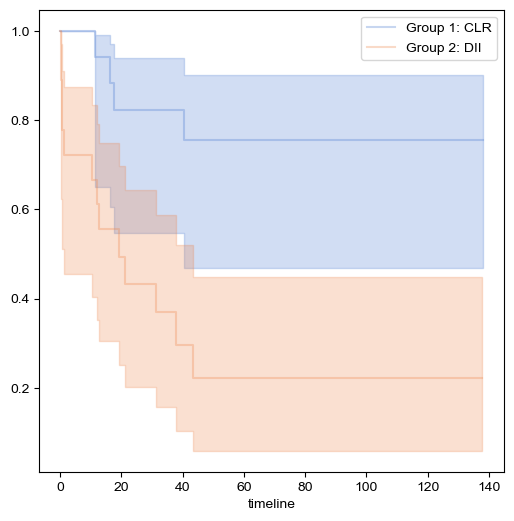

In [26]:
kmf = KaplanMeierFitter()

# Set the color palette to "muted" and get the colors
sns.set_palette("muted")
colors = sns.color_palette()

# Split the dataframe using best_threshold
df_group1 = df_combined[df_combined['Condition'] == 'CLR']
df_group2 = df_combined[df_combined['Condition'] == 'DII']

# Calculate logrank_test p-value
result = logrank_test(df_group1['OS'], df_group2['OS'], event_observed_A=df_group1['OS_Censor'], event_observed_B=df_group2['OS_Censor'])
p_value = result.p_value
print(p_value)

# Fit the model for each group and use the colors
kmf = KaplanMeierFitter()
plt.figure(figsize=(6, 6))

# Plot for Group 1
kmf.fit(df_group1['OS'], df_group1['OS_Censor'], label='Group 1: CLR')
ax = kmf.plot_survival_function(color=colors[0], alpha=0.3)

# Plot for Group 2
kmf.fit(df_group2['OS'], df_group2['OS_Censor'], label='Group 2: DII')
kmf.plot_survival_function(ax=ax, color=colors[1], alpha=0.3)

save_path = 'CRC_survivalKM_clrdii.svg'
fig = plt.gcf()
# fig.savefig('../figures/crc/'+save_path)

plt.show()
plt.close(fig)


0.2720446508744352
0.6142979626118796
0.6002024318884672
0.898329816766461
0.18323461101416588
0.9294013059287932
0.2975714982826278
nan
0.910874580725924
0.2720581310236049
0.3926650397069067
0.3311347937322956
0.7116727121290223
0.558697602241819
0.6051952848183031
0.5183506969660835
0.1962239825824829
0.7168072511407849
0.5527863700390723
0.7945842689732847
0.3216619941043417
0.48413840653574003
0.3307542424153726
0.8304899764144871
0.407773877496874
0.25581291361364134
0.9061955016463858
0.5226720728919183
0.5684014104360526
0.42992257092344155
0.9680171197607632
0.15237795695583642
0.08729644909357116
0.32138594945071086
0.29694226809100377
The best p_value is 0.08729644909357116


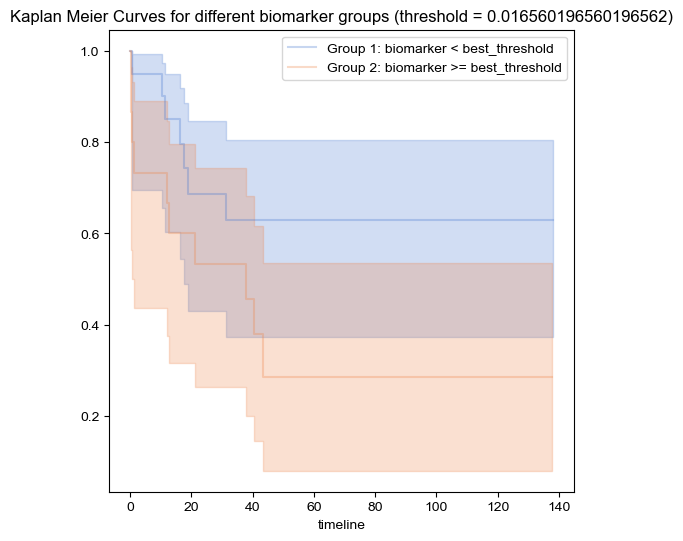

In [127]:
kmf = KaplanMeierFitter()

# Define all possible cutpoints
metric = 'Frequency' # 'risk_score'
cutpoints = df_combined[metric].unique()

# Initialize best threshold
best_threshold = cutpoints[0]
best_p_value = 1.0

# Define p-value tolerance
p_value_tolerance = 0.002

# Iterate over all possible cutpoints
for threshold in cutpoints:
    # Split the dataframe
    df_group1 = df_combined[df_combined[metric] < threshold]
    df_group2 = df_combined[df_combined[metric] >= threshold]

    # Calculate logrank_test p-value
    result = logrank_test(df_group1['OS'], df_group2['OS'], event_observed_A=df_group1['OS_Censor'], event_observed_B=df_group2['OS_Censor'])
    p_value = result.p_value
    print(p_value)
    
    # Update best_threshold if current p_value is smaller than best_p_value
    if p_value < best_p_value:
        best_p_value = p_value
        best_threshold = threshold
    
    # Stop the loop if p_value is less than the specified tolerance
    if p_value < p_value_tolerance:
        break

print(f"The best p_value is {best_p_value}")

# Set the color palette to "muted" and get the colors
sns.set_palette("muted")
colors = sns.color_palette()

# Split the dataframe using best_threshold
df_group1 = df_combined[df_combined[metric] < best_threshold]
df_group2 = df_combined[df_combined[metric] >= best_threshold]

# Fit the model for each group and use the colors
kmf = KaplanMeierFitter()
plt.figure(figsize=(6, 6))

# Plot for Group 1
kmf.fit(df_group1['OS'], df_group1['OS_Censor'], label='Group 1: biomarker < best_threshold')
ax = kmf.plot_survival_function(color=colors[0], alpha=0.3)

# Plot for Group 2
kmf.fit(df_group2['OS'], df_group2['OS_Censor'], label='Group 2: biomarker >= best_threshold')
kmf.plot_survival_function(ax=ax, color=colors[1], alpha=0.3)

plt.title(f'Kaplan Meier Curves for different biomarker groups (threshold = {best_threshold})')

save_path = 'CRC_survivalKM.svg'
fig = plt.gcf()
# fig.savefig('../figures/crc/'+save_path)

plt.show()
plt.close(fig)


In [123]:
print(f"Group 1 has {len(df_group1)} patients, {len(df_group1[df_group1['Condition']=='CLR'])} are from CLR")
print(f"Group 2 has {len(df_group2)} patients, {len(df_group2[df_group2['Condition']=='CLR'])} are from CLR")

Group 1 has 14 patients, 3 are from CLR
Group 2 has 21 patients, 14 are from CLR


In [214]:
c_index = [[0.7333333333333333, 0.7857142857142857, 0.6153846153846154, 0.6176470588235294, 0.8333333333333334],
           [0.8666666666666667, 0.5714285714285714, 0.6923076923076923, 0.7058823529411765, 0.8333333333333334], 
           [0.8, 0.7857142857142857, 0.6923076923076923, 0.6470588235294118, 0.8888888888888888]]
covar = ['CLR/DII', 'MSD', 'MSD+CLR/DII']

In [246]:
from matplotlib.ticker import AutoMinorLocator

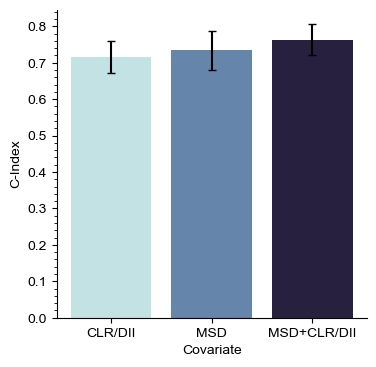

In [248]:
# Converting data into a pandas DataFrame for easier plotting with seaborn
data = []
for i, covariate in enumerate(covar):
    for c in c_index[i]:
        data.append({'Covariate': covariate, 'C-Index': c})
cindex_df = pd.DataFrame(data)

# Calculate mean and standard error of the mean (SEM) for each Covariate
group_stats = cindex_df.groupby('Covariate')['C-Index'].agg(['mean', 'sem']).reset_index()
gradient_palette = sns.color_palette("ch:start=.2,rot=-.3", len(group_stats))

# Plot
plt.figure(figsize=(4, 4))
plt.bar(group_stats['Covariate'], group_stats['mean'], yerr=group_stats['sem'], color=gradient_palette,capsize=3)
plt.xlabel('Covariate')
plt.ylabel('C-Index')
plt.title('')

# Get current axes and hide the top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_minor_locator(AutoMinorLocator())

save_path = 'CRC_cindex.svg'
cindex_fig = plt.gcf()
cindex_fig.savefig('../figures/crc/' + save_path)

plt.show()
plt.close(cindex_fig)
